## Mounting Gdrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing libraries


In [3]:
! pip install e2cnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 895.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

Every noisy_images.npy file has shape (nobs, nch, npix, npix) and contain the images that should be used as input data for the ML pipeline.

every labels.npy file has shape (nobs, 3, nbins).
We have nbins = 20 spanning  geometric radial distances from 1 to 100 kPc.
Regardin the 3 channels:
-  labels[:,0,:] correspond to the dark matter mass enclosed at each radial bin.
-  labels[:,1,:] correspond to the star mass enclosed at each radial bin.
-  labels[:,2,:] correspond to the gas mass enclosed at each radial bin.


# Training equivariant and steerable CNN

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
from tqdm import tqdm
import time
from scipy import stats
import seaborn as sbn
import pandas as pd
import h5py
import os
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter
import glob
import matplotlib.patches as patches

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [6]:
print('numpy version:', np.__version__)
print('matplotlib version:', mpl.__version__)
print('torch version:', torch.__version__)

# Check if gpu is available
if torch.cuda.is_available():
    device = 'gpu'
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')


numpy version: 2.0.2
matplotlib version: 3.10.0
torch version: 2.6.0+cu124
Using GPU


In [7]:
torch.device('cuda:0')

device(type='cuda', index=0)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        #read the input images and labels and save them in 2 tensors
        image = torch.tensor(self.x_data[idx], dtype=torch.float32)
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label

In [9]:
R_bins = np.geomspace(1,100,20)

In [10]:
#R_bins_new =np.delete(R_bins, 1)

In [11]:
#R_bins_new.size

In [12]:
#arqB_8ch = np.loadtxt("../data/red_curve_data.csv", delimiter=",", skiprows=1)

## Custom functions

In [13]:
def estimate_saliency_map(model, image, radial_bin, noise_levels = np.array([1e-3,1e-3,1e-3,1e-3,1e-3,1e-2,1e-5,1e-7]).reshape(1,8,1,1),
                         num_perturbations = 20):

    image.requires_grad = True  # Enable gradient computation

    # Initialize an empty tensor to accumulate gradients
    accumulated_saliency = torch.zeros_like(image)
    with torch.autograd.set_detect_anomaly(True):
      for _ in range(num_perturbations):
        # Add Gaussian noise to the image
        noisy_image = image + torch.Tensor(noise_levels) * torch.randn_like(image)

        # Forward pass
        output = model(noisy_image)

        # Zero out any previous gradients
        model.zero_grad()

        # Compute the gradient of the output with respect to the target index
        output[0, radial_bin].backward(retain_graph=True)

        # Accumulate the gradients
        accumulated_saliency += image.grad

    # Average the accumulated saliency maps
    accumulated_saliency /= num_perturbations

    # Get the final saliency map (absolute value of gradients)
    saliency_map = accumulated_saliency.abs().squeeze() #.detach().cpu().numpy()

    return saliency_map

In [14]:
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter
import glob
import matplotlib.patches as patches
from scipy.stats import binned_statistic

In [15]:
def dm_from_stellar(stellar_profile, num_smass_bins = 10):
    dm_profile     = np.zeros_like(stellar_profile)
    dm_profile_std = np.zeros_like(stellar_profile)

    for i in range(20):
        stellar_mass_bins = np.linspace(np.min(np.log10(labels[:,1,i])), np.max(np.log10(labels[:,1,i])), num_smass_bins)
        aux_bin = np.digitize(np.log10(stellar_profile[i]), stellar_mass_bins)

        ind = np.where( (np.log10(labels[:,1,i]) > stellar_mass_bins[aux_bin-1]) &
                  (np.log10(labels[:,1,i]) < stellar_mass_bins[aux_bin]) )[0]
        dm_profile[i] = np.mean(np.log10(labels[ind,0,i]))
        dm_profile_std[i] = np.std(np.log10(labels[ind,0,i]))

    return dm_profile, dm_profile_std

In [16]:
def binned_MSE(x, y, nbins = 20, xmin = -1, xmax = 1.5, bins = None):

    x_flat = x.flatten()
    y_flat = y
    y_flat = y_flat.flatten()

    if bins is None: bins = np.logspace(xmin, xmax, nbins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    p10_func = lambda y: np.percentile(y, 10)
    p16_func = lambda y: np.percentile(y, 16)
    p50_func = lambda y: np.percentile(y, 50)  # también es la mediana
    p84_func = lambda y: np.percentile(y, 84)
    p90_func = lambda y: np.percentile(y, 90)

    # Calcular la media de y en cada bin de x
    y_bin_means, _, _ = binned_statistic(x_flat, y_flat, statistic='mean', bins=bins)
    y_bin_std, _, _ = binned_statistic(x_flat, y_flat, statistic='std', bins=bins)
    p10, _, _ = binned_statistic(x_flat, y_flat, statistic=p10_func, bins=bins)
    p16, _, _ = binned_statistic(x_flat, y_flat, statistic=p16_func, bins=bins)
    p50, _, _ = binned_statistic(x_flat, y_flat, statistic=p50_func, bins=bins)
    p84, _, _ = binned_statistic(x_flat, y_flat, statistic=p84_func, bins=bins)
    p90, _, _ = binned_statistic(x_flat, y_flat, statistic=p90_func, bins=bins)
    # Coordenadas x de los centros de bin para graficar

    return bins, bin_centers, y_bin_means, y_bin_std, p10, p16, p50, p84, p90

def binned_MSE_q(x, y, nbins = 20, xmin = -1, xmax = 1.5, quantiles = [10,16,45,50,55,84,90], bins = None):

    x_flat = x.flatten()
    y_flat = y
    y_flat = y_flat.flatten()

    if bins is None: bins = np.logspace(xmin, xmax, nbins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Calcular la media de y en cada bin de x
    y_bin_means, _, _ = binned_statistic(x_flat, y_flat, statistic='mean', bins=bins)
    y_bin_std, _, _ = binned_statistic(x_flat, y_flat, statistic='std', bins=bins)
    p_results = {}
    for iq in quantiles:
        aux_func = lambda y: np.percentile(y, iq)
        p_aux, _, _ = binned_statistic(x_flat, y_flat, statistic=aux_func, bins=bins)
        p_results.update({str(iq):p_aux})

    return bins, bin_centers, y_bin_means, y_bin_std, p_results

In [17]:
def binned_MSE_kpc(y, quantiles = [10,16,45,50,55,84,90]):

    # Calcular la media de y en cada bin de x
    y_bin_mean = np.mean(y, axis = 0)
    y_bin_std = np.std(y, axis = 0)
    p_aux = np.percentile(y, axis = 0, q = quantiles)
    p_results = {}
    for i,iq in enumerate(quantiles):
        p_results.update({str(iq):p_aux[i,:]})

    return y_bin_mean, y_bin_std, p_results

# Reading data

In [18]:
!ls drive/MyDrive/TNG/data_TNG

ecnn_predictions.npy  labels.npy      models		properties.npy
graphs		      Loss_8ch_6.pdf  noisy_images.npy	README
images.npy	      Loss_8ch_7.pdf  predictions	TNGgalaxies


In [19]:
images = np.load('drive/MyDrive/TNG/data_TNG/noisy_images.npy')
labels = np.load('drive/MyDrive/TNG/data_TNG/labels.npy')
properties = np.load('drive/MyDrive/TNG/data_TNG/properties.npy')

In [20]:
dm_prior_profile     = np.mean(np.log10(labels[:,0,:]), axis = 0)
dm_prior_profile_std = np.std(np.log10(labels[:,0,:]), axis = 0)

dm_quantiles = np.quantile(np.log10(labels[:,0,:]), axis = 0, q = [0.1,0.25,0.75,0.9])

In [21]:
properties.shape

(2972, 20)

In [22]:
print(f'There are {len(np.where(np.isnan(images) == True)[0])} nans in images')
print(f'There are {len(np.where(np.isnan(labels) == True)[0])} nans in labels')

There are 3086 nans in images
There are 0 nans in labels


In [23]:
images = np.nan_to_num(images, nan=0)

In [24]:
#images = np.moveaxis(images, 1, -1)

In [25]:
#images = images[:100,:,:,:]
#labels = labels[:100,:]

In [26]:
#images = images[:,:5,:,:]
#images = images[:,0,:,:].reshape(nobs,1,npix,npix)

In [27]:
nobs,nch, npix, _ = images.shape

In [28]:
nch

8

In [29]:
np.random.seed(28890)
random_ind = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_size = int(0.7 * nobs)
val_size   = int(0.2 * nobs)
test_size  = nobs - train_size - val_size

train_ind = random_ind[:train_size]
val_ind   = random_ind[train_size:(val_size + train_size)]
test_ind  = random_ind[-test_size:]

In [30]:
test_ind.shape, val_ind.shape, train_ind.shape

((298,), (594,), (2080,))

In [31]:
labels.shape

(2972, 3, 20)

In [32]:
images.shape

(2972, 8, 128, 128)

In [33]:
x_trainset = images[train_ind,:,:,:]
x_valset   = images[val_ind,:,:,:]
x_testset  = images[test_ind,:,:,:]

y_trainset = np.log10(labels[train_ind,0,:])
y_valset   = np.log10(labels[val_ind,0,:])
y_testset  = np.log10(labels[test_ind,0,:])

In [34]:
y_trainset.shape

(2080, 20)

In [35]:
min_x = np.min(x_trainset, axis = (0,2,3))
max_x = np.max(x_trainset, axis = (0,2,3))

min_x = min_x[:, np.newaxis, np.newaxis]
max_x = max_x[:, np.newaxis, np.newaxis]

min_y = np.min(y_trainset, axis = 0)
max_y = np.max(y_trainset, axis = 0)

In [36]:
x_trainset = (x_trainset - min_x) / (max_x - min_x)
x_valset   = (x_valset - min_x) / (max_x - min_x)
x_testset  = (x_testset - min_x) / (max_x - min_x)

y_trainset = (y_trainset - min_y) / (max_y - min_y)
y_valset   = (y_valset - min_y) / (max_y - min_y)
y_testset  = (y_testset - min_y) / (max_y - min_y)

In [37]:
y_trainset.shape

(2080, 20)

# Playing with CNNs

In [38]:
# network parameters
input_shape = (nch, npix, npix) # Input shape (#rows, #cols, #channels)
actFunction = 'relu'

# Hidden layers dimensions
intermediate_dim1 = 500
intermediate_dim2 = 400
intermediate_dim3 = 300
intermediate_dim4 = 200
output_dim        = y_trainset.shape[1]

## First let's check that it overfit 1 batch

* It seems to converge to MSE = 0.0451 (without batch normalization nor dropout)

## comparison with Martin model

##for martin model


* 8ch:
    * Seems to converge to MSE = 0.0049 (with dropout but without batch normalization)
    * Seems to converge to MSE = 0.0099 (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0044 (without dropout nor batch normalization)
    * Seems to converge to MSE = 0.0064 (with dropout and batch normalization)

* 5ch:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0034 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

* 3ch:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0092 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

* SDSS-U:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0148 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

* HI-0:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0089 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

In [39]:
DO = False # true If dropout
BN = False # true If batch_normalization

class ConvNet(nn.Module):
    def __init__(self, input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction):
        super(ConvNet, self).__init__()

        # Cálculo de la cantidad de canales de entrada (esto depende de input_shape)
        self.input_channels = input_shape[0]  # Ejemplo: (3, 64, 64), sería 3 canales de entrada

        # Definición de las capas de la red
        self.conv1 = nn.Conv2d(self.input_channels, 5, kernel_size=5, stride=1, padding=2)
        if BN: self.bn1 = nn.BatchNorm2d(5)
        self.conv2 = nn.Conv2d(5, 15, kernel_size=5, stride=1, padding=2)
        if BN: self.bn2 = nn.BatchNorm2d(15)
        self.conv3 = nn.Conv2d(15, 30, kernel_size=5, stride=1, padding=2)
        if BN: self.bn3 = nn.BatchNorm2d(30)

        # Capa de Flatten
        self.flatten = nn.Flatten()

        # Capas completamente conectadas (fully connected)
        self.fc1 = nn.Linear(30 * input_shape[1] // 8 * input_shape[2] // 8, intermediate_dim1)  # Tamaño de salida después de 3 MaxPooling
        if BN: self.bn4 = nn.BatchNorm1d(intermediate_dim1)
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        if BN: self.bn5 = nn.BatchNorm1d(intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        if BN: self.bn6 = nn.BatchNorm1d(intermediate_dim3)
        self.fc4 = nn.Linear(intermediate_dim3, intermediate_dim4)
        self.fc5 = nn.Linear(intermediate_dim4, output_dim)

        # Función de activación
        self.actFunction = actFunction

        # Dropout
        if DO: self.dropout_conv = nn.Dropout2d(p=0.2)  # Dropout para capas convolucionales
        if DO: self.dropout_fc = nn.Dropout(p=0.2)  # Dropout para capas completamente conectadas

    def forward(self, x):
        # Primera capa convolucional
        x = self.conv1(x)
        if BN: x = self.bn1(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_conv(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)

        # Segunda capa convolucional
        x = self.conv2(x)
        if BN: x = self.bn2(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_conv(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)

        # Tercera capa convolucional
        x = self.conv3(x)
        if BN: x = self.bn3(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_conv(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)

        # Aplanamiento
        x = self.flatten(x)

        # Capas completamente conectadas
        x = self.fc1(x)
        if BN: x = self.bn4(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_fc(x)

        x = self.fc2(x)
        if BN: x = self.bn5(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_fc(x)

        x = self.fc3(x)
        if BN: x = self.bn6(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_fc(x)

        x = self.fc4(x)  # Capa final antes de la salida (sin activación, o con 'linear' como en el código original)
        x = self.fc5(x)  # Capa de salida

        return x



In [40]:

actFunction = torch.relu  # Función de activación ReLU

In [41]:
import torch.nn.functional as F
from e2cnn import gspaces
from e2cnn import nn as e2nn

DO = False # If dropout
BN = False  # If batch_normalization

class EquivariantConvNet(nn.Module):
    def __init__(self, input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction):
        """
        An equivariant version of a convolutional network.
        The model uses a rotational symmetry group (here, 4 rotations: 0°,90°,180°,270°).

        Parameters:
          input_shape: tuple with (channels, height, width)
          intermediate_dim*: dimensions for fully-connected layers
          output_dim: output classes/dimensions
          actFunction: activation function (e.g., torch.relu)
        """
        super(EquivariantConvNet, self).__init__()

        # Define the rotation symmetry group (Rot2dOnR2 with N=4 means 4 rotations)
        self.r2_act = gspaces.Rot2dOnR2(N=4)
        # Define input field type: use trivial representations for the input (each channel remains unchanged by rotations)
        self.input_type = e2nn.FieldType(self.r2_act, input_shape[0] * [self.r2_act.trivial_repr])

        # First equivariant convolution:
        # We set the output type to be 5 copies of the regular representation.
        # (The regular representation “spreads” each channel over the group elements.)
        self.conv1 = e2nn.R2Conv(
            in_type=self.input_type,
            out_type=e2nn.FieldType(self.r2_act, 5 * [self.r2_act.regular_repr]),
            kernel_size=5,
            stride=1,
            padding=2
        )
        if BN:
            self.bn1 = e2nn.InnerBatchNorm(self.conv1.out_type)
        self.relu1 = e2nn.ReLU(self.conv1.out_type, inplace=False)
        # Use an equivariant pooling layer (PointwiseMaxPool maintains the equivariance)
        self.pool1 = e2nn.PointwiseMaxPool(self.conv1.out_type, kernel_size=2, stride=2)

        # Second equivariant convolution
        self.conv2 = e2nn.R2Conv(
            in_type=self.conv1.out_type,
            out_type=e2nn.FieldType(self.r2_act, 15 * [self.r2_act.regular_repr]),
            kernel_size=5,
            stride=1,
            padding=2
        )
        if BN:
            self.bn2 = e2nn.InnerBatchNorm(self.conv2.out_type)
        self.relu2 = e2nn.ReLU(self.conv2.out_type, inplace=False)
        self.pool2 = e2nn.PointwiseMaxPool(self.conv2.out_type, kernel_size=2, stride=2)

        # Third equivariant convolution
        self.conv3 = e2nn.R2Conv(
            in_type=self.conv2.out_type,
            out_type=e2nn.FieldType(self.r2_act, 30 * [self.r2_act.regular_repr]),
            kernel_size=5,
            stride=1,
            padding=2
        )
        if BN:
            self.bn3 = e2nn.InnerBatchNorm(self.conv3.out_type)
        self.relu3 = e2nn.ReLU(self.conv3.out_type, inplace=False)
        self.pool3 = e2nn.PointwiseMaxPool(self.conv3.out_type, kernel_size=2, stride=2)

        # Before feeding to the fully-connected layers, apply a group pooling to produce an invariant representation.
        # This converts the equivariant tensor into a standard tensor (with trivial representations only).
        self.gpool = e2nn.GroupPooling(self.conv3.out_type)

        # Compute the flattened dimension: after 3 pooling layers, the spatial dimensions are reduced by a factor of 8.
        # After group pooling, each field becomes a single channel.
        num_fields = len(self.gpool.out_type)  # each field now corresponds to one channel
        flat_dim = num_fields * (input_shape[1] // 8) * (input_shape[2] // 8)

        # Fully connected layers (standard PyTorch modules)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flat_dim, intermediate_dim1)
        if BN:
            self.bn4 = nn.BatchNorm1d(intermediate_dim1)
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        if BN:
            self.bn5 = nn.BatchNorm1d(intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        if BN:
            self.bn6 = nn.BatchNorm1d(intermediate_dim3)
        self.fc4 = nn.Linear(intermediate_dim3, intermediate_dim4)
        self.fc5 = nn.Linear(intermediate_dim4, output_dim)

        self.actFunction = actFunction

        # Standard dropout modules (applied on the tensor part)
        if DO:
            self.dropout_conv = nn.Dropout2d(p=0.2)
            self.dropout_fc = nn.Dropout(p=0.2)

    def forward(self, x):
        # Convert the input tensor into a GeometricTensor with the appropriate field type.
        x = e2nn.GeometricTensor(x, self.input_type)

        # First equivariant convolution, batch norm, activation, dropout then pooling.
        x = self.conv1(x)
        if BN:
            x = self.bn1(x)
        x = self.relu1(x)
        if DO:
            # Dropout is applied on the underlying tensor; then wrap back into a GeometricTensor.
            x = e2nn.GeometricTensor(self.dropout_conv(x.tensor), self.conv1.out_type)
        x = self.pool1(x)

        # Second equivariant convolution block.
        x = self.conv2(x)
        if BN:
            x = self.bn2(x)
        x = self.relu2(x)
        if DO:
            x = e2nn.GeometricTensor(self.dropout_conv(x.tensor), self.conv2.out_type)
        x = self.pool2(x)

        # Third equivariant convolution block.
        x = self.conv3(x)
        if BN:
            x = self.bn3(x)
        x = self.relu3(x)
        if DO:
            x = e2nn.GeometricTensor(self.dropout_conv(x.tensor), self.conv3.out_type)
        x = self.pool3(x)

        # Group pooling: collapse the group structure to obtain an invariant representation.
        x = self.gpool(x)
        # Extract the underlying tensor for the FC layers.
        x = x.tensor

        # Flatten the tensor
        x = self.flatten(x)

        # Fully connected layers with dropout and activation.
        x = self.fc1(x)
        if BN:
            x = self.bn4(x)
        x = self.actFunction(x)
        if DO:
            x = self.dropout_fc(x)

        x = self.fc2(x)
        if BN:
            x = self.bn5(x)
        x = self.actFunction(x)
        if DO:
            x = self.dropout_fc(x)

        x = self.fc3(x)
        if BN:
            x = self.bn6(x)
        x = self.actFunction(x)
        if DO:
            x = self.dropout_fc(x)

        x = self.fc4(x)  # Final FC layer before output
        x = self.fc5(x)  # Output layer

        return x




In [42]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
from tqdm import tqdm
import time
from scipy import stats
import seaborn as sbn
import pandas as pd
import h5py
import os
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter
import glob
import matplotlib.patches as patches

from e2cnn import gspaces
from e2cnn import nn as e2nn

# Assuming necessary variables are defined based on the context

class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        #read the input images and labels and save them in 2 tensors
        image = torch.tensor(self.x_data[idx], dtype=torch.float32)
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label



# Assuming dm_from_stellar is defined elsewhere and is not relevant to the error


DO = False # If dropout
BN = False # If batch_normalization

class EquivariantConvNet(nn.Module):
    def __init__(self, input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction):
        """
        An equivariant version of a convolutional network.
        The model uses a rotational symmetry group (here, 4 rotations: 0°,90°,180°,270°).

        Parameters:
          input_shape: tuple with (channels, height, width)
          intermediate_dim*: dimensions for fully-connected layers
          output_dim: output classes/dimensions
          actFunction: activation function (e.g., torch.relu)
        """
        super(EquivariantConvNet, self).__init__()

        # Define the rotation symmetry group (Rot2dOnR2 with N=4 means 4 rotations)
        self.r2_act = gspaces.Rot2dOnR2(N=4)
        # Define input field type: use trivial representations for the input (each channel remains unchanged by rotations)
        self.input_type = e2nn.FieldType(self.r2_act, input_shape[0] * [self.r2_act.trivial_repr])

        # First equivariant convolution:
        # We set the output type to be 5 copies of the regular representation.
        # (The regular representation “spreads” each channel over the group elements.)
        self.conv1 = e2nn.R2Conv(
            in_type=self.input_type,
            out_type=e2nn.FieldType(self.r2_act, 5 * [self.r2_act.regular_repr]),
            kernel_size=5,
            stride=1,
            padding=2
        )
        if BN:
            self.bn1 = e2nn.InnerBatchNorm(self.conv1.out_type)
        # Use F.relu instead of e2nn.ReLU to avoid potential inplace issues, although e2nn.ReLU is defined as inplace=False.
        # The output of e2nn.R2Conv is a GeometricTensor, and e2nn.ReLU operates on GeometricTensors.
        # Let's keep e2nn.ReLU but ensure it's explicitly inplace=False.
        # If issues persist, a deeper dive into e2cnn's autograd is needed.
        self.relu1 = e2nn.ReLU(self.conv1.out_type, inplace=False)
        # Use an equivariant pooling layer (PointwiseMaxPool maintains the equivariance)
        self.pool1 = e2nn.PointwiseMaxPool(self.conv1.out_type, kernel_size=2, stride=2)

        # Second equivariant convolution
        self.conv2 = e2nn.R2Conv(
            in_type=self.conv1.out_type,
            out_type=e2nn.FieldType(self.r2_act, 15 * [self.r2_act.regular_repr]),
            kernel_size=5,
            stride=1,
            padding=2
        )
        if BN:
            self.bn2 = e2nn.InnerBatchNorm(self.conv2.out_type)
        self.relu2 = e2nn.ReLU(self.conv2.out_type, inplace=False)
        self.pool2 = e2nn.PointwiseMaxPool(self.conv2.out_type, kernel_size=2, stride=2)

        # Third equivariant convolution
        self.conv3 = e2nn.R2Conv(
            in_type=self.conv2.out_type,
            out_type=e2nn.FieldType(self.r2_act, 30 * [self.r2_act.regular_repr]),
            kernel_size=5,
            stride=1,
            padding=2
        )
        if BN:
            self.bn3 = e2nn.InnerBatchNorm(self.conv3.out_type)
        self.relu3 = e2nn.ReLU(self.conv3.out_type, inplace=False)
        self.pool3 = e2nn.PointwiseMaxPool(self.conv3.out_type, kernel_size=2, stride=2)

        # Before feeding to the fully-connected layers, apply a group pooling to produce an invariant representation.
        # This converts the equivariant tensor into a standard tensor (with trivial representations only).
        self.gpool = e2nn.GroupPooling(self.conv3.out_type)

        # Compute the flattened dimension: after 3 pooling layers, the spatial dimensions are reduced by a factor of 8.
        # After group pooling, each field becomes a single channel.
        # We need to calculate the actual output size of the last pooling layer before group pooling.
        # Initial size: input_shape[1] x input_shape[2]
        # After pool1: input_shape[1]//2 x input_shape[2]//2
        # After pool2: input_shape[1]//4 x input_shape[2]//4
        # After pool3: input_shape[1]//8 x input_shape[2]//8
        # The number of channels after conv3 is 30 * r2_act.regular_repr.size = 30 * 4 = 120.
        # After group pooling, the number of output channels from self.gpool will be the number of fields in self.conv3.out_type.
        # The `out_type` of R2Conv with regular_repr creates fields of size `regular_repr.size`.
        # The `GroupPooling` layer pools over the group dimension, resulting in a trivial representation for each feature channel.
        # The number of output channels from gpool should be the number of features (e.g., 30).
        # Let's verify the output shape of gpool.
        # Create a dummy GeometricTensor to check the output size of gpool

        #dummy_input = e2nn.GeometricTensor(torch.randn(1, input_shape[0], input_shape[1], input_shape[2]), self.input_type)

        # Define the device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Move the relevant parts of the model to the device before the dummy forward pass
        # This is crucial for e2cnn operations which might expect tensors on the same device
        # We move the parts involved in the dummy forward pass to the device
        self.to(device)

        dummy_tensor = torch.randn(1, input_shape[0], input_shape[1], input_shape[2]).to(device)
        dummy_input = e2nn.GeometricTensor(dummy_tensor, self.input_type)
        # Correct dummy forward pass through the layers
        dummy_output = self.conv1(dummy_input)
        if BN:
            dummy_output = self.bn1(dummy_output)
        dummy_output = self.relu1(dummy_output)
        dummy_output = self.pool1(dummy_output)

        dummy_output = self.conv2(dummy_output)
        if BN:
            dummy_output = self.bn2(dummy_output)
        dummy_output = self.relu2(dummy_output)
        dummy_output = self.pool2(dummy_output)

        dummy_output_conv3 = self.conv3(dummy_output) # This is the output before gpool
        if BN:
            dummy_output_conv3 = self.bn3(dummy_output_conv3)
        dummy_output_conv3 = self.relu3(dummy_output_conv3)
        dummy_output_conv3 = self.pool3(dummy_output_conv3) # Apply the last pooling layer

        dummy_output_gpool = self.gpool(dummy_output_conv3)
        num_channels_after_gpool = dummy_output_gpool.tensor.shape[1]

        # The spatial dimensions are reduced by 2*2*2 = 8 times.
        flat_dim = num_channels_after_gpool * (input_shape[1] // 8) * (input_shape[2] // 8)

        # Fully connected layers (standard PyTorch modules)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flat_dim, intermediate_dim1)
        if BN:
            self.bn4 = nn.BatchNorm1d(intermediate_dim1)
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        if BN:
            self.bn5 = nn.BatchNorm1d(intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        if BN:
            self.bn6 = nn.BatchNorm1d(intermediate_dim3)
        self.fc4 = nn.Linear(intermediate_dim3, intermediate_dim4)
        self.fc5 = nn.Linear(intermediate_dim4, output_dim)

        # Using F.relu for fully connected layers as it's a standard practice
        self.actFunction_fc = F.relu

        # Standard dropout modules (applied on the tensor part)
        if DO:
            self.dropout_conv = nn.Dropout2d(p=0.2)
            self.dropout_fc = nn.Dropout(p=0.2)

    def forward(self, x):
        # Convert the input tensor into a GeometricTensor with the appropriate field type.
        x = e2nn.GeometricTensor(x, self.input_type)

        # First equivariant convolution, batch norm, activation, dropout then pooling.
        x = self.conv1(x) #; print("conv1")
        if BN:
            x = self.bn1(x)#; print("bn1")
        x = self.relu1(x) # Use e2nn.ReLU for GeometricTensor
        if DO:
            # Dropout is applied on the underlying tensor; then wrap back into a GeometricTensor.
            x = e2nn.GeometricTensor(self.dropout_conv(x.tensor), self.conv1.out_type)
        x = self.pool1(x) #; print("pool1")

        # Second equivariant convolution block.
        x = self.conv2(x) #; print("conv2")
        if BN:
            x = self.bn2(x) #; print("bn2")
        x = self.relu2(x) # Use e2nn.ReLU for GeometricTensor
        if DO:
            x = e2nn.GeometricTensor(self.dropout_conv(x.tensor), self.conv2.out_type)
        x = self.pool2(x) #; print("pool2")

        # Third equivariant convolution block.
        x = self.conv3(x)
        if BN:
            x = self.bn3(x) #; print("bn3")
        x = self.relu3(x) #; print("relu3") # Use e2nn.ReLU for GeometricTensor
        if DO:
            x = e2nn.GeometricTensor(self.dropout_conv(x.tensor), self.conv3.out_type)
        x = self.pool3(x) #; print("pool3")

        # Group pooling: collapse the group structure to obtain an invariant representation.
        x = self.gpool(x) #; print("gpool")
        # Extract the underlying tensor for the FC layers.
        x = x.tensor

        # Flatten the tensor
        x = self.flatten(x)

        # Fully connected layers with dropout and activation.
        x = self.fc1(x) #; print("fc1")
        if BN:
            x = self.bn4(x) #;  print("bn4")
        x = self.actFunction_fc(x) #; print("actfunc1") # Use F.relu for standard tensors
        if DO:
            x = self.dropout_fc(x) #; print("drop1")

        x = self.fc2(x) #; print("fc2")
        if BN:
            x = self.bn5(x)
        x = self.actFunction_fc(x) #; print("actfunc1") # Use F.relu for standard tensors
        if DO:
            x = self.dropout_fc(x) #; print("drop2")

        x = self.fc3(x)
        if BN:
            x = self.bn6(x)
        x = self.actFunction_fc(x) # Use F.relu for standard tensors
        if DO:
            x = self.dropout_fc(x)

        x = self.fc4(x)  # Final FC layer before output
        x = self.fc5(x)  # Output layer

        return x

# Rest of the code for data loading, training, plotting, etc.
# Ensure device handling is consistent (moving tensors and model to/from GPU)
# The provided estimate_saliency_map function already includes some device handling.

In [43]:
model = EquivariantConvNet(input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction)

/usr/local/lib/python3.11/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  full_mask[mask] = norms.to(torch.uint8)


In [44]:
name = '8ch'

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

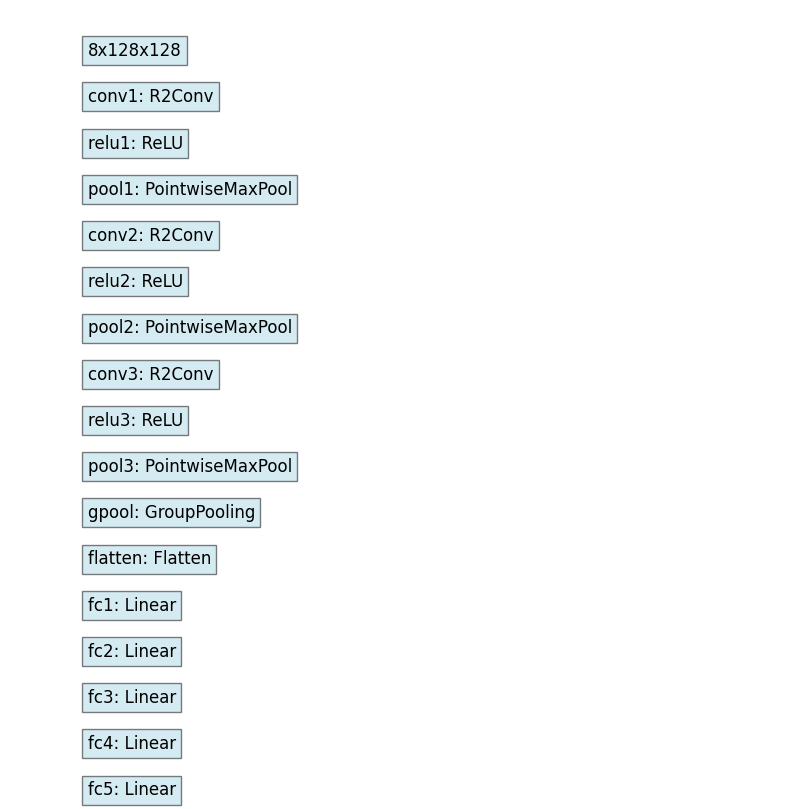

In [45]:
#Plotting the model:

layers = []
for lname, layer in model.named_children():
    layers.append(f"{lname}: {layer.__class__.__name__}")


plt.figure(figsize=(10, 6))
plt.text(0.1, 0.9, f'{nch}x{npix}x{npix}', fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

for i in range(len(layers)):
    layer = layers[i]
    plt.text(0.1, 0.9 - (i+1) * 0.1, layer, fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

plt.axis('off')
#plt.title('CNN Architecture', fontsize=16)
#plt.savefig('/content/drive/MyDrive/TNG-data/graphs/Architecture_E2CNN' + name + '_new.pdf')



In [46]:
# Create DataLoaders for training/validation
train_dataset = CustomDataset(x_trainset, y_trainset)
val_dataset   = CustomDataset(x_valset, y_valset)
test_dataset  = CustomDataset(x_testset, y_testset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [47]:
input_shape = (nch, npix, npix)
print(input_shape)

(8, 128, 128)


In [48]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
device

device(type='cuda')

In [50]:
criterion= nn.MSELoss()

In [51]:
!ls drive/MyDrive/TNG/TNG-data

graphs	models	new-models  predictions


In [52]:
models_names = glob.glob(os.path.join('/content/drive/MyDrive/data_TNG/models/', 'best_model_' + name + '*' ))

In [53]:
model = EquivariantConvNet(input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction).to(device)

In [54]:
repeated_ids = np.repeat(test_ind.flatten(), 20)
repeated_ids.flatten().size

5960

In [55]:
M_pred_list = []
test_loss_list = []
for i in range(0,20):
    best_model_path = 'drive/MyDrive/TNG/TNG-data/models/best_model_' + name + '_' + str(i) + '_new.pth'

    model.load_state_dict(torch.load(best_model_path))

    model.eval()
    y_predicted = []  # List for the prediction of one model

    # no gradient estimation needed during inference
    with torch.no_grad():
        test_loss = 0
        for inputs, true_vals in test_loader:  #

            inputs = inputs.to(device)
            true_vals = true_vals.to(device)
            # predictions
            outputs = model(inputs)
            #print(outputs.shape)

            y_predicted.append(outputs.detach().cpu().numpy())  #

            test_loss += criterion(outputs, true_vals)

    test_loss = test_loss / len(test_loader)
    print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
    test_loss_list.append(test_loss)

    # Convertir la lista de predicciones en un solo array
    y_predicted = np.concatenate(y_predicted, axis=0)

    print(y_predicted.shape)  # Esto te dará la forma de las predicciones

    M_pred = 10**(y_predicted * (max_y - min_y) + min_y)
    M_real = 10**(y_testset * (max_y - min_y) + min_y)

    repeated_ids = (np.repeat(test_ind.flatten(), 20)).flatten()
    # Combine and save
    combined = np.column_stack((repeated_ids, M_pred.flatten(), M_real.flatten()))
    #np.savez(f'/content/drive/MyDrive/TNG-data/predictions/M_pred_E2CNN_model_{i}.npz', galaxy_id=repeated_ids, predicted_mass=M_pred, real_mass=M_real)



    mass_quantiles = np.percentile((M_pred / M_real), [25, 50, 75], axis=0)
    M_pred_list.append(M_pred)

Test Loss = 0.006494623608887196
(298, 20)
Test Loss = 0.005943405441939831
(298, 20)
Test Loss = 0.00634265411645174
(298, 20)
Test Loss = 0.006464493460953236
(298, 20)
Test Loss = 0.006026057526469231
(298, 20)
Test Loss = 0.006115309428423643
(298, 20)
Test Loss = 0.00621781637892127
(298, 20)
Test Loss = 0.0060472795739769936
(298, 20)
Test Loss = 0.006202262360602617
(298, 20)
Test Loss = 0.005776855628937483
(298, 20)
Test Loss = 0.005975018255412579
(298, 20)
Test Loss = 0.0064629861153662205
(298, 20)
Test Loss = 0.0066981129348278046
(298, 20)
Test Loss = 0.006164882332086563
(298, 20)
Test Loss = 0.006103172432631254
(298, 20)
Test Loss = 0.007532923948019743
(298, 20)
Test Loss = 0.006685660686343908
(298, 20)
Test Loss = 0.005595759488642216
(298, 20)
Test Loss = 0.006168206688016653
(298, 20)
Test Loss = 0.006166250444948673
(298, 20)


In [56]:
y_predicted_from_stellar = np.zeros((test_size, 20))
y_predicted_from_stellar_std = np.zeros((test_size, 20))
for i in range(test_size):
    dm_aux, dm_std = dm_from_stellar(labels[test_ind[i],1,:],num_smass_bins = 10)
    y_predicted_from_stellar[i,:] = dm_aux
    y_predicted_from_stellar_std[i,:] = dm_std

In [57]:
y_predicted_random = np.random.uniform(0,1, size=(298,20))
M_pred_random = 10**(y_predicted_random * (max_y - min_y) + min_y)

In [58]:
y_prior = (dm_prior_profile - min_y) / (max_y - min_y)
y_prior = np.tile(y_prior, (test_size, 1))

M_prior = 10**(y_prior * (max_y - min_y) + min_y)

In [59]:
if len(M_pred_list) > 1:
    M_pred_list = np.asarray(M_pred_list)
    M_pred = np.mean(M_pred_list, axis = 0)
    M_pred_std = np.std(M_pred_list, axis = 0)
    y_predicted = (np.log10(M_pred) - min_y) / (max_y - min_y)
else:
    M_pred_std = None

Text(0, 0.5, '[M(<R) - m] / (M-m)')

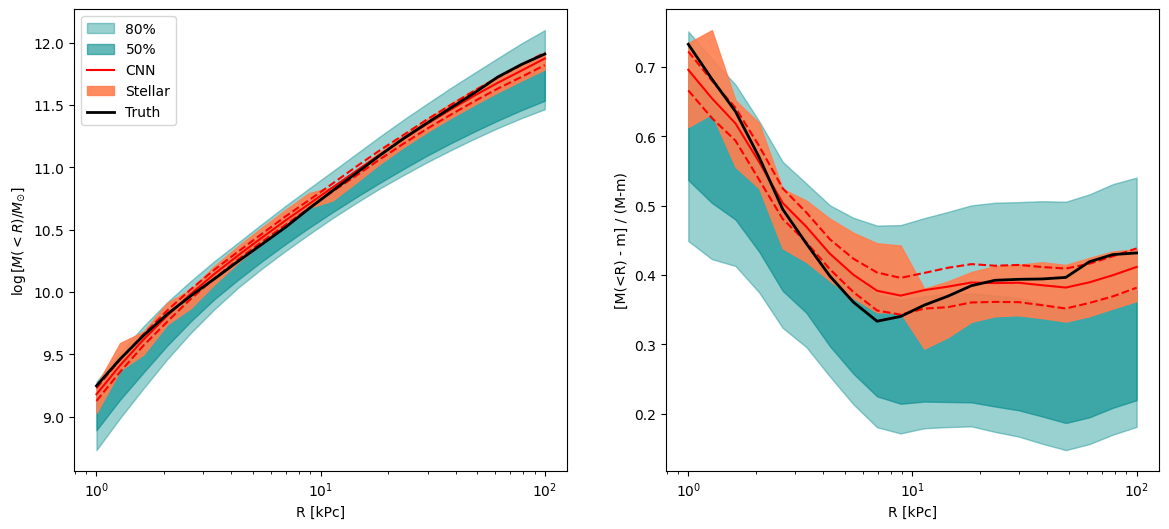

In [60]:
i = np.random.randint(len(y_predicted))

fig,ax = plt.subplots(1,2, sharex = True, figsize = (14,6))

#ax[0].fill_between(R_bins, max_y, min_y, color = 'darkcyan', alpha = 0.2)
ax[0].fill_between(R_bins, (dm_quantiles[0,:]), (dm_quantiles[3,:]), color = 'darkcyan', alpha = 0.4, label = '80%' )
ax[0].fill_between(R_bins, (dm_quantiles[1,:]), (dm_quantiles[2,:]), color = 'darkcyan', alpha = 0.6, label = '50%' )
#ax[0].fill_between(R_bins, 10**(dm_prior_profile + dm_prior_profile_std), 10**(dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)

ax[0].plot(R_bins, (np.log10(M_pred[i,:])), c = 'red', label = 'CNN')
if M_pred_std is not None:
    ax[0].plot(R_bins, (np.log10(M_pred[i,:] + M_pred_std[i,:])), c = 'red', ls = '--')
    ax[0].plot(R_bins, (np.log10(M_pred[i,:] - M_pred_std[i,:])), c = 'red', ls = '--')

#ax[0].plot(R_bins, 10**y_predicted_from_stellar[i,:], color = 'coral')
ax[0].fill_between(R_bins, ((y_predicted_from_stellar[i,:] + y_predicted_from_stellar_std[i,:])),
                 ((y_predicted_from_stellar[i,:] - y_predicted_from_stellar_std[i,:])), color = 'coral', alpha = 0.9, label = 'Stellar')

ax[0].plot(R_bins, (np.log10(M_real[i,:])), c = 'black', lw = 2, label = 'Truth')
ax[0].legend()
ax[0].set_xlabel('R [kPc]')
ax[0].set_ylabel('$\log{[M(<R) / M_{\odot}]}$')


#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('R [kPc]')
ax[1].set_ylabel('[M(<R) - m] / (M-m)')

#ax[1].fill_between(R_bins, max_y, min_y, color = 'darkcyan', alpha = 0.2)
ax[1].fill_between(R_bins, (dm_quantiles[0,:] - min_y) / (max_y - min_y), (dm_quantiles[3,:] - min_y) / (max_y - min_y), color = 'darkcyan', alpha = 0.4, label = '80%' )
ax[1].fill_between(R_bins, (dm_quantiles[1,:] - min_y) / (max_y - min_y), (dm_quantiles[2,:] - min_y) / (max_y - min_y), color = 'darkcyan', alpha = 0.6, label = '50%' )
#ax[1].fill_between(R_bins, 10**(dm_prior_profile + dm_prior_profile_std), 10**(dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)

ax[1].plot(R_bins, (np.log10(M_pred[i,:]) - min_y) / (max_y - min_y), c = 'red', label = 'E2CNN')
if M_pred_std is not None:
    ax[1].plot(R_bins, (np.log10(M_pred[i,:] + M_pred_std[i,:]) - min_y) / (max_y - min_y), c = 'red', ls = '--')
    ax[1].plot(R_bins, (np.log10(M_pred[i,:] - M_pred_std[i,:]) - min_y) / (max_y - min_y), c = 'red', ls = '--')

#ax[1].plot(R_bins, 10**y_predicted_from_stellar[i,:], color = 'coral')
ax[1].fill_between(R_bins, ((y_predicted_from_stellar[i,:] + y_predicted_from_stellar_std[i,:]) - min_y) / (max_y - min_y),
                 ((y_predicted_from_stellar[i,:] - y_predicted_from_stellar_std[i,:]) - min_y) / (max_y - min_y), color = 'coral', alpha = 0.9, label = 'E2CNN-Stellar')

ax[1].plot(R_bins, (np.log10(M_real[i,:]) - min_y) / (max_y - min_y), c = 'black', lw =2)

#ax[1].yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('R [kPc]')
ax[1].set_ylabel('[M(<R) - m] / (M-m)')

#plt.savefig('/content/drive/MyDrive/TNG-data/graphs/DMfromStellar_' + str(properties[test_ind[i],0]) + '_' + name + 'GPUE2CNN.pdf')

Text(0, 0.5, '[M(<R) - m] / (M-m)')

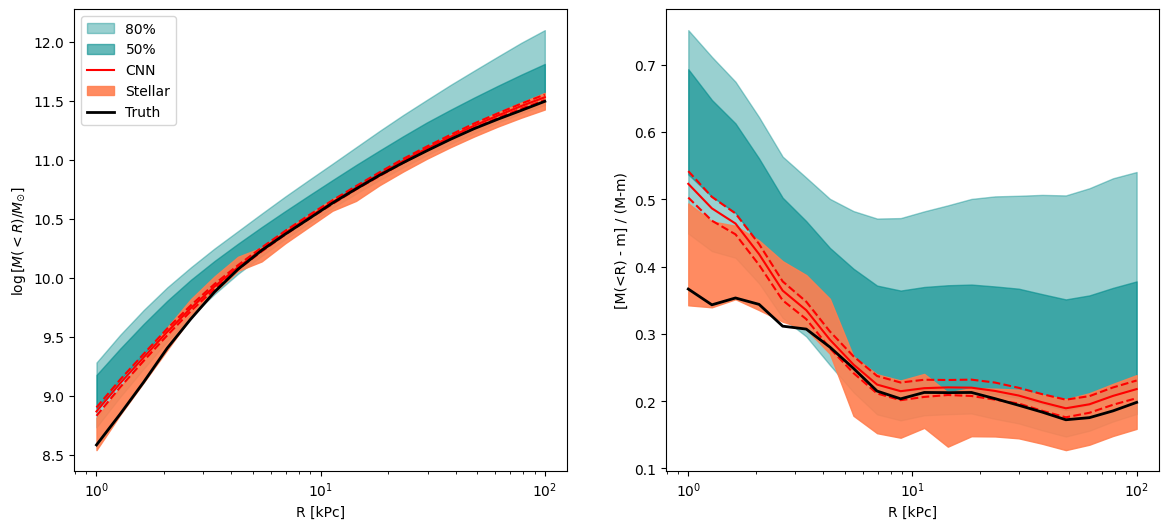

In [61]:
i = np.random.randint(len(y_predicted))

fig,ax = plt.subplots(1,2, sharex = True, figsize = (14,6))

#ax[0].fill_between(R_bins, max_y, min_y, color = 'darkcyan', alpha = 0.2)
ax[0].fill_between(R_bins, (dm_quantiles[0,:]), (dm_quantiles[3,:]), color = 'darkcyan', alpha = 0.4, label = '80%' )
ax[0].fill_between(R_bins, (dm_quantiles[1,:]), (dm_quantiles[2,:]), color = 'darkcyan', alpha = 0.6, label = '50%' )
#ax[0].fill_between(R_bins, 10**(dm_prior_profile + dm_prior_profile_std), 10**(dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)

ax[0].plot(R_bins, (np.log10(M_pred[i,:])), c = 'red', label = 'CNN')
if M_pred_std is not None:
    ax[0].plot(R_bins, (np.log10(M_pred[i,:] + M_pred_std[i,:])), c = 'red', ls = '--')
    ax[0].plot(R_bins, (np.log10(M_pred[i,:] - M_pred_std[i,:])), c = 'red', ls = '--')

#ax[0].plot(R_bins, 10**y_predicted_from_stellar[i,:], color = 'coral')
ax[0].fill_between(R_bins, ((y_predicted_from_stellar[i,:] + y_predicted_from_stellar_std[i,:])),
                 ((y_predicted_from_stellar[i,:] - y_predicted_from_stellar_std[i,:])), color = 'coral', alpha = 0.9, label = 'Stellar')

ax[0].plot(R_bins, (np.log10(M_real[i,:])), c = 'black', lw = 2, label = 'Truth')
ax[0].legend()
ax[0].set_xlabel('R [kPc]')
ax[0].set_ylabel('$\log{[M(<R) / M_{\odot}]}$')


#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('R [kPc]')
ax[1].set_ylabel('[M(<R) - m] / (M-m)')

#ax[1].fill_between(R_bins, max_y, min_y, color = 'darkcyan', alpha = 0.2)
ax[1].fill_between(R_bins, (dm_quantiles[0,:] - min_y) / (max_y - min_y), (dm_quantiles[3,:] - min_y) / (max_y - min_y), color = 'darkcyan', alpha = 0.4, label = '80%' )
ax[1].fill_between(R_bins, (dm_quantiles[1,:] - min_y) / (max_y - min_y), (dm_quantiles[2,:] - min_y) / (max_y - min_y), color = 'darkcyan', alpha = 0.6, label = '50%' )
#ax[1].fill_between(R_bins, 10**(dm_prior_profile + dm_prior_profile_std), 10**(dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)

ax[1].plot(R_bins, (np.log10(M_pred[i,:]) - min_y) / (max_y - min_y), c = 'red', label = 'E2CNN')
if M_pred_std is not None:
    ax[1].plot(R_bins, (np.log10(M_pred[i,:] + M_pred_std[i,:]) - min_y) / (max_y - min_y), c = 'red', ls = '--')
    ax[1].plot(R_bins, (np.log10(M_pred[i,:] - M_pred_std[i,:]) - min_y) / (max_y - min_y), c = 'red', ls = '--')

#ax[1].plot(R_bins, 10**y_predicted_from_stellar[i,:], color = 'coral')
ax[1].fill_between(R_bins, ((y_predicted_from_stellar[i,:] + y_predicted_from_stellar_std[i,:]) - min_y) / (max_y - min_y),
                 ((y_predicted_from_stellar[i,:] - y_predicted_from_stellar_std[i,:]) - min_y) / (max_y - min_y), color = 'coral', alpha = 0.9, label = 'E2CNN-Stellar')

ax[1].plot(R_bins, (np.log10(M_real[i,:]) - min_y) / (max_y - min_y), c = 'black', lw =2)

#ax[1].yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('R [kPc]')
ax[1].set_ylabel('[M(<R) - m] / (M-m)')

#plt.savefig('/content/drive/MyDrive/TNG-data/graphs/DMfromStellar_' + str(properties[test_ind[i],0]) + '_' + name + 'GPUE2CNN.pdf')

Text(0.5, 0.0, '$Mass$')

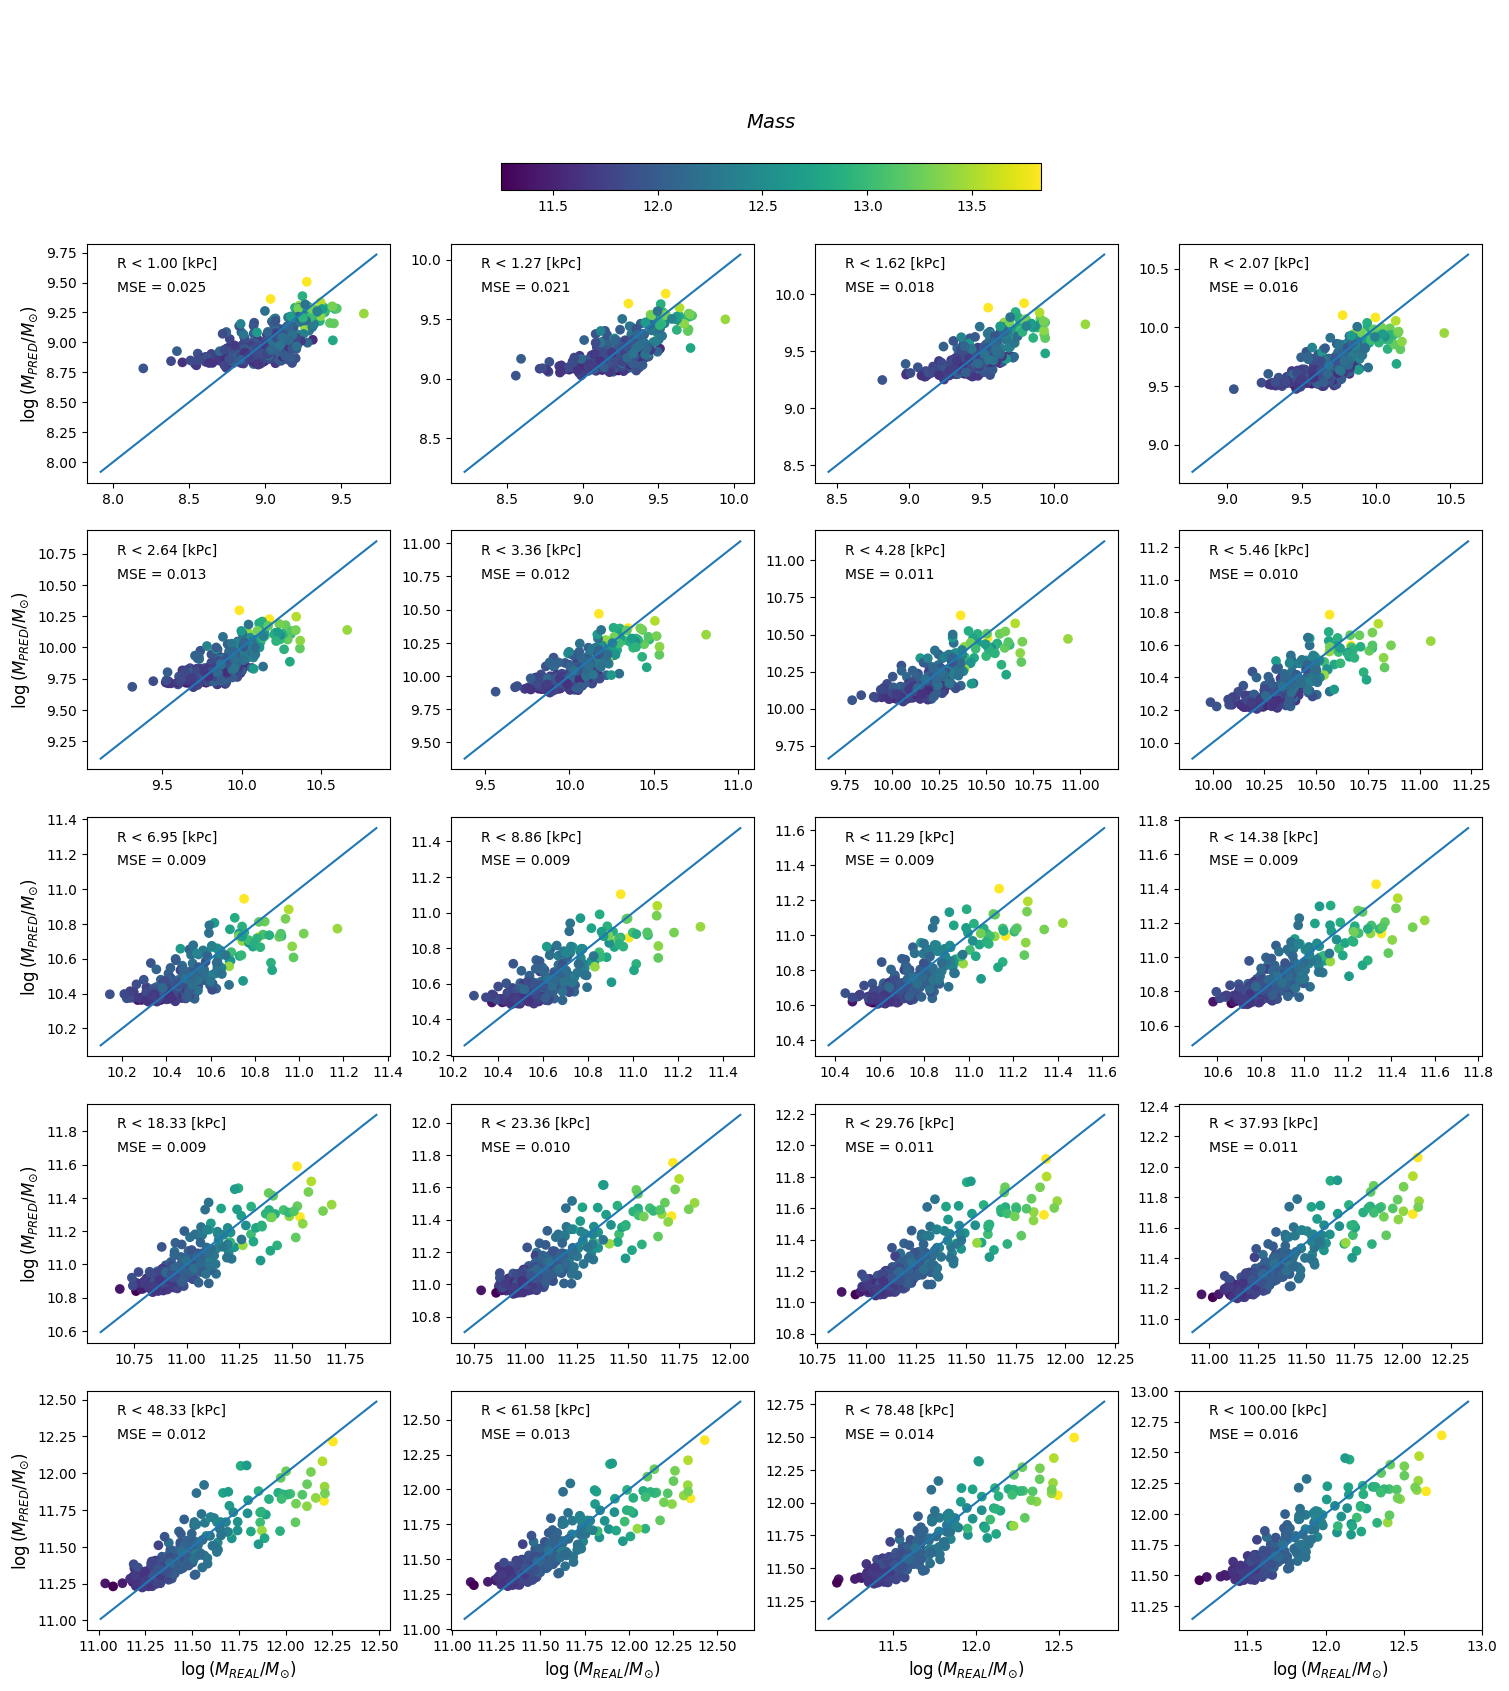

In [62]:
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):

        s = ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]), c = np.log10(properties[test_ind,2]), cmap = 'viridis',
                            vmin = np.log10(properties[test_ind,2]).min(), vmax = np.log10(properties[test_ind,2]).max())
        ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

        if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
        if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

        ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)

cbar_ax = fig.add_axes([0.1, 0.91, 0.81, 0.1])
cbar_ax.axis('off')
plt.colorbar(s, ax = cbar_ax, orientation = 'horizontal')
cbar_ax.set_title('$Mass$', y = 0., fontsize = 14)
#plt.savefig('drive/MyDrive/TNG/graphs/RealVSPred_' + name + '_Mass_newE2CNN_original.pdf')

In [63]:
outliers_testset= [ 40, 106, 127, 143, 164, 275, 277]

Text(0, 0.5, '$M_{Pr} / M_{Re}$')

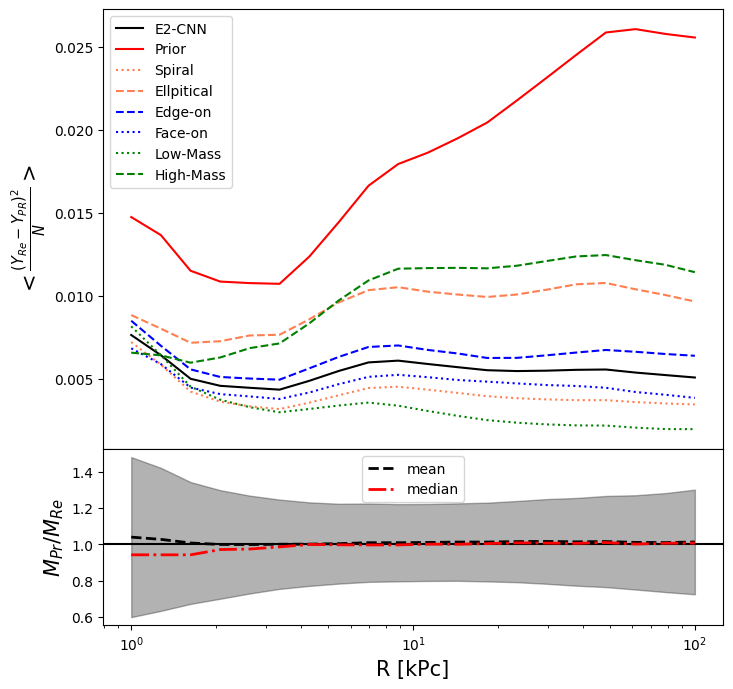

In [64]:
fig,ax = plt.subplots(2,1, figsize = (8,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

mse = mean_squared_error(y_testset, y_predicted, multioutput = 'raw_values') # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std = np.std((y_testset - y_predicted)**2, axis = 0)
mse_prior = mean_squared_error(y_testset, y_prior, multioutput = 'raw_values')

#for i in range(test_size):
#    ax[0].plot(R_bins, np.abs(y_testset[i,:] - y_predicted[i,:]), alpha = 0.2, c = 'black')

ax[0].plot(R_bins, mse, color = 'black', label = 'E2-CNN')
#ax[0].plot(R_bins, mse_random, color = 'coral', label = 'Random')
#ax[0].fill_between(R_bins, mse + std, mse - std, color = 'coral', alpha = 0.3)

ax[0].plot(R_bins, mse_prior, color = 'red', label = 'Prior')
#ax[0].plot(arqB_8ch[:,0], arqB_8ch[:,1], color = 'red', label = 'Arch. B')

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]
mse_aux = mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values') # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0)
ax[0].plot(R_bins, mse_aux, color = 'coral', ls = ':', label = 'Spiral')

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
mse_aux = mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values') # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0)
ax[0].plot(R_bins, mse_aux, color = 'coral', ls = '--', label = 'Ellpitical')
# ------------------------------------

# Theta splitting
ind_aux = np.where( (properties[test_ind, 18] > (np.pi/4)) & (properties[test_ind, 18] < (3*np.pi/4)))[0]
mse_aux = mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values') # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0)
ax[0].plot(R_bins, mse_aux, color = 'blue', ls = '--', label = 'Edge-on')

ind_aux = np.where( (properties[test_ind, 18] < (np.pi/4)) | (properties[test_ind, 18] > (3*np.pi/4)))[0]
mse_aux = mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values') # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0)
ax[0].plot(R_bins, mse_aux, color = 'blue', ls = ':', label = 'Face-on')
# --------------------------------


# Mass splitting
ind_aux = np.where(np.log10(properties[test_ind, 2]) < np.log10(properties[test_ind,2]).mean())[0]
mse_aux = mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values') # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0)
ax[0].plot(R_bins, mse_aux, color = 'green', ls = ':', label = 'Low-Mass')

ind_aux = np.where(np.log10(properties[test_ind, 2]) > np.log10(properties[test_ind,2]).mean())[0]
mse_aux = mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values') # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0)
ax[0].plot(R_bins, mse_aux, color = 'green', ls = '--', label = 'High-Mass')
# --------------------------------

ax[0].set_ylabel('$ <\\frac{(Y_{Re} - Y_{PR})^2}{N}> $', fontsize = 15)
#ax[0].set_xlabel('R [kPc]')
ax[0].set_xscale('log')
ax[0].legend()

mean_mass_ratio = np.mean(M_pred / M_real, axis = 0)
median_mass_ratio= np.median(M_pred / M_real, axis = 0)
std_mass_ratio = np.std(M_pred / M_real, axis = 0)
mean_mass_ratio_random = np.mean(M_pred_random / M_real, axis = 0)

std_mass_ratio_random = np.std(M_pred_random / M_real, axis = 0)

#for i in range(test_size):
    #ax[1].plot(R_bins, M_pred[i,:] / M_real[i,:], color = 'black', alpha = 0.05)
ax[1].axhline(y = 1, color = 'black')
ax[1].plot(R_bins, mean_mass_ratio, color = 'black', lw = 2, ls = '--', label='mean')
ax[1].plot(R_bins, median_mass_ratio, color = 'red', lw = 2, ls = '-.', label='median')
ax[1].fill_between(R_bins, mean_mass_ratio + std_mass_ratio, mean_mass_ratio - std_mass_ratio, color = 'black', alpha = 0.3)
ax[1].legend()

#ax[1].fill_between(R_bins, mean_mass_ratio_random + std_mass_ratio_random, mean_mass_ratio_random - std_mass_ratio_random, color = 'red', alpha = 0.3)

#ax[1].plot(R_bins, mass_quantiles[2,:], color = 'black', lw = 2, ls = '--')

ax[1].set_xlabel('R [kPc]', fontsize = 15)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

#plt.savefig('drive/MyDrive/TNG/graphs/MSE_' + name + '_E2CNN_latest.pdf')

Text(0, 0.5, '$M_{Pr} / M_{Re}$')

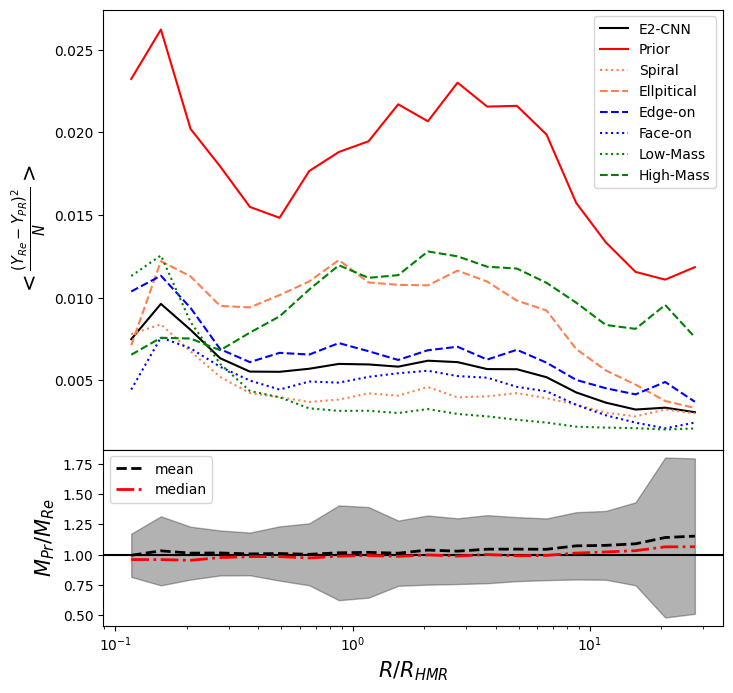

In [65]:
y_stellar = (y_predicted_from_stellar - min_y) / (max_y - min_y)
#y_stellar1 = (y_predicted_from_stellar1 - min_y) / (max_y - min_y)
r = np.zeros_like(y_predicted)
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]


fig,ax = plt.subplots(2,1, figsize = (8,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (y_predicted - y_testset)**2)
_,_, mse_prior, _, _, _, _, _, _ = binned_MSE(r, (y_prior - y_testset)**2, bins = bins)

ax[0].plot(bin_centers, mse, color = 'black', label = 'E2-CNN')

ax[0].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]
_, _, mse_aux, std_aux, _, _, _, _, _ = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'coral', ls = ':', label = 'Spiral')

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
_, _, mse_aux, std_aux, _, _, _, _, _ = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'coral', ls = '--', label = 'Ellpitical')
# ------------------------------------

# Theta splitting
ind_aux = np.where( (properties[test_ind, 18] > (np.pi/4)) & (properties[test_ind, 18] < (3*np.pi/4)))[0]
_, _, mse_aux, std_aux, _, _, _, _, _ = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'blue', ls = '--', label = 'Edge-on')

ind_aux = np.where( (properties[test_ind, 18] < (np.pi/4)) | (properties[test_ind, 18] > (3*np.pi/4)))[0]
_, _, mse_aux, std_aux, _, _, _, _, _ = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'blue', ls = ':', label = 'Face-on')
# --------------------------------


# Mass splitting
ind_aux = np.where(np.log10(properties[test_ind, 2]) < np.log10(properties[test_ind,2]).mean())[0]
_, _, mse_aux, std_aux, _, _, _, _, _ = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'green', ls = ':', label = 'Low-Mass')

ind_aux = np.where(np.log10(properties[test_ind, 2]) > np.log10(properties[test_ind,2]).mean())[0]
_, _, mse_aux, std_aux, _, _, _, _, _ = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'green', ls = '--', label = 'High-Mass')
# --------------------------------

ax[0].set_ylabel('$ <\\frac{(Y_{Re} - Y_{PR})^2}{N}> $', fontsize = 15)
ax[0].set_xscale('log')
ax[0].legend()


_,_, mean_mass_ratio, std_mass_ratio, p10, p16, median_mass_ratio, p84, p90 = binned_MSE(r, y_predicted / y_testset)
ax[1].axhline(y = 1, color = 'black')
ax[1].plot(bin_centers, mean_mass_ratio, color = 'black', lw = 2, ls = '--', label='mean')
ax[1].plot(bin_centers, median_mass_ratio, color = 'red', lw = 2, ls = '-.', label='median')
ax[1].fill_between(bin_centers, mean_mass_ratio + std_mass_ratio, mean_mass_ratio - std_mass_ratio, color = 'black', alpha = 0.3)
ax[1].legend()

ax[1].set_xlabel('$R / R_{HMR}$', fontsize = 15)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

#plt.savefig('drive/MyDrive/TNG/graphs/MSENormalized_' + name + '_E2CNN_latest.pdf')

In [66]:
#quantiles = np.percentile((y_testset - y_predicted)**2, [25, 50, 75], axis=0)
quantiles = np.percentile((y_testset- y_predicted)**2, [25, 50, 75, 90], axis=0)

In [67]:
mse_mean = mean_squared_error(y_testset, y_predicted, multioutput = 'raw_values')

print(mse_mean)

mse_median= quantiles[1,:]

print(mse_median)
print(quantiles[2,:])
print(quantiles[3,:])



[0.0076 0.0064 0.005  0.0046 0.0045 0.0044 0.0049 0.0055 0.006  0.0061 0.0059 0.0057 0.0055 0.0055
 0.0055 0.0055 0.0056 0.0054 0.0052 0.0051]
[0.0031 0.0027 0.0021 0.002  0.0014 0.0013 0.0013 0.0017 0.0021 0.002  0.0018 0.0019 0.0016 0.0014
 0.0014 0.0013 0.0014 0.0012 0.0012 0.0012]
[0.0101 0.0081 0.0067 0.0056 0.0049 0.0048 0.0053 0.0057 0.0061 0.006  0.0058 0.0056 0.0056 0.0051
 0.0049 0.0047 0.0044 0.0043 0.0043 0.004 ]
[0.0205 0.0151 0.0112 0.0119 0.011  0.0107 0.012  0.0134 0.0155 0.0157 0.015  0.014  0.0134 0.0141
 0.015  0.0151 0.0144 0.0137 0.0143 0.0136]


(0.001, 0.1)

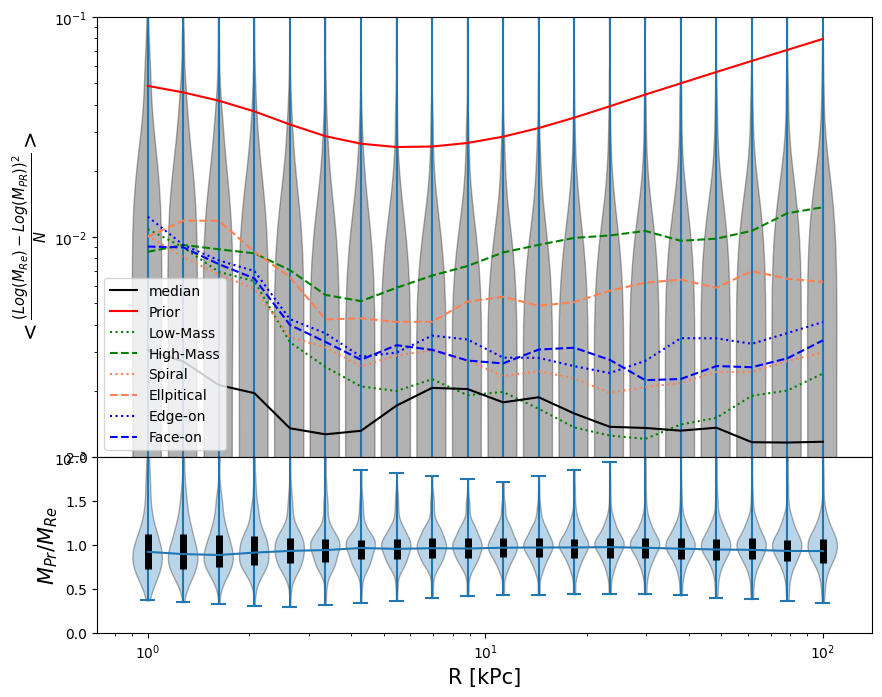

In [68]:
fig,ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

#parts = ax[0].violinplot((y_testset - y_predicted)**2, positions=R_bins, widths=R_bins*0.2, showmedians = True)
parts = ax[0].violinplot((np.log10(M_real) - np.log10(M_pred))**2, positions=R_bins, widths=R_bins*0.2, showmedians = False)
for pc in parts['bodies']:
    pc.set_facecolor('black')  # Color azul
    pc.set_edgecolor('black')
    pc.set_alpha(0.3)

ax[0].plot(R_bins, quantiles[1,:], zorder=4, color = 'black', label='median')
#ax[0].plot(R_bins, mean_squared_error(np.log10(M_real), np.log10(M_pred), multioutput = 'raw_values'), color = 'coral', label = 'CNN')
#%ax[0].plot(R_bins, mse**2, color = 'coral', label = 'New')

#ax[0].vlines(R_bins, quantiles[0,:], quantiles[2,:], color='k', linestyle='-', lw=5)
#ax[0].plot(R_bins, np.sqrt(quantiles[0,:]), color = '#1f77b4' , zorder=4)
#ax[0].plot(R_bins, np.sqrt(quantiles[2,:]), color = '#1f77b4' , zorder=4)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].plot(R_bins, mse/mse_prior, color = 'red')
#%ax[0].plot(R_bins, mse_prior**2, color = 'red', label = 'Prior')
ax[0].plot(R_bins, mean_squared_error(np.log10(M_real), np.log10(M_prior), multioutput = 'raw_values'), color = 'red', label = 'Prior')
#ax[0].fill_between(R_bins, mse + std, mse - std, color = 'red', alpha = 0.3)
#ax[0].set_ylim(0,0.03)
#ax[0].plot(arqB_8ch[:,0], arqB_8ch[:,1], color = 'red')
ax[0].set_ylabel('$<\\frac{(Log(M_{Re}) - Log(M_{PR}))^2}{N}>$', fontsize = 15)

parts1 = ax[1].violinplot((M_pred / M_real), positions=R_bins, widths=R_bins*0.2)
for pc in parts1['bodies']:
    pc.set_facecolor('#1f77b4')  # Color azul
    pc.set_edgecolor('black')
    pc.set_alpha(0.3)

ax[1].plot(R_bins, mass_quantiles[1,:], color = '#1f77b4' , zorder=4, label='median') #median
ax[1].vlines(R_bins, mass_quantiles[0,:], mass_quantiles[2,:], color='k', linestyle='-', lw=5)
ax[1].set_ylim(0,2)
ax[1].set_xlabel('R [kPc]', fontsize = 15)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

# Mass splitting
ind_aux = np.where(np.log10(properties[test_ind, 2]) < np.log10(properties[test_ind,2]).mean())[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'green', ls = ':', label = 'Low-Mass')

ind_aux = np.where(np.log10(properties[test_ind, 2]) > np.log10(properties[test_ind,2]).mean())[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'green', ls = '--', label = 'High-Mass')
# --------------------------------

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'coral', ls = ':', label = 'Spiral')

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'coral', ls = '--', label = 'Ellpitical')
# ------------------------------------

# Theta splitting
ind_aux = np.where( (properties[test_ind, 18] > (np.pi/4)) & (properties[test_ind, 18] < (3*np.pi/4)))[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'blue', ls = ':', label = 'Edge-on')

ind_aux = np.where( (properties[test_ind, 18] < (np.pi/4)) | (properties[test_ind, 18] > (3*np.pi/4)))[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'blue', ls = '--', label = 'Face-on')
# --------------------------------

ax[0].legend()
ax[0].set_ylim(1e-3,1e-1)
#plt.savefig('drive/MyDrive/TNG/graphs/MSE_v2_' + name + '_E2CNN_latest.pdf')

In [69]:
M_prior

array([[1.0513e+09, 1.8178e+09, 3.0267e+09, ..., 3.4757e+11, 4.2891e+11, 5.2273e+11],
       [1.0513e+09, 1.8178e+09, 3.0267e+09, ..., 3.4757e+11, 4.2891e+11, 5.2273e+11],
       [1.0513e+09, 1.8178e+09, 3.0267e+09, ..., 3.4757e+11, 4.2891e+11, 5.2273e+11],
       ...,
       [1.0513e+09, 1.8178e+09, 3.0267e+09, ..., 3.4757e+11, 4.2891e+11, 5.2273e+11],
       [1.0513e+09, 1.8178e+09, 3.0267e+09, ..., 3.4757e+11, 4.2891e+11, 5.2273e+11],
       [1.0513e+09, 1.8178e+09, 3.0267e+09, ..., 3.4757e+11, 4.2891e+11, 5.2273e+11]])

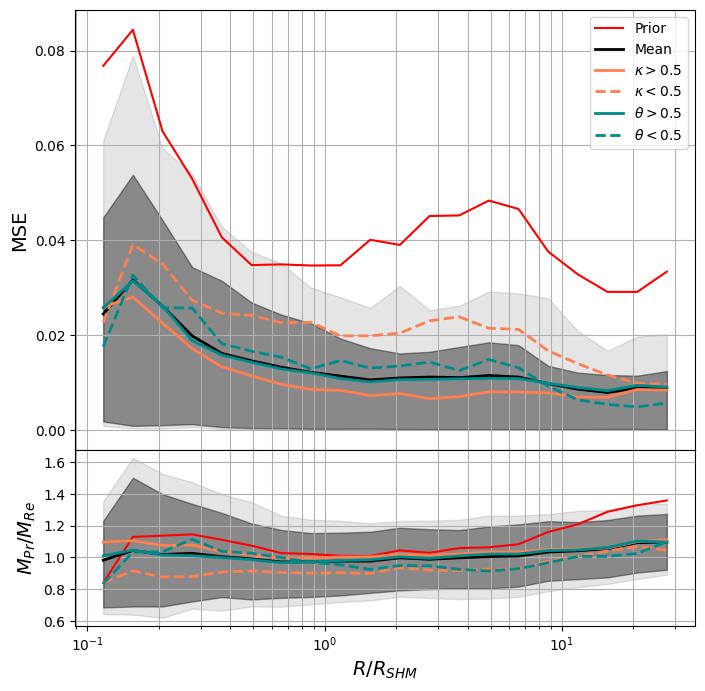

In [70]:
y_stellar = (y_predicted_from_stellar - min_y) / (max_y - min_y)
#y_stellar1 = (y_predicted_from_stellar1 - min_y) / (max_y - min_y)
r = np.zeros_like(y_predicted)
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]

fig,ax = plt.subplots(2,1, figsize = (8,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)


bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (np.log10(M_pred) - np.log10(M_real))**2)
#_, _, mse_stellar, std_stellar, p10_stellar, p16_stellar, p50_stellar, p84_stellar, p90_stellar = binned_MSE(r, (y_stellar - y_testset)**2, bins = bins)
_, _, mse_prior, _, _, _, _, _, _ = binned_MSE(r, (np.log10(M_prior) - np.log10(M_real))**2, bins = bins)

ax[0].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')

ax[0].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
ax[0].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
ax[0].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
#ax[0].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

#ax[0].plot(bin_centers, mse_stellar, color = 'magenta', label = 'From Stellar', lw = 2)
#_, _, mse_stellar, std_stellar, p10_stellar, p16_stellar, p50_stellar, p84_stellar, p90_stellar = binned_MSE(r, (y_stellar1 - y_testset)**2, bins = bins)
#ax[0].plot(bin_centers, mse_stellar, color = 'magenta', label = 'From Stellar w 1% error', lw = 2, ls = ':')
#ax[0].fill_between(bin_centers, p10_stellar, p90_stellar, color = 'magenta', alpha = 0.1)
#ax[0].fill_between(bin_centers, p16_stellar, p84_stellar, color = 'magenta', alpha = 0.4)

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]

_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], (np.log10(M_pred[ind_aux]) - np.log10(M_real[ind_aux]))**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'coral', ls = 'solid', label = '$\\kappa > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], (np.log10(M_pred[ind_aux]) - np.log10(M_real[ind_aux]))**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'coral', ls = '--', label = '$\\kappa < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

# theta splitting
ind_aux = np.where(properties[test_ind, 18] > 0.5)[0]

_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], (np.log10(M_pred[ind_aux]) - np.log10(M_real[ind_aux]))**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'darkcyan', ls = 'solid', label = '$\\theta > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 18] < 0.5)[0]
_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], (np.log10(M_pred[ind_aux]) - np.log10(M_real[ind_aux]))**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'darkcyan', ls = '--', label = '$\\theta < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_ylabel('MSE', fontsize = 14)

_, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, M_pred / M_real, bins = bins)
#_, _, ratio_stellar, std_stellar, p10_stellar, p16_stellar, p50_stellar, p84_stellar, p90_stellar = binned_MSE(r, y_stellar / y_testset, bins = bins)
_, _, ratio_prior, _, _, _, _, _, _ = binned_MSE(r, M_prior / M_real, bins = bins)

ax[1].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior')

ax[1].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
ax[1].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
ax[1].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
#ax[1].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

#ax[1].plot(bin_centers, ratio_stellar, color = 'magenta', lw = 2)
#_, _, ratio_stellar, std_stellar, p10_stellar, p16_stellar, p50_stellar, p84_stellar, p90_stellar = binned_MSE(r, y_stellar1 / y_testset, bins = bins)
#ax[1].plot(bin_centers, ratio_stellar, color = 'magenta', lw = 2, ls = ':')
#ax[1].fill_between(bin_centers, p10_stellar, p90_stellar, color = 'magenta', alpha = 0.1)
#ax[1].fill_between(bin_centers, p16_stellar, p84_stellar, color = 'magenta', alpha = 0.4)

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]

_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], M_pred[ind_aux] / M_real[ind_aux], bins = bins)
ax[1].plot(bin_centers, mse_aux, color = 'coral', ls = 'solid', label = '$\\kappa > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], M_pred[ind_aux] / M_real[ind_aux], bins = bins)
ax[1].plot(bin_centers, mse_aux, color = 'coral', ls = '--', label = '$\\kappa < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

# theta splitting
ind_aux = np.where(properties[test_ind, 18] > 0.5)[0]

_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], M_pred[ind_aux] / M_real[ind_aux], bins = bins)
ax[1].plot(bin_centers, mse_aux, color = 'darkcyan', ls = 'solid', label = '$\\theta > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 18] < 0.5)[0]
_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], M_pred[ind_aux] / M_real[ind_aux], bins = bins)
ax[1].plot(bin_centers, mse_aux, color = 'darkcyan', ls = '--', label = '$\\theta < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

#_, _, mse_ecnn, std_ecnn, p10_ecnn, p16_ecnn, p50_ecnn, p84_ecnn, p90_ecnn = binned_MSE(r, (ecnn_y_pred - y_testset)**2)
#ax[0].plot(bin_centers, mse_ecnn, color = 'yellow', label = 'ECNN',zorder = 20)
#ax[0].fill_between(bin_centers, p10_ecnn, p90_ecnn, color = 'yellow', alpha = 0.1)
#ax[0].fill_between(bin_centers, p16_ecnn, p84_ecnn, color = 'yellow', alpha = 0.4)

#_, _, mse_ecnn, std_ecnn, p10_ecnn, p16_ecnn, p50_ecnn, p84_ecnn, p90_ecnn = binned_MSE(r, (ecnn_y_pred / y_testset))
#ax[1].plot(bin_centers, mse_ecnn, color = 'yellow', zorder = 20)
#ax[1].fill_between(bin_centers, p10_ecnn, p90_ecnn, color = 'yellow', alpha = 0.1)
#ax[1].fill_between(bin_centers, p16_ecnn, p84_ecnn, color = 'yellow', alpha = 0.4)

ax[1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')

#plt.savefig('drive/MyDrive/TNG/graphs/NormalizedMSE_' + name + '_E2CNN_latest_mass.pdf')

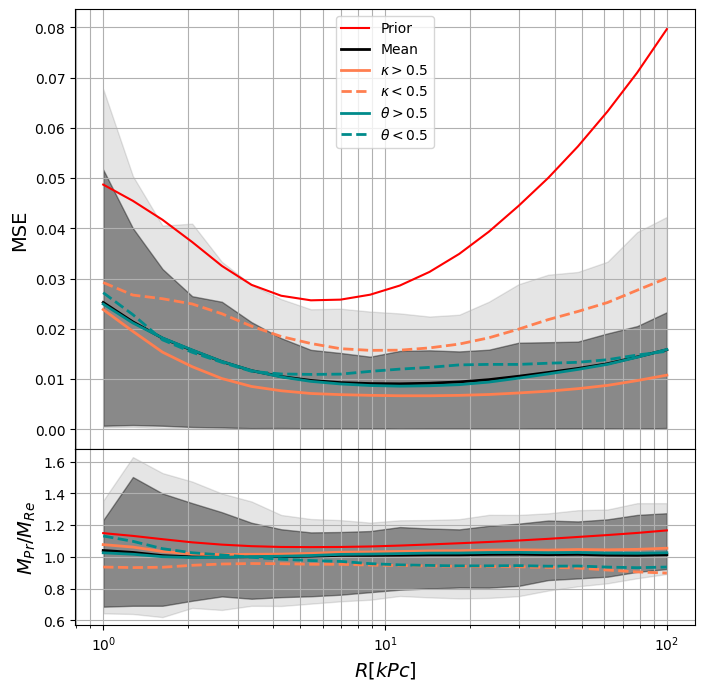

In [71]:
fig,ax = plt.subplots(2,1, figsize = (8,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

bin_centers = R_bins

mse, std, p_results = binned_MSE_kpc((np.log10(M_pred) - np.log10(M_real))**2)
mse_prior, _, _ = binned_MSE_kpc((np.log10(M_prior) - np.log10(M_real))**2)

ax[0].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')

ax[0].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
ax[0].fill_between(bin_centers, p_results['10'], p_results['90'], color = 'black', alpha = 0.1)
ax[0].fill_between(bin_centers, p_results['16'], p_results['84'], color = 'black', alpha = 0.4)

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]

mse_aux, std, p_results = binned_MSE_kpc((np.log10(M_pred[ind_aux]) - np.log10(M_real[ind_aux]))**2)
ax[0].plot(bin_centers, mse_aux, color = 'coral', ls = 'solid', label = '$\\kappa > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
mse_aux, std, p_results = binned_MSE_kpc((np.log10(M_pred[ind_aux]) - np.log10(M_real[ind_aux]))**2)
ax[0].plot(bin_centers, mse_aux, color = 'coral', ls = '--', label = '$\\kappa < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

# theta splitting
ind_aux = np.where(properties[test_ind, 18] > 0.5)[0]

mse_aux, std, p_results = binned_MSE_kpc((np.log10(M_pred[ind_aux]) - np.log10(M_real[ind_aux]))**2)
ax[0].plot(bin_centers, mse_aux, color = 'darkcyan', ls = 'solid', label = '$\\theta > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 18] < 0.5)[0]
mse_aux, std, p_results = binned_MSE_kpc((np.log10(M_pred[ind_aux]) - np.log10(M_real[ind_aux]))**2)
ax[0].plot(bin_centers, mse_aux, color = 'darkcyan', ls = '--', label = '$\\theta < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_ylabel('MSE', fontsize = 14)

ratio, _, _ = binned_MSE_kpc(M_pred / M_real)
ratio_prior, _, _ = binned_MSE_kpc(M_prior / M_real)

ax[1].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior')

ax[1].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
ax[1].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
ax[1].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]

mse_aux, _, _ = binned_MSE_kpc(M_pred[ind_aux] / M_real[ind_aux])
ax[1].plot(bin_centers, mse_aux, color = 'coral', ls = 'solid', label = '$\\kappa > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
mse_aux, _, _ = binned_MSE_kpc(M_pred[ind_aux] / M_real[ind_aux])
ax[1].plot(bin_centers, mse_aux, color = 'coral', ls = '--', label = '$\\kappa < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

# theta splitting
ind_aux = np.where(properties[test_ind, 18] > 0.5)[0]

mse_aux, _, _ = binned_MSE_kpc(M_pred[ind_aux] / M_real[ind_aux])
ax[1].plot(bin_centers, mse_aux, color = 'darkcyan', ls = 'solid', label = '$\\theta > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 18] < 0.5)[0]
mse_aux, _, _ = binned_MSE_kpc(M_pred[ind_aux] / M_real[ind_aux])
ax[1].plot(bin_centers, mse_aux, color = 'darkcyan', ls = '--', label = '$\\theta < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

ax[1].set_xlabel('$R [kPc]$', fontsize = 14)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')

#plt.savefig('drive/MyDrive/TNG/graphs/MSE_' + name + '_E2CNN_latest_mass.pdf')

In [72]:

from matplotlib.colors import LinearSegmentedColormap

# Define los colores extremos
start_color = 'coral'
end_color = 'darkcyan'

# Crea un gradiente lineal entre los dos colores
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [start_color, end_color])


In [73]:
col_cnn = 'darkcyan'
col_ecnn = 'coral'
col_prior = 'lightsteelblue'

In [74]:
r_norm = np.zeros_like(M_real)
for i in range(len(test_ind)):
    r_norm[i,:] = R_bins / properties[test_ind[i], 13]

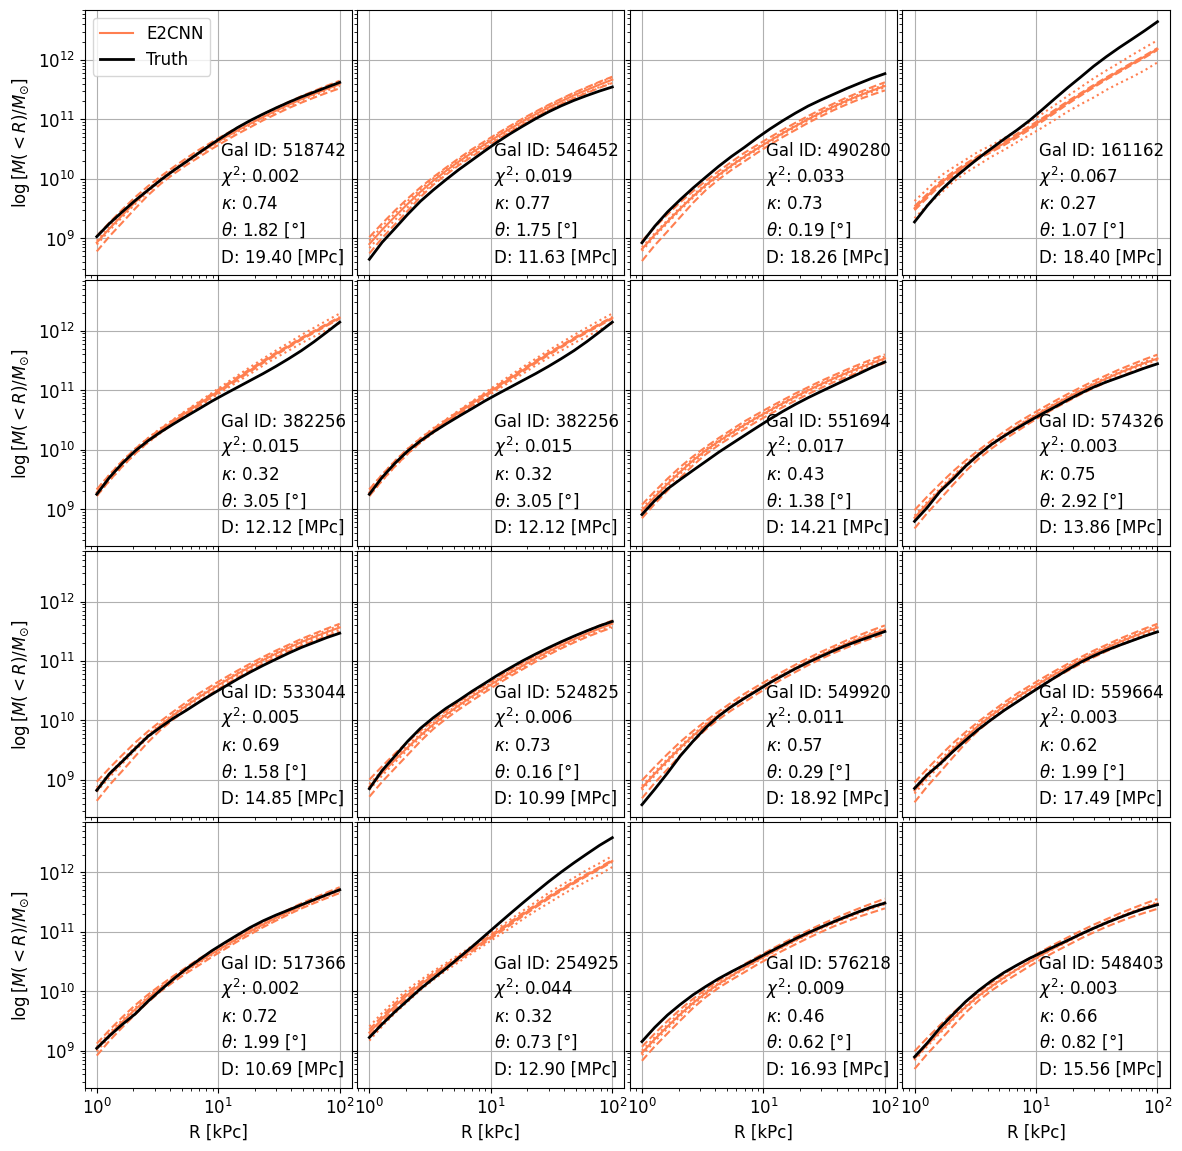

In [75]:
M0 = M_real
M_list = [M_pred_list,]
color_list = [col_ecnn,]
label_list = ['E2CNN',]
r_norm_list = [r_norm, r_norm]
ind_list = [test_ind,]

fig,ax = plt.subplots(4,4, sharex = True, sharey = True, figsize = (14,14),
                     gridspec_kw = {'hspace':0.02, 'wspace':0.02})

for iax in ax.flatten():
    i = np.random.randint(len(M_real)) #[ 40, 106, 127, 143, 164, 275, 277]

    for j, imass in enumerate(M_list):
        m_mean = np.mean(imass, axis = 0)
        m_std = np.std(imass, axis = 0)
        mean_std = np.sqrt(np.median((M_real - m_mean)**2, axis = 0))
        iax.plot(R_bins, ((m_mean[i,:])), c = color_list[j], label = label_list[j])
        iax.plot(R_bins, ((m_mean[i,:] + m_std[i,:])), c = color_list[j], ls = ':')
        iax.plot(R_bins, ((m_mean[i,:] - m_std[i,:])), c = color_list[j], ls = ':')
        iax.plot(R_bins, ((m_mean[i,:] + mean_std)), c = color_list[j], ls = '--')
        iax.plot(R_bins, ((m_mean[i,:] - mean_std)), c = color_list[j], ls = '--')

    iax.plot(R_bins, ((M_real[i,:])), c = 'black', lw = 2, label = 'Truth')

    iax.text(0.51,0.45, f'Gal ID: {int(properties[ind_list[j][i], 0])}',transform = iax.transAxes, fontsize = 12)
    chi2 = np.mean((np.log10(M_real[i,:]) - np.log10(m_mean[i,:]))**2)
    iax.text(0.51,0.35, '$\\chi^2$: {:.3f}'.format(chi2),transform = iax.transAxes, fontsize = 12)
    iax.text(0.51,0.25, '$\\kappa$: {:.2f}'.format(properties[ind_list[j][i], 15]),transform = iax.transAxes, fontsize = 12)
    iax.text(0.51,0.15, '$\\theta$: {:.2f} [°]'.format(properties[ind_list[j][i], 18]),transform = iax.transAxes, fontsize = 12)
    iax.text(0.51,0.05, 'D: {:.2f} [MPc]'.format(properties[ind_list[j][i], 17]),transform = iax.transAxes, fontsize = 12)

    iax.set_yscale('log')
    iax.set_xscale('log')
    iax.grid(which = 'major')
ax[0,0].legend(fontsize = 12, loc = 'upper left')
ax[3,0].set_xlabel('R [kPc]', fontsize = 12)
ax[3,1].set_xlabel('R [kPc]', fontsize = 12)
ax[3,2].set_xlabel('R [kPc]', fontsize = 12)
ax[3,3].set_xlabel('R [kPc]', fontsize = 12)
ax[0,0].set_ylabel('$\log{[M(<R) / M_{\odot}]}$', fontsize = 12)
ax[1,0].set_ylabel('$\log{[M(<R) / M_{\odot}]}$', fontsize = 12)
ax[2,0].set_ylabel('$\log{[M(<R) / M_{\odot}]}$', fontsize = 12)
ax[3,0].set_ylabel('$\log{[M(<R) / M_{\odot}]}$', fontsize = 12)

ax[3,0].xaxis.set_tick_params(labelsize=12)
ax[3,1].xaxis.set_tick_params(labelsize=12)
ax[3,2].xaxis.set_tick_params(labelsize=12)
ax[3,3].xaxis.set_tick_params(labelsize=12)

ax[0,0].yaxis.set_tick_params(labelsize=12)
ax[1,0].yaxis.set_tick_params(labelsize=12)
ax[2,0].yaxis.set_tick_params(labelsize=12)
ax[3,0].yaxis.set_tick_params(labelsize=12)

#plt.savefig('/content/drive/MyDrive/TNG/graphs/DMProfile_randomGals_8ch_set_5.pdf')

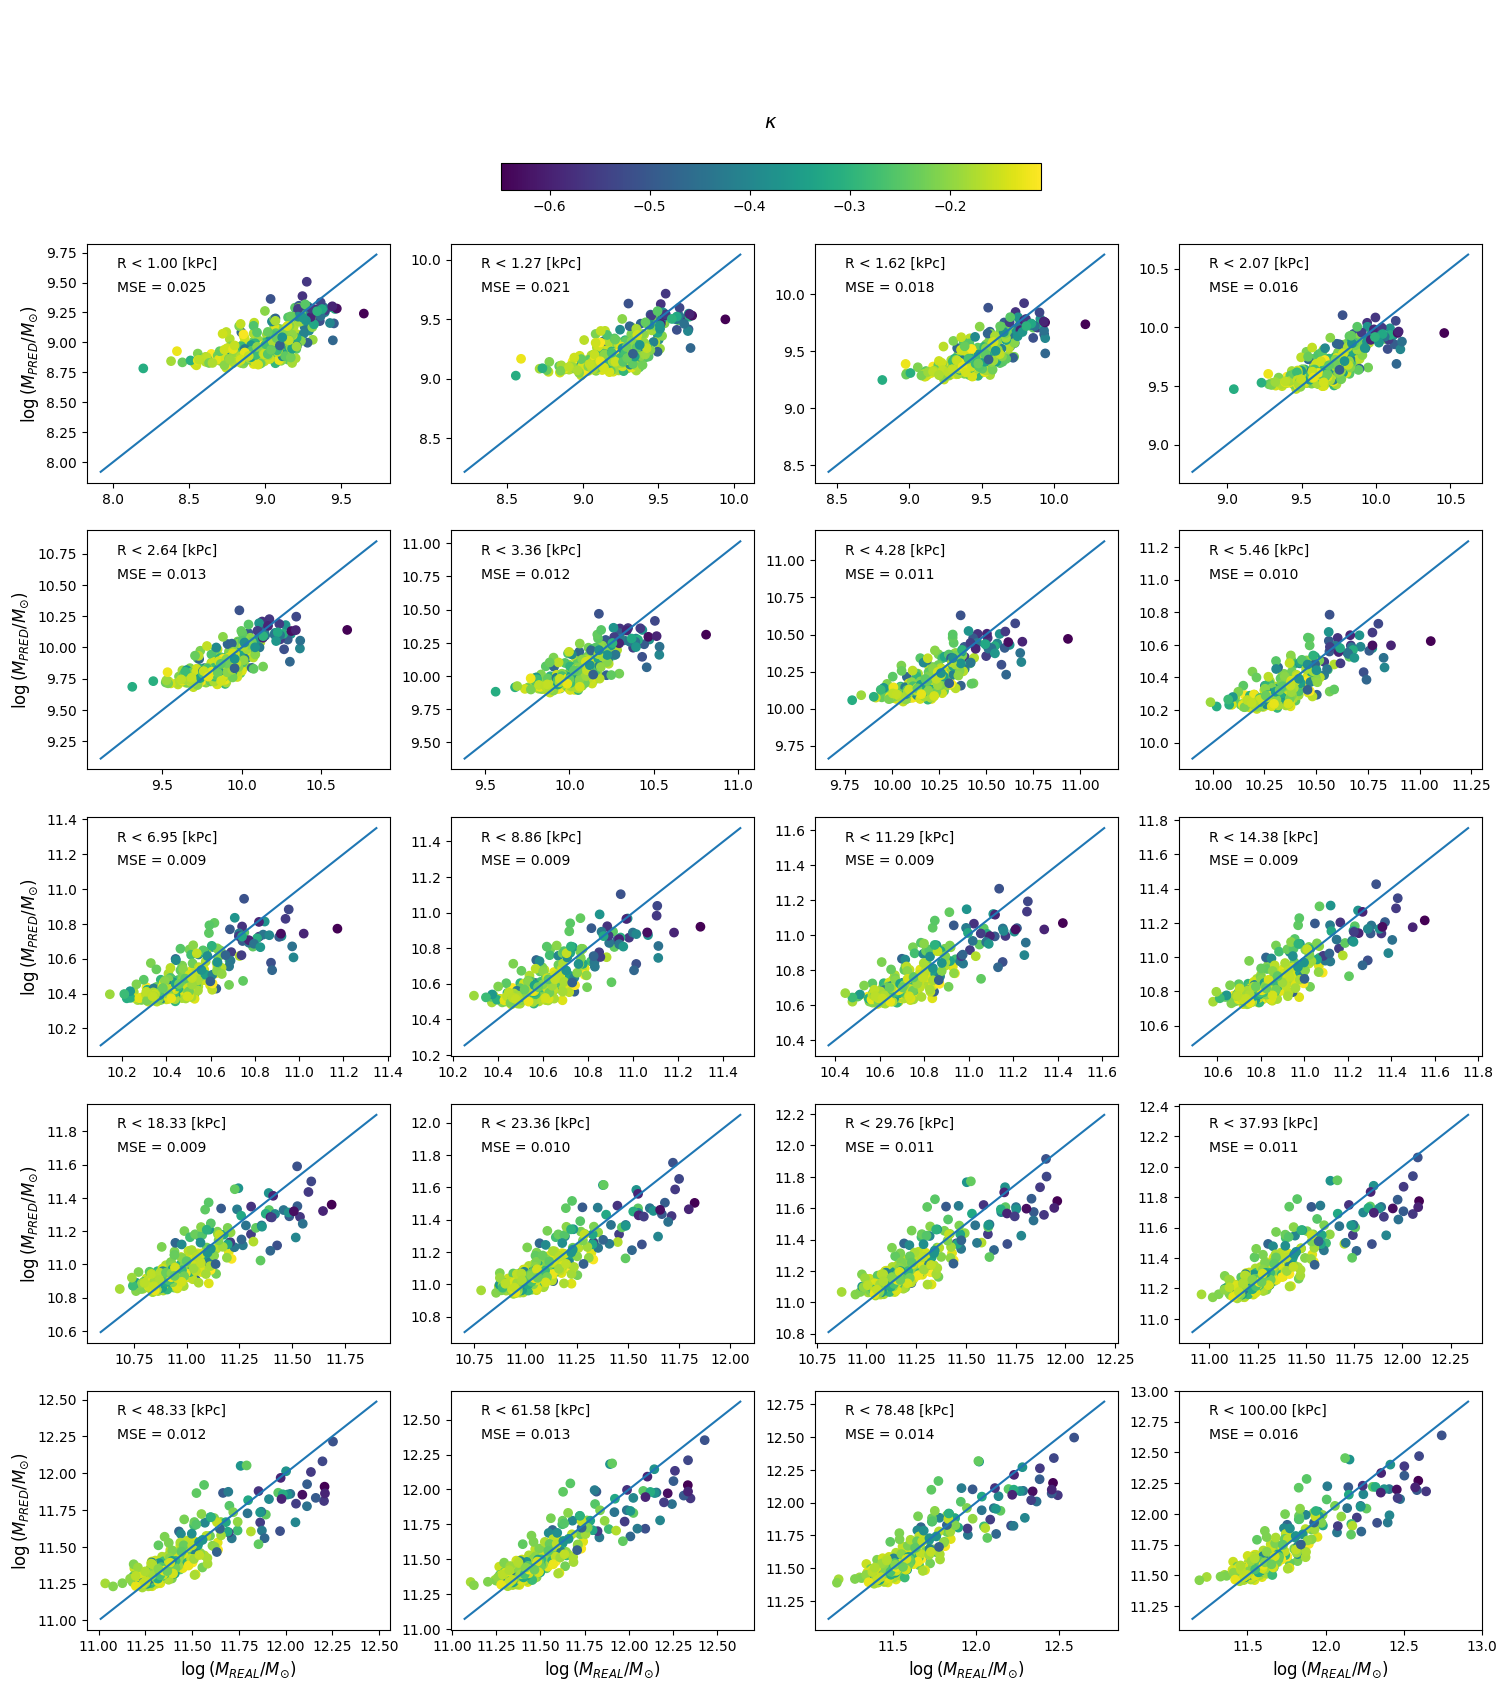

In [76]:
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):

        s = ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]), c = np.log10(properties[test_ind,15]), cmap = 'viridis',
                            vmin = np.log10(properties[test_ind,15]).min(), vmax = np.log10(properties[test_ind,15]).max())
        ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

        if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
        if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

        ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)

cbar_ax = fig.add_axes([0.1, 0.91, 0.81, 0.1])
cbar_ax.axis('off')
plt.colorbar(s, ax = cbar_ax, orientation = 'horizontal')
cbar_ax.set_title('$\\kappa$', y = 0., fontsize = 14)
plt.savefig('/content/drive/MyDrive/TNG/graphs/RealVSPred_' + name + '_kappa.pdf')

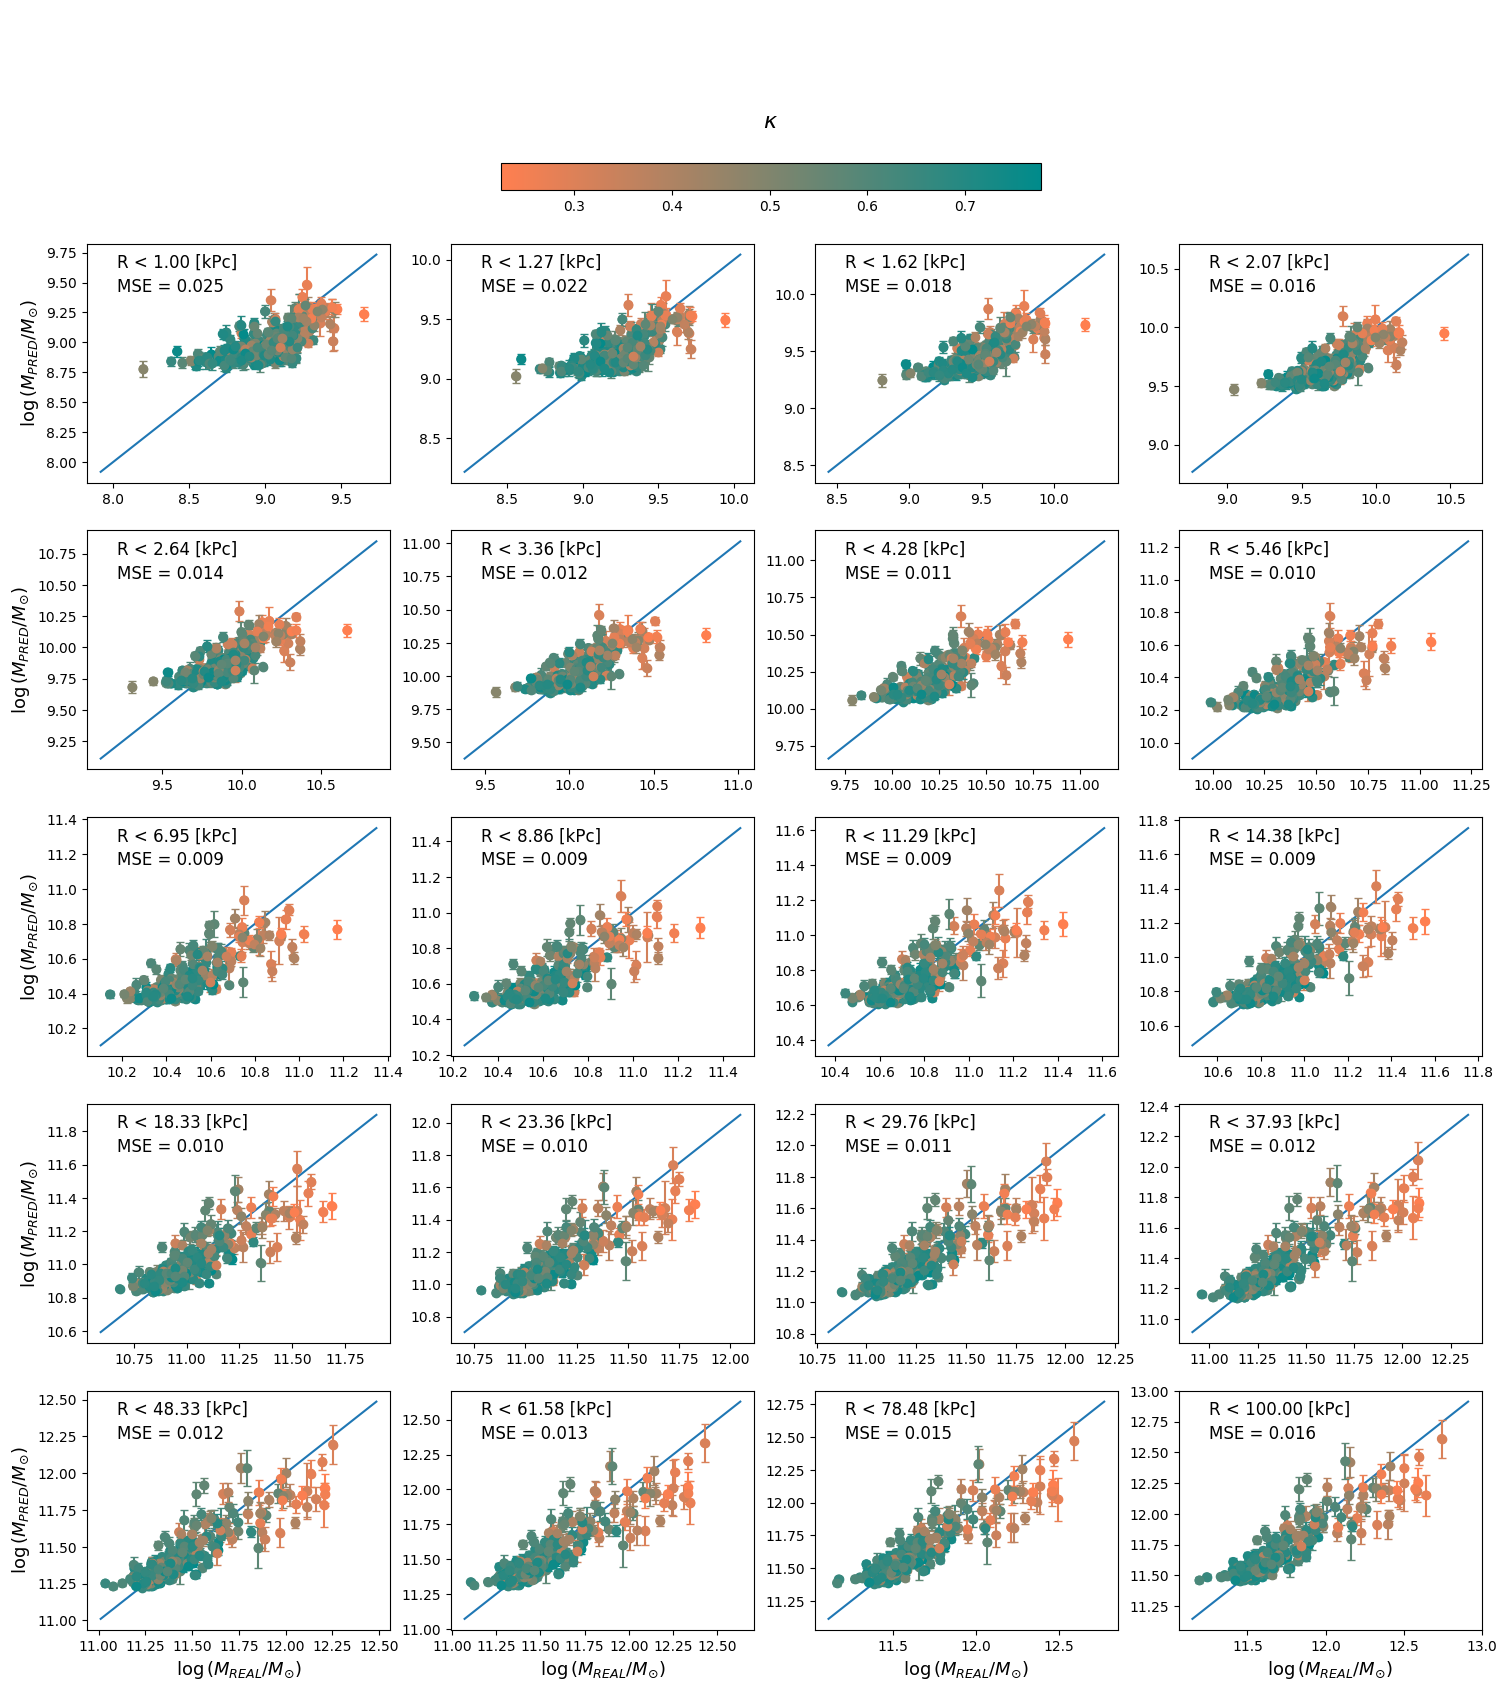

In [77]:

m_mean = np.mean(np.log10(M_pred_list), axis = 0)
m_std = np.std(np.log10(M_pred_list), axis = 0)

fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):

        z = properties[test_ind,15]
        s = ax[i,j].scatter((np.log10(M_real[:,i*4+j])), (m_mean[:,i*4+j]), c = (properties[test_ind,15]), cmap = custom_cmap,
                            vmin = z.min(), vmax = z.max())
        #ax[i,j].errorbar((np.log10(M_real[:,i*4+j])), (m_mean[:,i*4+j]), yerr = (m_std[:,i*4+j]))
        ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

        for e in range(len(M_real[:,i*4+j])):
            color = custom_cmap((z[e] - min(z)) / (max(z) - min(z)))  # Normaliza z para colormap
            ax[i,j].errorbar(np.log10(M_real[e,i*4+j]), m_mean[e,i*4+j], yerr=m_std[e,i*4+j], fmt='o', color=color, ecolor=color, capsize=3)

        if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 13)
        if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 13)

        ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(np.mean( (np.log10(M_real[:,i*4+j]) - (m_mean[:,i*4+j]))**2 )), transform = ax[i,j].transAxes, fontsize = 12)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes, fontsize = 12)

cbar_ax = fig.add_axes([0.1, 0.91, 0.81, 0.1])
cbar_ax.axis('off')
plt.colorbar(s, ax = cbar_ax, orientation = 'horizontal')
cbar_ax.set_title('$\\kappa$', y = 0., fontsize = 16)
plt.savefig('/content/drive/MyDrive/TNG/graphs/RealVSPred_ecnn_kappa.jpeg', bbox_inches = 'tight')

In [78]:
def plot_quantiles(ax, data_list, real_list, r_norm_list, color_list,
                   quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins2plot  = [5,12,14,15,16,17,18,19],
                   mean = False, minmax = False):

    '''
    data_list[0]: Must be the real mass
    data_list[1]: Must be the pred mass for model 1
    data_list[2]: Must be the pred mass for model 2
    data_list[3]: Must be the prior mass
    '''
    bins, bin_centers, mse, std, p_results = binned_MSE_q(r_norm_list[0], (np.log10(real_list[0]) - np.log10(data_list[0]))**2, quantiles = quantiles)
    ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[0], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[0], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((np.log10(real_list[0][:,ibin]) - np.log10(data_list[0][:,ibin]))**2)
            aux_max = np.max((np.log10(real_list[0][:,ibin]) - np.log10(data_list[0][:,ibin]))**2)
            ax[0].vlines(bin_centers[ibin] - 0.1, aux_min, aux_max, color = color_list[0], lw = 1, zorder = 10)
    ax[0].vlines(bin_centers[bins2plot] - 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)
    ax[0].vlines(bin_centers[bins2plot] - 0.34, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)
    ax[0].vlines(bin_centers[bins2plot] - 0.54, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)
    ax[0].vlines(bin_centers[bins2plot] - 0.74, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)
    ax[0].vlines(bin_centers[bins2plot] - 0.94, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)

    _, _, mse, std, p_results = binned_MSE_q(r_norm_list[1], (np.log10(real_list[1]) - np.log10(data_list[1]))**2, quantiles = quantiles, bins = bins)
    ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[1], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[1], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((np.log10(real_list[1][:,ibin]) - np.log10(data_list[1][:,ibin]))**2)
            aux_max = np.max((np.log10(real_list[1][:,ibin]) - np.log10(data_list[1][:,ibin]))**2)
            ax[0].vlines(bin_centers[ibin] + 0.1, aux_min, aux_max, color = color_list[1], lw = 1, zorder = 10)
    ax[0].vlines(bin_centers[bins2plot] + 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 0.34, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 0.54, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 0.74, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 0.94, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[1], lw = 5)

    if len(data_list) > 2:
        _, _, mse, std, p_results = binned_MSE_q(r_norm_list[2], (np.log10(real_list[2]) - np.log10(data_list[2]))**2, quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins = bins)
        ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[2], label = 'Median', lw = 2, zorder = 0)
        if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[2], label = 'Mean', lw = 2, zorder = 0, ls = '--')
        if minmax:
            for ibin in bins2plot:
                aux_min = np.min((np.log10(real_list[2][:,ibin]) - np.log10(data_list[2][:,ibin]))**2)
                aux_max = np.max((np.log10(real_list[2][:,ibin]) - np.log10(data_list[2][:,ibin]))**2)
                ax[0].vlines(bin_centers[ibin], aux_min, aux_max, color = color_list[2], lw = 1, zorder = 10)
        ax[0].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[2], lw = 10, zorder = 0)
        ax[0].vlines(bin_centers[bins2plot], p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[2], lw = 5, alpha = 0.4, zorder = 0)
        ax[0].vlines(bin_centers[bins2plot] + 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] - 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] + 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] - 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] + 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] - 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)

    _, _, mse, std, p_results = binned_MSE_q(r_norm_list[0], (data_list[0] / real_list[0]), quantiles = quantiles, bins = bins)
    ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[0], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[0], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((data_list[0][:,ibin] / real_list[0][:,ibin]))
            aux_max = np.max((data_list[0][:,ibin] / real_list[0][:,ibin]))
            ax[1].vlines(bin_centers[ibin] - 0.1, aux_min, aux_max, color = color_list[0], lw = 1, zorder = 10)
    ax[1].vlines(bin_centers[bins2plot] - 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 0.34, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 0.54, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 0.74, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 0.94, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[0], lw = 5)

    _, _, mse, std, p_results = binned_MSE_q(r_norm_list[1], (data_list[1] / real_list[1]), quantiles = quantiles, bins = bins)
    ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[1], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[1], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((data_list[1][:,ibin] / real_list[1][:,ibin]))
            aux_max = np.max((data_list[1][:,ibin] / real_list[1][:,ibin]))
            ax[1].vlines(bin_centers[ibin] + 0.1, aux_min, aux_max, color = color_list[1], lw = 1, zorder = 10)
    ax[1].vlines(bin_centers[bins2plot] + 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 0.34, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 0.54, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 0.74, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 0.94, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[1], lw = 5)

    if len(data_list) > 2:
        _, _, mse, std, p_results = binned_MSE_q(r_norm_list[2], (data_list[2] / real_list[2]), quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins = bins)
        ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[2], label = 'Median', lw = 2, zorder = 0)
        if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[2], label = 'Mean', lw = 2, zorder = 0, ls = '--')
        if minmax:
            for ibin in bins2plot:
                aux_min = np.min((data_list[2][:,ibin] / real_list[2][:,ibin]))
                aux_max = np.max((data_list[2][:,ibin] / real_list[2][:,ibin]))
                ax[1].vlines(bin_centers[ibin], aux_min, aux_max, color = color_list[2], lw = 1, zorder = 10)
        ax[1].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[2], lw = 10, zorder = 0)
        ax[1].vlines(bin_centers[bins2plot] , p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[2], lw = 5, alpha = 0.4, zorder = 0)
        ax[1].vlines(bin_centers[bins2plot] + 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] + 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] - 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] - 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] + 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] - 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)

    return ax

In [79]:
def plot_quantiles_kpc(ax, data_list, real_list, color_list,
                   quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins2plot  = [5,12,14,15,16,17,18,19],
                   mean = False, minmax = False, bin_centers = R_bins):

    '''
    data_list[0]: Must be the real mass
    data_list[1]: Must be the pred mass for model 1
    data_list[2]: Must be the pred mass for model 2
    data_list[3]: Must be the prior mass
    '''
    mse, std, p_results = binned_MSE_kpc((np.log10(real_list[0]) - np.log10(data_list[0]))**2, quantiles = quantiles)
    ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[0], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[0], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((np.log10(real_list[0][:,ibin]) - np.log10(data_list[0][:,ibin]))**2)
            aux_max = np.max((np.log10(real_list[0][:,ibin]) - np.log10(data_list[0][:,ibin]))**2)
            ax[0].vlines(bin_centers[ibin] - 0.1, aux_min, aux_max, color = color_list[0], lw = 1, zorder = 10)
    ax[0].vlines(bin_centers[bins2plot] - 0.4, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[0], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] - 1.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[0], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] - 1.9, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[0], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] - 2.6, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[0], lw = 5)

    mse, std, p_results = binned_MSE_kpc((np.log10(real_list[1]) - np.log10(data_list[1]))**2, quantiles = quantiles)
    ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[1], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[1], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((np.log10(real_list[1][:,ibin]) - np.log10(data_list[1][:,ibin]))**2)
            aux_max = np.max((np.log10(real_list[1][:,ibin]) - np.log10(data_list[1][:,ibin]))**2)
            ax[0].vlines(bin_centers[ibin] + 0.1, aux_min, aux_max, color = color_list[1], lw = 1, zorder = 10)
    ax[0].vlines(bin_centers[bins2plot] + 0.4 , p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 1.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 1.9, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 2.6, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[1], lw = 5)

    if len(data_list) > 2:
        mse, std, p_results = binned_MSE_kpc((np.log10(real_list[2]) - np.log10(data_list[2]))**2, quantiles = [10,16,30,40,45,50,55,60,70,84,90])
        ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[2], label = 'Median', lw = 2, zorder = 0)
        if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[2], label = 'Mean', lw = 2, zorder = 0, ls = '--')
        if minmax:
            for ibin in bins2plot:
                aux_min = np.min((np.log10(real_list[2][:,ibin]) - np.log10(data_list[2][:,ibin]))**2)
                aux_max = np.max((np.log10(real_list[2][:,ibin]) - np.log10(data_list[2][:,ibin]))**2)
                ax[0].vlines(bin_centers[ibin], aux_min, aux_max, color = color_list[2], lw = 1, zorder = 10)
        ax[0].vlines(bin_centers[bins2plot], p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[2], lw = 5, zorder = 0)
        ax[0].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[2], lw = 10, zorder = 0)
        ax[0].vlines(bin_centers[bins2plot], p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 20,zorder=0)
        ax[0].vlines(bin_centers[bins2plot], p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 40,zorder=0)
        ax[0].vlines(bin_centers[bins2plot], p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 60,zorder=0)

    mse, std, p_results = binned_MSE_kpc((data_list[0] / real_list[0]), quantiles = quantiles)
    ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[0], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[0], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((data_list[0][:,ibin] / real_list[0][:,ibin]))
            aux_max = np.max((data_list[0][:,ibin] / real_list[0][:,ibin]))
            ax[1].vlines(bin_centers[ibin] - 0.1, aux_min, aux_max, color = color_list[0], lw = 1, zorder = 10)
    ax[1].vlines(bin_centers[bins2plot] - 0.4, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 1.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 1.9, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 2.6, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[0], lw = 5)

    mse, std, p_results = binned_MSE_kpc((data_list[1] / real_list[1]), quantiles = quantiles)
    ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[1], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[1], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((data_list[1][:,ibin] / real_list[1][:,ibin]))
            aux_max = np.max((data_list[1][:,ibin] / real_list[1][:,ibin]))
            ax[1].vlines(bin_centers[ibin] + 0.1, aux_min, aux_max, color = color_list[1], lw = 1, zorder = 10)
    ax[1].vlines(bin_centers[bins2plot] + 0.4 , p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 1.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 1.9, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 2.6, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[1], lw = 5)

    if len(data_list) > 2:
        mse, std, p_results = binned_MSE_kpc((data_list[2] / real_list[2]), quantiles = [10,16,30,40,45,50,55,60,70,84,90])
        ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[2], label = 'Median', lw = 2, zorder = 0)
        if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[2], label = 'Mean', lw = 2, zorder = 0, ls = '--')
        if minmax:
            for ibin in bins2plot:
                aux_min = np.min((data_list[2][:,ibin] / real_list[2][:,ibin]))
                aux_max = np.max((data_list[2][:,ibin] / real_list[2][:,ibin]))
                ax[1].vlines(bin_centers[ibin], aux_min, aux_max, color = color_list[2], lw = 1, zorder = 10)
        ax[1].vlines(bin_centers[bins2plot], p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[2], lw = 5, zorder = 0)
        ax[1].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[2], lw = 10, zorder = 0)
        ax[1].vlines(bin_centers[bins2plot], p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 20,zorder=0)
        ax[1].vlines(bin_centers[bins2plot], p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 40,zorder=0)
        ax[1].vlines(bin_centers[bins2plot], p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 60,zorder=0)

    return ax

In [80]:
from matplotlib.lines import Line2D

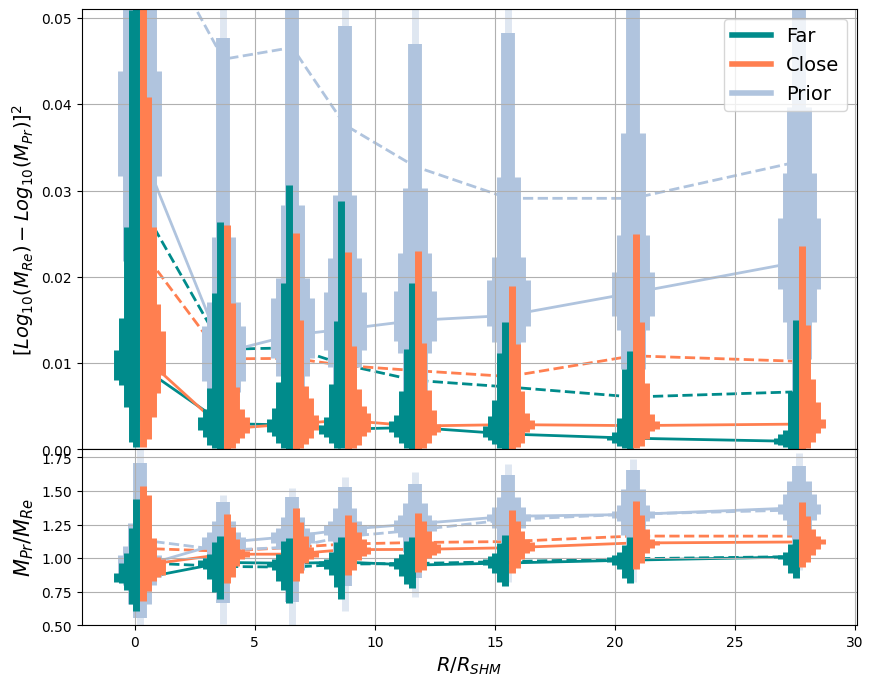

In [81]:
col_far = 'darkcyan'
col_close = 'coral'
col_prior = 'lightsteelblue'
bins2plot = [2,12,14,15,16,17,18,19]

aux_ind = test_ind #np.load('../data/CNNpredictions/mass_predictions_8ch.npz')['prop_id']

spiral_ind = np.where(properties[aux_ind, 17] > 15)[0]
#mask = ~np.isin(spiral_ind, test_outliers)
#spiral_ind = spiral_ind[mask]

ellip_ind = np.where(properties[aux_ind, 17] < 15)[0]
#mask = ~np.isin(ellip_ind, test_outliers)
#ellip_ind = ellip_ind[mask]

data_list = [M_pred[spiral_ind],M_pred[ellip_ind], M_prior]
real_list = [M_real[spiral_ind],M_real[ellip_ind], M_real]
r_norm_list = [r_norm[spiral_ind],r_norm[ellip_ind], r_norm]
color_list = [col_far, col_close,  col_prior]
label_list = ['Far', 'Close', 'Prior']

fig, ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

plot_quantiles(ax, data_list, real_list, r_norm_list, color_list, bins2plot  = bins2plot,
               mean = True, minmax = False)


#ax[0].set_xlim(-0.65,30)
ax[0].set_ylim(-0.0,0.051)
ax[1].set_ylim(0.5,1.81)
ax[0].set_ylabel('$[Log_{10}(M_{Re}) - Log_{10}(M_{Pr})]^{2}$', fontsize = 14)

ax[1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')

line1 = Line2D([], [], color=color_list[0], linestyle='solid', linewidth=4, label=label_list[0])
line2 = Line2D([], [], color=color_list[1], linestyle='solid', linewidth=4, label=label_list[1])
line3 = Line2D([], [], color=color_list[2], linestyle='solid', linewidth=4, label=label_list[2])
#line4 = Line2D([], [], color='magenta', linestyle='solid', linewidth=4, label='Stellar')

# Agregar la leyenda personalizada
ax[0].legend(handles=[line1,line2, line3], loc='upper right', fontsize = 14)

plt.savefig('/content/drive/MyDrive/TNG/graphs/MSEComparison_ecnn8ch_Far_vs_Close.pdf', bbox_inches = 'tight')

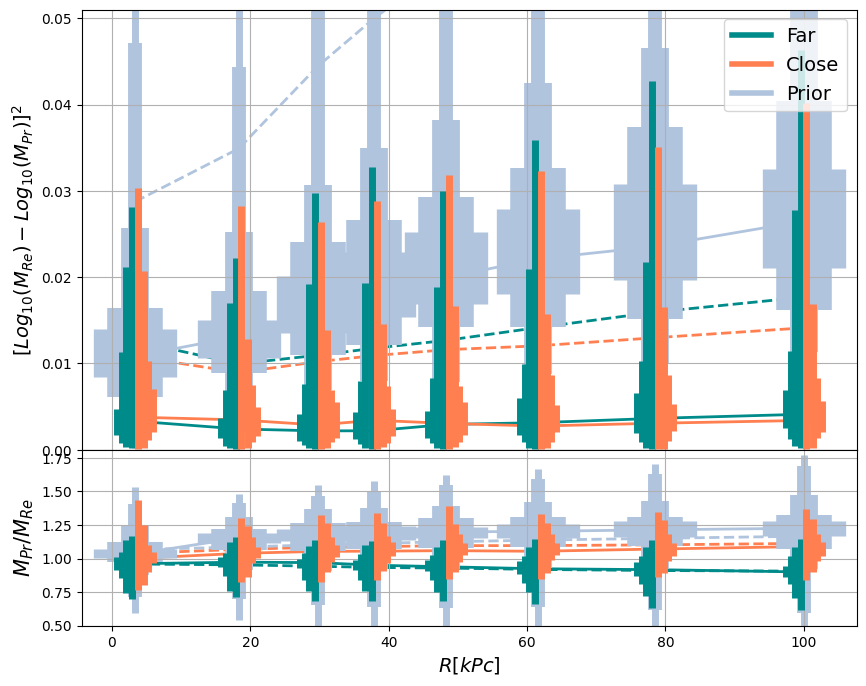

In [82]:
col_cnn = 'darkcyan'
col_ecnn = 'coral'
col_prior = 'lightsteelblue'
bins2plot = [5,12,14,15,16,17,18,19]

aux_ind = test_ind
spiral_ind = np.where(properties[aux_ind, 17] > 15)[0]
#mask = ~np.isin(spiral_ind, test_outliers)
#spiral_ind = spiral_ind[mask]

ellip_ind = np.where(properties[aux_ind, 17] < 15)[0]
#mask = ~np.isin(ellip_ind, test_outliers)
#ellip_ind = ellip_ind[mask]

data_list = [M_pred[spiral_ind],M_pred[ellip_ind], M_prior]
real_list = [M_real[spiral_ind],M_real[ellip_ind], M_real]
r_norm_list = [r_norm[spiral_ind],r_norm[ellip_ind], r_norm]
color_list = [col_cnn, col_ecnn,  col_prior]
label_list = ['Far', 'Close', 'Prior']

fig, ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

plot_quantiles_kpc(ax, data_list, real_list, color_list,
               quantiles = [10,16,30,40,50,60,70,84,90], bins2plot  = bins2plot,
               mean = True, minmax = False, bin_centers=R_bins)


#ax[0].set_xlim(-0.65,30)
ax[0].set_ylim(-0.0,0.051)
ax[1].set_ylim(0.5,1.81)
ax[0].set_ylabel('$[Log_{10}(M_{Re}) - Log_{10}(M_{Pr})]^{2}$', fontsize = 14)

ax[1].set_xlabel('$R [kPc]$', fontsize = 14)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')

line1 = Line2D([], [], color=color_list[0], linestyle='solid', linewidth=4, label=label_list[0])
line2 = Line2D([], [], color=color_list[1], linestyle='solid', linewidth=4, label=label_list[1])
line3 = Line2D([], [], color=color_list[2], linestyle='solid', linewidth=4, label=label_list[2])
#line4 = Line2D([], [], color='magenta', linestyle='solid', linewidth=4, label='Stellar')

# Agregar la leyenda personalizada
ax[0].legend(handles=[line1,line2, line3], loc='upper right', fontsize = 14)

plt.savefig('/content/drive/MyDrive/TNG/graphs/MSEComparison_cnn8ch_Far_vs_close_Rkpc.pdf', bbox_inches = 'tight')

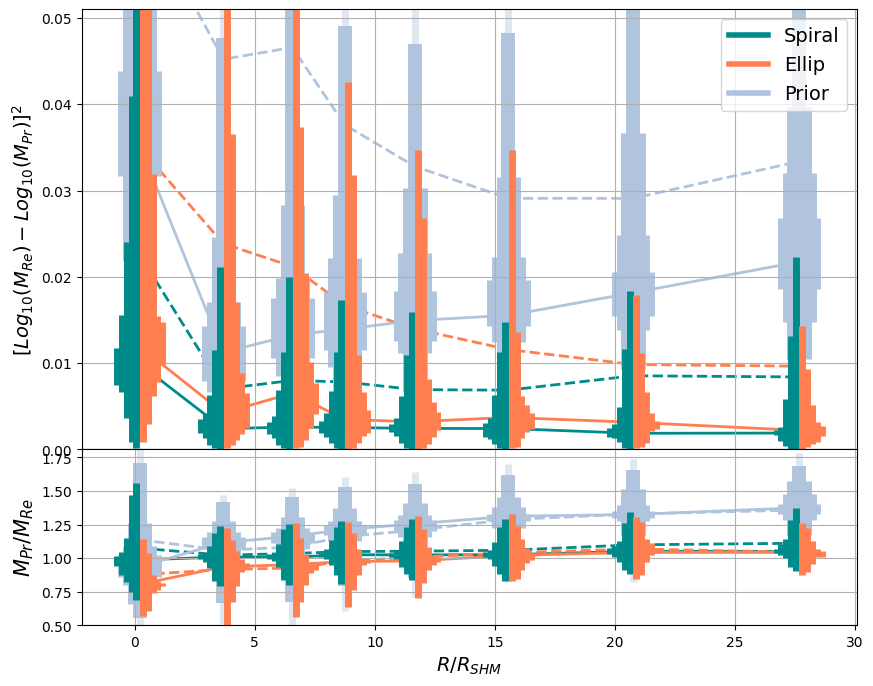

In [83]:
col_spiral = 'darkcyan'
col_ellip = 'coral'
col_prior = 'lightsteelblue'
bins2plot = [2,12,14,15,16,17,18,19]

aux_ind = test_ind #np.load('../data/CNNpredictions/mass_predictions_8ch.npz')['prop_id']

spiral_ind = np.where(properties[aux_ind, 15] > 0.5)[0]
#mask = ~np.isin(spiral_ind, test_outliers)
#spiral_ind = spiral_ind[mask]

ellip_ind = np.where(properties[aux_ind, 15] < 0.5)[0]
#mask = ~np.isin(ellip_ind, test_outliers)
#ellip_ind = ellip_ind[mask]

data_list = [M_pred[spiral_ind],M_pred[ellip_ind], M_prior]
real_list = [M_real[spiral_ind],M_real[ellip_ind], M_real]
r_norm_list = [r_norm[spiral_ind],r_norm[ellip_ind], r_norm]
color_list = [col_spiral, col_ellip,  col_prior]
label_list = ['Spiral', 'Ellip', 'Prior']

fig, ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

plot_quantiles(ax, data_list, real_list, r_norm_list, color_list, bins2plot  = bins2plot,
               mean = True, minmax = False)


#ax[0].set_xlim(-0.65,30)
ax[0].set_ylim(-0.0,0.051)
ax[1].set_ylim(0.5,1.81)
ax[0].set_ylabel('$[Log_{10}(M_{Re}) - Log_{10}(M_{Pr})]^{2}$', fontsize = 14)

ax[1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')

line1 = Line2D([], [], color=color_list[0], linestyle='solid', linewidth=4, label=label_list[0])
line2 = Line2D([], [], color=color_list[1], linestyle='solid', linewidth=4, label=label_list[1])
line3 = Line2D([], [], color=color_list[2], linestyle='solid', linewidth=4, label=label_list[2])
#line4 = Line2D([], [], color='magenta', linestyle='solid', linewidth=4, label='Stellar')

# Agregar la leyenda personalizada
ax[0].legend(handles=[line1,line2, line3], loc='upper right', fontsize = 14)

plt.savefig('/content/drive/MyDrive/TNG/graphs/MSEComparison_ecnn8ch_spiral_vs_ellip.pdf', bbox_inches = 'tight')

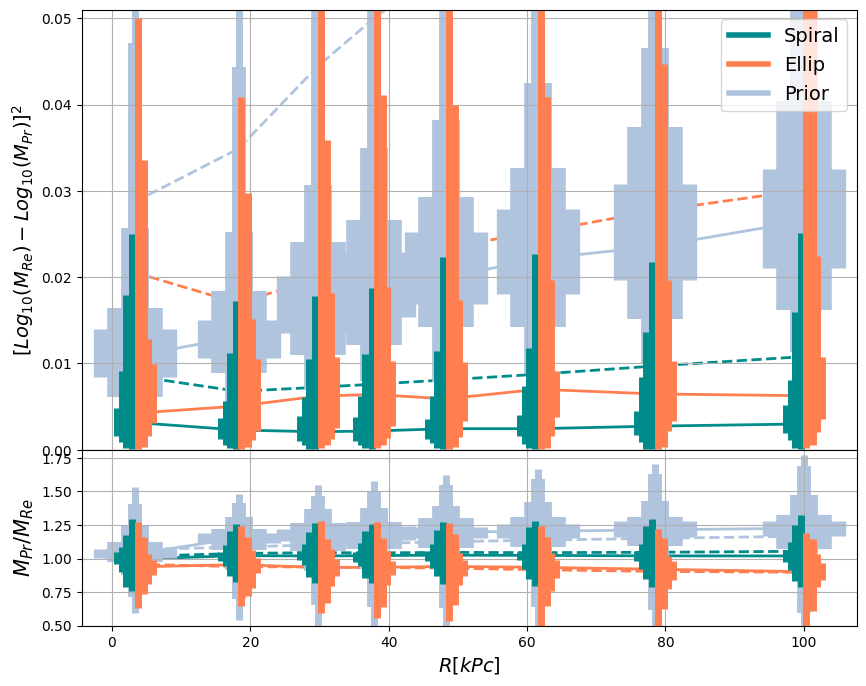

In [84]:
col_cnn = 'darkcyan'
col_ecnn = 'coral'
col_prior = 'lightsteelblue'
bins2plot = [5,12,14,15,16,17,18,19]

aux_ind = test_ind
spiral_ind = np.where(properties[aux_ind, 15] > 0.5)[0]
#mask = ~np.isin(spiral_ind, test_outliers)
#spiral_ind = spiral_ind[mask]

ellip_ind = np.where(properties[aux_ind, 15] < 0.5)[0]
#mask = ~np.isin(ellip_ind, test_outliers)
#ellip_ind = ellip_ind[mask]

data_list = [M_pred[spiral_ind],M_pred[ellip_ind], M_prior]
real_list = [M_real[spiral_ind],M_real[ellip_ind], M_real]
r_norm_list = [r_norm[spiral_ind],r_norm[ellip_ind], r_norm]
color_list = [col_cnn, col_ecnn,  col_prior]
label_list = ['Spiral', 'Ellip', 'Prior']

fig, ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

plot_quantiles_kpc(ax, data_list, real_list, color_list,
               quantiles = [10,16,30,40,50,60,70,84,90], bins2plot  = bins2plot,
               mean = True, minmax = False, bin_centers=R_bins)


#ax[0].set_xlim(-0.65,30)
ax[0].set_ylim(-0.0,0.051)
ax[1].set_ylim(0.5,1.81)
ax[0].set_ylabel('$[Log_{10}(M_{Re}) - Log_{10}(M_{Pr})]^{2}$', fontsize = 14)

ax[1].set_xlabel('$R [kPc]$', fontsize = 14)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')

line1 = Line2D([], [], color=color_list[0], linestyle='solid', linewidth=4, label=label_list[0])
line2 = Line2D([], [], color=color_list[1], linestyle='solid', linewidth=4, label=label_list[1])
line3 = Line2D([], [], color=color_list[2], linestyle='solid', linewidth=4, label=label_list[2])
#line4 = Line2D([], [], color='magenta', linestyle='solid', linewidth=4, label='Stellar')

# Agregar la leyenda personalizada
ax[0].legend(handles=[line1,line2, line3], loc='upper right', fontsize = 14)

plt.savefig('/content/drive/MyDrive/TNG/graphs/MSEComparison_cnn8ch_spiral_vs_ellip_Rkpc.pdf', bbox_inches = 'tight')

### Saliency maps

In [85]:
!ls -latr ../data/models/

ls: cannot access '../data/models/': No such file or directory


In [86]:

images, _ = next(iter(test_loader))
nimg = 278 #np.random.randint(len(test_ind))


In [87]:
print(nimg)

278


In [88]:
FoV = 17.2 # Arc minutes
pix_size_arcsec = 17.2 * (60) / 128 # Pixel size in arcsec
pix_size_rad = pix_size_arcsec / 3600 * (np.pi / 180) # Pixel size in radians

In [89]:
pix_size_rad * properties[test_ind[nimg],17] * 1e3 # pixel physical size at distance

np.float64(0.4700313320970971)

In [90]:
R_bins / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad

array([  2.1275,   2.711 ,   3.4546,   4.4021,   5.6095,   7.1481,   9.1086,  11.6069,  14.7904,
        18.847 ,  24.0162,  30.6033,  38.997 ,  49.6929,  63.3224,  80.6902, 102.8214, 131.0228,
       166.9591, 212.7518])

In [91]:
properties[test_ind[nimg],0]

np.float64(387236.0)

In [92]:
str(int(properties[test_ind[nimg],0]))

'387236'

In [93]:
image_name = glob.glob(os.path.join('/content/drive/MyDrive/data_TNG/TNGgalaxies/' + str(int(properties[test_ind[nimg],0])), 'galaxy_D_*_SDSS_G*.png'))
image_name

[]

In [94]:
image = plt.imread(image_name[0])
fig, ax = plt.subplots(1,1, figsize = (8,8))

ax.imshow(image)
circulo = patches.Circle((64,64,), int(properties[test_ind[nimg],13] / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad),
                         edgecolor='magenta', facecolor='none', linewidth=2, linestyle = ':')
ax.add_patch(circulo)

IndexError: list index out of range

In [ ]:
def binned_MSE(x, y, nbins = 20, xmin = -1, xmax = 1.5, bins = None):

    x_flat = x.flatten()
    y_flat = y
    y_flat = y_flat.flatten()

    if bins is None: bins = np.logspace(xmin, xmax, nbins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    p10_func = lambda y: np.percentile(y, 10)
    p16_func = lambda y: np.percentile(y, 16)
    p50_func = lambda y: np.percentile(y, 50)  # también es la mediana
    p84_func = lambda y: np.percentile(y, 84)
    p90_func = lambda y: np.percentile(y, 90)

    # Calcular la media de y en cada bin de x
    y_bin_means, _, _ = binned_statistic(x_flat, y_flat, statistic='mean', bins=bins)
    y_bin_std, _, _ = binned_statistic(x_flat, y_flat, statistic='std', bins=bins)
    p10, _, _ = binned_statistic(x_flat, y_flat, statistic=p10_func, bins=bins)
    p16, _, _ = binned_statistic(x_flat, y_flat, statistic=p16_func, bins=bins)
    p50, _, _ = binned_statistic(x_flat, y_flat, statistic=p50_func, bins=bins)
    p84, _, _ = binned_statistic(x_flat, y_flat, statistic=p84_func, bins=bins)
    p90, _, _ = binned_statistic(x_flat, y_flat, statistic=p90_func, bins=bins)
    # Coordenadas x de los centros de bin para graficar

    return bins, bin_centers, y_bin_means, y_bin_std, p10, p16, p50, p84, p90

In [ ]:
def estimate_saliency_map(model, image, radial_bin, noise_levels, num_perturbations=2):
    device = image.device
    dtype = image.dtype

    accumulated_saliency = torch.zeros_like(image, device=device, dtype=dtype)
    model.eval()

    print("image device", image.device, "dtype", image.dtype)
    print("model device", next(model.parameters()).device)
    for n, p in model.named_parameters():
      print(f"{n}: {p.device}")
    for _ in range(num_perturbations):
        img_var = image.clone().detach().to(device=device, dtype=dtype).requires_grad_()
        # This ensures noise_levels is float32, device CPU
        noise = torch.tensor(noise_levels, dtype=dtype, device=device)
        noisy_image = img_var + noise * torch.randn_like(img_var)
        print("img_var device", img_var.device, "dtype", img_var.dtype)
        print("noise device", noise.device, "dtype", noise.dtype)
        with torch.set_grad_enabled(True):
            output = model(noisy_image)
            if img_var.grad is not None:
                img_var.grad.zero_()
            with torch.autograd.set_detect_anomaly(True):
                output[0, radial_bin].backward(retain_graph=True)
        if img_var.grad is not None:
            accumulated_saliency += img_var.grad
        else:
            print("Warning: img_var.grad is None")
    accumulated_saliency /= num_perturbations
    saliency_map = accumulated_saliency.abs().squeeze()
    return saliency_map

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EquivariantConvNet(input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction).to(device)
best_model_path = '/content/drive/MyDrive/data_TNG/models/best_model_' + name + '_' + str(7) + '_new.pth'
model.load_state_dict(torch.load(best_model_path))

In [ ]:
nimg = 1
ch = 0
image = images[nimg].unsqueeze(0)
image= image.to(device)
#image = torch.from_numpy(images[nimg]).unsqueeze(0).to(device)
#image = torch.from_numpy(images[nimg]).unsqueeze(0).to(device).float()
noise_levels = np.array([1e-4,1e-3,1e-3,1e-3,1e-3,1e-2,1e-5,1e-7]).reshape(1,8,1,1)

x, y = np.ogrid[:128, :128]

fig, ax = plt.subplots(5,4, figsize = (18,18), sharex = True, sharey = True)
plt.subplots_adjust(wspace=-0.5, hspace=0.1)

saliency_profile_list = []
for i in range(5):
    for j in range(4):

        saliency_map = estimate_saliency_map(model, image, radial_bin = i*4+j, noise_levels = noise_levels,num_perturbations = 20)
        saliency_profile = []
        for r in R_bins:
            # Calcular la máscara circular
            mask = (x - 64)**2 + (y - 64)**2 <= int(r / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

            # Aplicar la máscara a la imagen
            #image_masked = saliency_map[ch, :,:].copy()
            image_masked = saliency_map[ch, :, :].detach().cpu().numpy().copy()
            image_masked[~mask] = 0  # Establecer a 0 los píxeles fuera del círculo
            saliency_profile.append(np.sum(image_masked) / (4*np.pi/3*(r**3)))

        saliency_profile = np.asarray(saliency_profile)
        saliency_profile_list.append(saliency_profile)
        norm_saliency_map = (saliency_map[ch, :,:] - saliency_map[ch, :,:].min()) / (saliency_map[ch, :,:].max() - saliency_map[ch, :,:].min())

        smoothed_saliency_map = gaussian_filter(norm_saliency_map.cpu(), sigma=3)  # Adjust sigma for desired smoothing

        ax1 = ax[i,j].imshow(smoothed_saliency_map, cmap='hot')
        circulo = patches.Circle((64,64,), int(R_bins[i*4+j] / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad), edgecolor='white', facecolor='none', linewidth=2)
        ax[i,j].add_patch(circulo)

        circulo = patches.Circle((64,64,), int(properties[test_ind[nimg],13] / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad),
                                 edgecolor='magenta', facecolor='none', linewidth=2, linestyle = ':')
        ax[i,j].add_patch(circulo)

        #ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes, color = 'white')
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')

plt.savefig('/content/drive/MyDrive/TNG-data/graphs/SaliencyMaps_' + str(properties[test_ind[nimg],0]) + '_ch_' + str(ch) + '_' + name + '.pdf')

In [ ]:
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=2)

# Usar cmap con valores normalizados
color = cmap(norm(R_bins[i]))

In [ ]:
for i in range(len(saliency_profile_list)):
    plt.scatter(R_bins[i], R_bins[np.where( (saliency_profile_list[i] * R_bins**3 / R_bins[19]**3 / saliency_profile_list[i][19] - 0.5) > 0 )[0][0]], c = 'black')

plt.yscale('log')
plt.xscale('log')

In [ ]:
for i in range(len(saliency_profile_list)):
    plt.plot(R_bins, saliency_profile_list[i], label = f'R < {R_bins[i]}', color= cmap(norm(np.log10(R_bins[i]))))
    plt.scatter(R_bins[i], saliency_profile_list[i][i] * R_bins[i]**3 / R_bins[19]**3 / saliency_profile_list[i][19], color= cmap(norm(np.log10(R_bins[i]))), zorder = 21)
    plt.scatter(R_bins[i], saliency_profile_list[i][i], color= cmap(norm(np.log10(R_bins[i]))), zorder = 21)
#plt.legend()
plt.yscale('log')
plt.xscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='log10(R)')

### Masked analysis

In [ ]:
nimg = 0
ch = 0
x, y = np.ogrid[:128, :128]

nbin = 11
masked_mass_predictions = []

for nbin in range(21):
    x_testset_masked = np.zeros_like(x_testset)
    for nimg in range(test_size):
        for ch in range(8):
            if nbin == 20:
                mask = (x - 64)**2 + (y - 64)**2 <= int(10000 / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2
            else:
                mask = (x - 64)**2 + (y - 64)**2 <= int(R_bins[nbin] / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

            # Aplicar la máscara a la imagen
            image_masked = x_testset[nimg,ch,:,:].copy()
            if i < 20: image_masked[~mask] = 0  # Establecer a 0 los píxeles fuera del círculo

            x_testset_masked[nimg,ch,:,:] = image_masked

    # Crear los DataLoaders para entrenamiento y validación
    masked_test_dataset  = CustomDataset(x_testset_masked, y_testset)
    masked_test_loader  = DataLoader(masked_test_dataset, batch_size=32, shuffle=False)

    masked_M_pred_list = []
    masked_test_loss_list = []
    for i in range(0,10):
        best_model_path = '/content/drive/MyDrive/TNG/TNG-data/models/best_model_' + name + '_' + str(i) + '_new.pth'

        model.load_state_dict(torch.load(best_model_path, weights_only=True))

        model.eval()  # Asegúrate de que el modelo esté en modo evaluación
        y_predicted_masked = []  # Lista para almacenar las predicciones

        # Desactivamos el cálculo de gradientes durante la predicción
        with torch.no_grad():
            test_loss = 0
            for inputs, true_vals in masked_test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset
                inputs = inputs.to(device)
                # Hacer predicciones
                outputs = model(inputs)

                # Almacenar las predicciones (por ejemplo, como numpy arrays)
                y_predicted_masked.append(outputs.detach().cpu().numpy())
                #y_predicted_masked.append(outputs.numpy())  # Si necesitas los resultados como numpy
                true_vals = true_vals.to(device)
                test_loss += criterion(outputs, true_vals).item()

        test_loss = test_loss / len(masked_test_loader)
        #print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
        masked_test_loss_list.append(test_loss)

        # Convertir la lista de predicciones en un solo array
        y_predicted_masked = np.concatenate(y_predicted_masked, axis=0)

        #print(y_predicted_masked.shape)  # Esto te dará la forma de las predicciones

        masked_M_pred = 10**(y_predicted_masked * (max_y - min_y) + min_y)
        M_real = 10**(y_testset * (max_y - min_y) + min_y)

        mass_quantiles = np.percentile((masked_M_pred / M_real), [25, 50, 75], axis=0)
        masked_M_pred_list.append(masked_M_pred)

    if len(masked_M_pred_list) > 1:
        masked_M_pred_list = np.asarray(masked_M_pred_list)
        masked_M_pred = np.mean(masked_M_pred_list, axis = 0)
        masked_M_pred_std = np.std(masked_M_pred_list, axis = 0)
    else:
        masked_M_pred_std = None

    y_predicted_masked = (np.log10(masked_M_pred) - min_y) / (max_y - min_y)
    masked_mass_predictions.append(masked_M_pred)

In [ ]:
len(np.where(mask == False)[0])

In [ ]:
plt.imshow(x_testset_masked[1,6,:,:])

In [ ]:
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):

        ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(masked_M_pred[:,i*4+j]))
        ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

        if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
        if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

        ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(masked_M_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)

# Masked analysis

In [ ]:
import glob
import matplotlib.patches as patches
from scipy.stats import binned_statistic
import astropy.units as u

In [ ]:
FoV = 17.2 # Arc minutes
pix_size_arcsec = 17.2 * (60) / 128 # Pixel size in arcsec
pix_size_rad = pix_size_arcsec / 3600 * (np.pi / 180) # Pixel size in radians

In [ ]:
mask_size_in_hmr = np.geomspace(0.1, 20, 20)

In [ ]:
ZP = [24.63, 25.11, 24.80, 24.36, 22.83]
mean_mag_arcsec2 = [22.01, 21.84, 20.84, 20.16, 18.96]
std_mag_arcsec2 = 0.1
noisy_mask = True
full_noise = True

#nimg = 0
x, y = np.ogrid[:128, :128]

masked_mass_predictions = []
masked_size_list = []

for nbin in range(21):
    x_testset_masked = np.zeros_like(x_testset)
    masked_size_aux = []
    for nimg in range(test_size):
        for ch in range(nch):
            if nbin == 20:
                mask = (x - 64)**2 + (y - 64)**2 <= int(10000 / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2
            else:
                mask_size = mask_size_in_hmr[nbin] * properties[test_ind[nimg], 13] # R_bins[nbin]
                mask = (x - 64)**2 + (y - 64)**2 <= int(mask_size / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

            # Aplicar la máscara a la imagen
            image_masked = x_testset[nimg,ch,:,:].copy()
            if i < 20: image_masked[~mask] = 0  # Establecer a 0 los píxeles fuera del círculo

            noise = np.zeros_like(image_masked)
            if noisy_mask and (ch < 5):
                mean_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr) # From https://classic.sdss.org/dr7/algorithms/fluxcal.php
                std_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] - std_mag_arcsec2 + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr)
                noise = np.random.normal(mean_mjysr, np.abs(std_mjysr - mean_mjysr), size=(128,128))
                noise = ((noise - min_x[ch,:,:]) / (max_x[ch,:,:] - min_x[ch,:,:]))
                noise[mask] = 0
            bkg_noise = np.zeros_like(image_masked)
            if full_noise:
                q = np.quantile(x_testset[nimg,ch,:,:], q = (0.1,0.2,0.3))
                bkg_noise = np.abs(np.random.normal(q[1], scale = np.abs(q[2] - q[0]), size = (128,128)))
            x_testset_masked[nimg,ch,:,:] = image_masked + noise + bkg_noise
        masked_size_aux.append(len(np.where(mask == False)[0]))
    masked_size_list.append(masked_size_aux)
    # Crear los DataLoaders para entrenamiento y validación
    masked_test_dataset  = CustomDataset(x_testset_masked, y_testset)
    masked_test_loader  = DataLoader(masked_test_dataset, batch_size=32, shuffle=False)

    masked_M_pred_list = []
    masked_test_loss_list = []
    for i in range(1,10):
        #best_model_path = '../data/models/best_model_' + name + '_' + str(i) + '.pth'
        best_model_path = '/content/drive/MyDrive/TNG/TNG-data/models/best_model_' + name + '_' + str(i) + '_new.pth'

        model.load_state_dict(torch.load(best_model_path, weights_only=True))

        model.eval()  # Asegúrate de que el modelo esté en modo evaluación
        y_predicted_masked = []  # Lista para almacenar las predicciones

        # Desactivamos el cálculo de gradientes durante la predicción
        with torch.no_grad():
            test_loss = 0
            for inputs, true_vals in masked_test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset
                inputs = inputs.to(device)
                true_vals = true_vals.to(device)
                # Hacer predicciones
                outputs = model(inputs)

                # Almacenar las predicciones (por ejemplo, como numpy arrays)
                y_predicted_masked.append(outputs.detach().cpu().numpy())  # Si necesitas los resultados como numpy
                test_loss += criterion(outputs, true_vals)

        test_loss = test_loss / len(test_loader)
        #print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
        masked_test_loss_list.append(test_loss)

        # Convertir la lista de predicciones en un solo array
        y_predicted_masked = np.concatenate(y_predicted_masked, axis=0)

        #print(y_predicted_masked.shape)  # Esto te dará la forma de las predicciones

        masked_M_pred = 10**(y_predicted_masked * (max_y - min_y) + min_y)
        M_real = 10**(y_testset * (max_y - min_y) + min_y)

        mass_quantiles = np.percentile((masked_M_pred / M_real), [25, 50, 75], axis=0)
        masked_M_pred_list.append(masked_M_pred)

    if len(masked_M_pred_list) > 1:
        masked_M_pred_list = np.asarray(masked_M_pred_list)
        masked_M_pred = np.mean(masked_M_pred_list, axis = 0)
        masked_M_pred_std = np.std(masked_M_pred_list, axis = 0)
    else:
        masked_M_pred_std = None

    y_predicted_masked = (np.log10(masked_M_pred) - min_y) / (max_y - min_y)
    masked_mass_predictions.append(masked_M_pred)

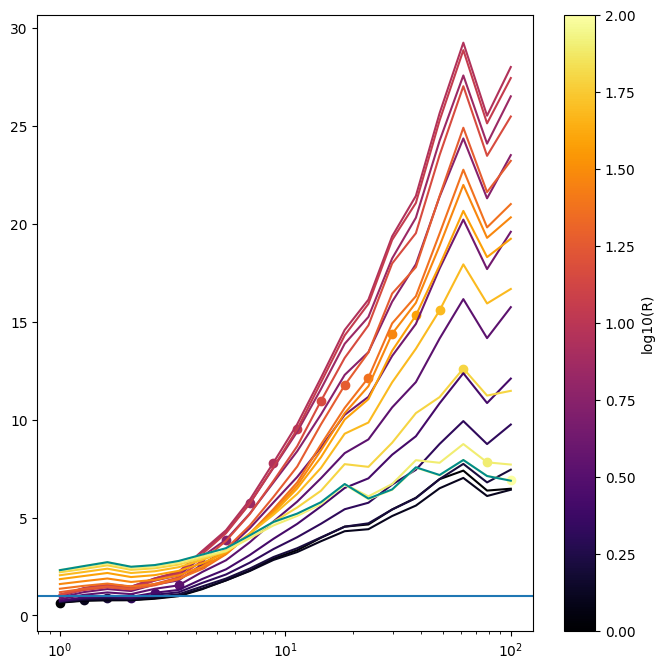

In [ ]:
cmap = plt.get_cmap('inferno')
norm = Normalize(vmin=0, vmax=2)

# Usar cmap con valores normalizados
color = cmap(norm(np.log10(R_bins)))

fig,ax = plt.subplots(1,1, figsize = (8,8))


for i in range(len(masked_mass_predictions)):
    y_predicted_masked = (np.log10(masked_mass_predictions[i]) - min_y) / (max_y - min_y)
    mse_masked = np.sqrt(mean_squared_error(y_testset, y_predicted_masked, multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
    std_masked = np.sqrt(np.std((y_testset - y_predicted_masked)**2, axis = 0))

    if  i < 20:
        ax.plot(R_bins, mse_masked / mse, color = cmap(norm(np.log10(R_bins[i]))))
        ax.scatter(R_bins[i], mse_masked[i] / mse[i], color = cmap(norm(np.log10(R_bins[i]))))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='log10(R)', ax = ax)

#ax.plot(R_bins, mse, color = 'coral', label = 'New', lw = 3)

#ax.set_ylabel('$\sqrt{ <\\frac{(M_{Re} - M_{PR})^2}{N}> }$', fontsize = 15)
ax.set_xscale('log')
#ax.legend()
ax.axhline(y=1)

y_predicted_masked = (np.log10(masked_mass_predictions[20]) - min_y) / (max_y - min_y)
mse_masked = np.sqrt(mean_squared_error(y_testset, y_predicted_masked, multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_masked = np.sqrt(np.std((y_testset - y_predicted_masked)**2, axis = 0))

ax.plot(R_bins, mse_masked / mse, color = 'darkcyan')

plt.savefig('/content/drive/MyDrive/TNG/graphs/masked_results.pdf')

# New masked analysis

In [95]:
FoV = 17.2 # Arc minutes
pix_size_arcsec = 17.2 * (60) / 128 # Pixel size in arcsec
pix_size_rad = pix_size_arcsec / 3600 * (np.pi / 180) # Pixel size in radians

In [96]:
mask_size_in_hmr = np.geomspace(0.1, 20, 20)

In [124]:
import astropy.units as u

ZP = [24.63, 25.11, 24.80, 24.36, 22.83]
mean_mag_arcsec2 = [22.01, 21.84, 20.84, 20.16, 18.96]
std_mag_arcsec2 = 0.1
noisy_mask = True
full_noise = False


x, y = np.ogrid[:128, :128]

masked_mass_predictions = []
masked_size_list = []

for nbin in range(21):
    x_testset_masked = np.zeros_like(x_testset)
    masked_size_aux = []
    for nimg in range(test_size):
        for ch in range(nch):
            if nbin == 20:
                mask = (x - 64)**2 + (y - 64)**2 <= int(10000 / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2
            else:
                mask_size = mask_size_in_hmr[nbin] * properties[test_ind[nimg], 13] # R_bins[nbin]
                #mask_size = R_bins[nbin]
                mask = (x - 64)**2 + (y - 64)**2 <= int(mask_size / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

            # Aplicar la máscara a la imagen
            image_masked = x_testset[nimg,ch,:,:].copy()
            if nbin < 20: image_masked[~mask] = 0  # Establecer a 0 los píxeles fuera del círculo

            noise = np.zeros_like(image_masked)
            if noisy_mask and (ch < 5):
                mean_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr) # From https://classic.sdss.org/dr7/algorithms/fluxcal.php
                std_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] - std_mag_arcsec2 + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr)
                noise = np.random.normal(mean_mjysr, np.abs(std_mjysr - mean_mjysr), size=(128,128))
                noise = ((noise - min_x[ch,:,:]) / (max_x[ch,:,:] - min_x[ch,:,:]))
                noise[mask] = 0
            bkg_noise = np.zeros_like(image_masked)
            if full_noise:
                q = np.quantile(x_testset[nimg,ch,:,:], q = (0.1,0.2,0.3))
                scale_value = q[2] - q[0]
                if scale_value <= 0:
                    print(f"Warning: Negative scale ({scale_value}) encountered for image {nimg}, channel {ch}. Using absolute value.")
                    bkg_noise_scale = 1.e-9
                else:
                    bkg_noise_scale = scale_value
                bkg_noise = np.abs(np.random.normal(q[1], scale = bkg_noise_scale, size = (128,128)))
            x_testset_masked[nimg,ch,:,:] = image_masked + noise + bkg_noise
        masked_size_aux.append(len(np.where(mask == False)[0]))
    masked_size_list.append(masked_size_aux)
    # Crear los DataLoaders para entrenamiento y validación
    masked_test_dataset  = CustomDataset(x_testset_masked, y_testset)
    masked_test_loader  = DataLoader(masked_test_dataset, batch_size=32, shuffle=False)

    masked_M_pred_list = []
    masked_test_loss_list = []
    for i in range(1,10):
        best_model_path = '/content/drive/MyDrive/TNG/TNG-data/models/best_model_' + name + '_' + str(i) + '_new.pth' #'../data/models/best_model_' + name + '_' + str(i) + '.pth'

        model.load_state_dict(torch.load(best_model_path, weights_only=True))

        model.eval()  # Asegúrate de que el modelo esté en modo evaluación
        y_predicted_masked = []  # Lista para almacenar las predicciones

        # Desactivamos el cálculo de gradientes durante la predicción
        with torch.no_grad():
            test_loss = 0
            for inputs, true_vals in masked_test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset

                #input data to GPU
                inputs = inputs.to(device)
                #predictions
                outputs = model(inputs)

                # masked predictions
                y_predicted_masked.append(outputs.detach().cpu().numpy())

                true_vals = true_vals.to(device)


                test_loss += criterion(outputs, true_vals)

        test_loss = test_loss / len(test_loader)
        #print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
        masked_test_loss_list.append(test_loss)

        # Convertir la lista de predicciones en un solo array
        y_predicted_masked = np.concatenate(y_predicted_masked, axis=0)

        #print(y_predicted_masked.shape)  # Esto te dará la forma de las predicciones

        masked_M_pred = 10**(y_predicted_masked * (max_y - min_y) + min_y)
        M_real = 10**(y_testset * (max_y - min_y) + min_y)

        mass_quantiles = np.percentile((masked_M_pred / M_real), [25, 50, 75], axis=0)
        masked_M_pred_list.append(masked_M_pred)

    if len(masked_M_pred_list) > 1:
        masked_M_pred_list = np.asarray(masked_M_pred_list)
        masked_M_pred = np.mean(masked_M_pred_list, axis = 0)
        masked_M_pred_std = np.std(masked_M_pred_list, axis = 0)
    else:
        masked_M_pred_std = None

    y_predicted_masked = (np.log10(masked_M_pred) - min_y) / (max_y - min_y)
    masked_mass_predictions.append(masked_M_pred)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


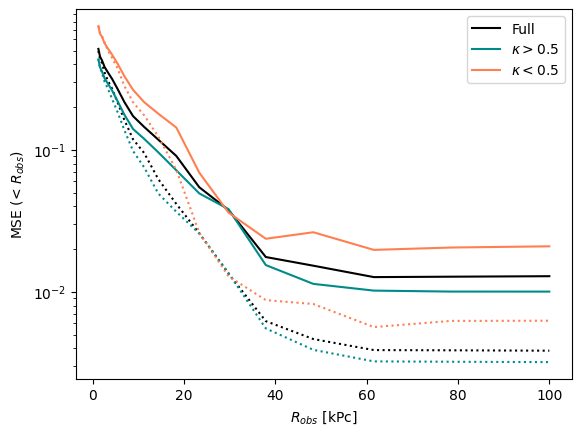

In [122]:
mse_mean = np.zeros(20)
mse_median = np.zeros(20)
mse_mean_sp = np.zeros(20)
mse_median_sp = np.zeros(20)
mse_mean_el = np.zeros(20)
mse_median_el = np.zeros(20)
for i in range(len(masked_mass_predictions[:-1])):
    aux_pred = masked_mass_predictions[i]

    mse_mean[i] = np.mean((np.log10(aux_pred[:,:i]) - np.log10(M_real[:,:i]))**2)
    mse_median[i] = np.median((np.log10(aux_pred[:,:i]) - np.log10(M_real[:,:i]))**2)

    ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]
    mse_mean_sp[i] = np.mean((np.log10(aux_pred[ind_aux,:i]) - np.log10(M_real[ind_aux,:i]))**2)
    mse_median_sp[i] = np.median((np.log10(aux_pred[ind_aux,:i]) - np.log10(M_real[ind_aux,:i]))**2)

    ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
    mse_mean_el[i] = np.mean((np.log10(aux_pred[ind_aux,:i]) - np.log10(M_real[ind_aux,:i]))**2)
    mse_median_el[i] = np.median((np.log10(aux_pred[ind_aux,:i]) - np.log10(M_real[ind_aux,:i]))**2)

plt.plot(R_bins, mse_mean, label = 'Full', color = 'black')
plt.plot(R_bins, mse_median, ls = ':', color = 'black')
plt.plot(R_bins, mse_mean_sp, color = 'darkcyan', label = '$\\kappa > 0.5$')
plt.plot(R_bins, mse_median_sp, ls = ':', color = 'darkcyan')
plt.plot(R_bins, mse_mean_el, color = 'coral', label = '$\\kappa < 0.5$')
plt.plot(R_bins, mse_median_el, ls = ':', color = 'coral')

plt.yscale('log')
plt.xlabel('$R_{obs}$ [kPc]')
plt.ylabel('MSE (< $R_{obs}$)')
plt.legend()

plt.savefig('/content/drive/MyDrive/TNG/graphs/1DMaskedMSE_' + name + '_E2CNN_v2.pdf')

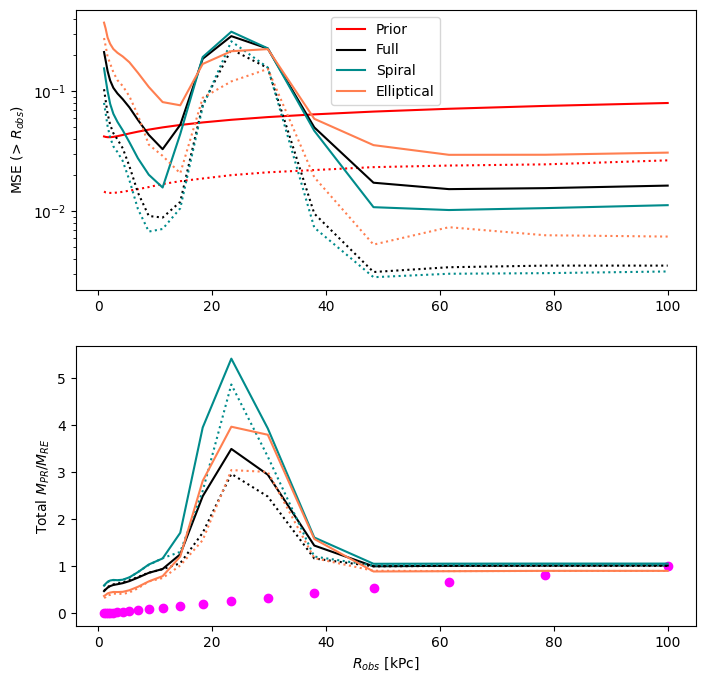

In [123]:
prior_mean = np.zeros(20)
prior_median = np.zeros(20)
mse_mean = np.zeros(20)
mse_median = np.zeros(20)
mse_mean_sp = np.zeros(20)
mse_median_sp = np.zeros(20)
mse_mean_el = np.zeros(20)
mse_median_el = np.zeros(20)

ratio_mean = np.zeros(20)
ratio_median = np.zeros(20)
ratio_mean_sp = np.zeros(20)
ratio_median_sp = np.zeros(20)
ratio_mean_el = np.zeros(20)
ratio_median_el = np.zeros(20)

fig,ax = plt.subplots(2,1, figsize = (8,8))
for i in range(len(masked_mass_predictions[:-1])):
    aux_pred = masked_mass_predictions[i]

    prior_mean[i] = np.mean((np.log10(M_prior[:,i:]) - np.log10(M_real[:,i:]))**2)
    prior_median[i] = np.median((np.log10(M_prior[:,i:]) - np.log10(M_real[:,i:]))**2)

    mse_mean[i] = np.mean((np.log10(aux_pred[:,i:]) - np.log10(M_real[:,i:]))**2)
    mse_median[i] = np.median((np.log10(aux_pred[:,i:]) - np.log10(M_real[:,i:]))**2)
    ratio_mean[i]   = np.mean(aux_pred[:,i:] / M_real[:,i:])
    ratio_median[i] = np.median(aux_pred[:,i:] / M_real[:,i:])

    ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]
    mse_mean_sp[i] = np.mean((np.log10(aux_pred[ind_aux,i:]) - np.log10(M_real[ind_aux,i:]))**2)
    mse_median_sp[i] = np.median((np.log10(aux_pred[ind_aux,i:]) - np.log10(M_real[ind_aux,i:]))**2)
    ratio_mean_sp[i]   = np.mean(aux_pred[ind_aux,19] / M_real[ind_aux,19])
    ratio_median_sp[i] = np.median(aux_pred[ind_aux,19] / M_real[ind_aux,19])

    ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
    mse_mean_el[i] = np.mean((np.log10(aux_pred[ind_aux,i:]) - np.log10(M_real[ind_aux,i:]))**2)
    mse_median_el[i] = np.median((np.log10(aux_pred[ind_aux,i:]) - np.log10(M_real[ind_aux,i:]))**2)
    ratio_mean_el[i]   = np.mean(aux_pred[ind_aux,19] / M_real[ind_aux,19])
    ratio_median_el[i] = np.median(aux_pred[ind_aux,19] / M_real[ind_aux,19])

    ax[1].scatter(R_bins[i], np.mean(M_real[:,i] /  M_real[:, 19]) , color = 'magenta')

ax[0].plot(R_bins, prior_mean, label = 'Prior', color = 'red')
ax[0].plot(R_bins, prior_median, ls = ':', color = 'red')
ax[0].plot(R_bins, mse_mean, label = 'Full', color = 'black')
ax[0].plot(R_bins, mse_median, ls = ':', color = 'black')
ax[0].plot(R_bins, mse_mean_sp, color = 'darkcyan', label = 'Spiral')
ax[0].plot(R_bins, mse_median_sp, ls = ':', color = 'darkcyan')
ax[0].plot(R_bins, mse_mean_el, color = 'coral', label = 'Elliptical')
ax[0].plot(R_bins, mse_median_el, ls = ':', color = 'coral')

ax[0].set_yscale('log')
ax[1].set_xlabel('$R_{obs}$ [kPc]')
ax[0].set_ylabel('MSE (> $R_{obs}$)')
ax[1].set_ylabel('Total $M_{PR} / M_{RE}$')
ax[0].legend()


ax[1].plot(R_bins, ratio_mean, label = 'Full', color = 'black')
ax[1].plot(R_bins, ratio_median, ls = ':', color = 'black')
ax[1].plot(R_bins, ratio_mean_sp, color = 'darkcyan', label = 'Spiral')
ax[1].plot(R_bins, ratio_median_sp, ls = ':', color = 'darkcyan')
ax[1].plot(R_bins, ratio_mean_el, color = 'coral', label = 'Elliptical')
ax[1].plot(R_bins, ratio_median_el, ls = ':', color = 'coral')

plt.savefig('/content/drive/MyDrive/TNG/graphs/1DMaskedMSE_extrapolation_' + name + '_E2CNN_v2.pdf')

/tmp/ipython-input-138-1321906917.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


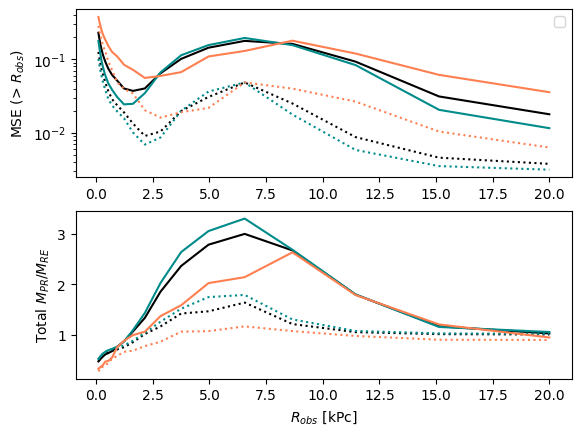

In [138]:
mse_mean = np.zeros(20)
mse_median = np.zeros(20)
mse_mean_sp = np.zeros(20)
mse_median_sp = np.zeros(20)
mse_mean_el = np.zeros(20)
mse_median_el = np.zeros(20)

ratio_mean = np.zeros(20)
ratio_median = np.zeros(20)
ratio_mean_sp = np.zeros(20)
ratio_median_sp = np.zeros(20)
ratio_mean_el = np.zeros(20)
ratio_median_el = np.zeros(20)

fig,ax = plt.subplots(2,1)

for i in range(len(masked_mass_predictions[:-1])):

    aux_pred = masked_mass_predictions[i]
    mse_mean[i] = np.mean((np.log10(aux_pred[:,i:]) - np.log10(M_real[:,i:]))**2)
    mse_median[i] = np.median((np.log10(aux_pred[:,i:]) - np.log10(M_real[:,i:]))**2)
    ratio_mean[i]   = np.mean(aux_pred[:,19] / M_real[:,19])
    ratio_median[i] = np.median(aux_pred[:,19] / M_real[:,19])

    ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]
    mse_mean_sp[i] = np.mean((np.log10(aux_pred[ind_aux,i:]) - np.log10(M_real[ind_aux,i:]))**2)
    mse_median_sp[i] = np.median((np.log10(aux_pred[ind_aux,i:]) - np.log10(M_real[ind_aux,i:]))**2)
    ratio_mean_sp[i]   = np.mean(aux_pred[ind_aux,19] / M_real[ind_aux,19])
    ratio_median_sp[i] = np.median(aux_pred[ind_aux,19] / M_real[ind_aux,19])

    ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
    mse_mean_el[i] = np.mean((np.log10(aux_pred[ind_aux,i:]) - np.log10(M_real[ind_aux,i:]))**2)
    mse_median_el[i] = np.median((np.log10(aux_pred[ind_aux,i:]) - np.log10(M_real[ind_aux,i:]))**2)
    ratio_mean_el[i]   = np.mean(aux_pred[ind_aux,19] / M_real[ind_aux,19])
    ratio_median_el[i] = np.median(aux_pred[ind_aux,19] / M_real[ind_aux,19])


ax[0].plot(mask_size_in_hmr, mse_mean, color = 'black')
ax[0].plot(mask_size_in_hmr, mse_median, ls = ':', color = 'black')
ax[0].plot(mask_size_in_hmr, mse_mean_sp, color = 'darkcyan')
ax[0].plot(mask_size_in_hmr, mse_median_sp, ls = ':', color = 'darkcyan')
ax[0].plot(mask_size_in_hmr, mse_mean_el, color = 'coral')
ax[0].plot(mask_size_in_hmr, mse_median_el, ls = ':', color = 'coral')

ax[1].plot(mask_size_in_hmr, ratio_mean, color = 'black')
ax[1].plot(mask_size_in_hmr, ratio_median, ls = ':', color = 'black')
ax[1].plot(mask_size_in_hmr, ratio_mean_sp, color = 'darkcyan')
ax[1].plot(mask_size_in_hmr, ratio_median_sp, ls = ':', color = 'darkcyan')
ax[1].plot(mask_size_in_hmr, ratio_mean_el, color = 'coral')
ax[1].plot(mask_size_in_hmr, ratio_median_el, ls = ':', color = 'coral')

ax[0].set_yscale('log')
ax[1].set_xlabel('$R_{obs}$ [kPc]')
ax[0].set_ylabel('MSE (> $R_{obs}$)')
ax[1].set_ylabel('Total $M_{PR} / M_{RE}$')
ax[0].legend()


plt.savefig('/content/drive/MyDrive/TNG/graphs/1DMaskedNormalizedMSE_' + name + '_E2CNN_v2_extra.pdf')

In [ ]:

for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]

fig,ax = plt.subplots(4,2, figsize = (14,14), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)
#for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

for ii, iaux in enumerate([4, 14, 17, 19]):
    jj = 0
    if ii > 1:
        ii = ii-2
        jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    #aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)
    bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (np.log10(aux_pred) - np.log10(M_real))**2)
    _, _, mse_prior, _, _, _, _, _, _ = binned_MSE(r, (np.log10(M_prior) - np.log10(M_real))**2, bins = bins)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

    ax[jj,ii].axvspan(mask_size_in_hmr[iaux], 40, color='darkcyan', alpha=0.3)

    _, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, aux_pred / M_real, bins = bins)
    _, _, ratio_prior, _, _, _, _, _, _ = binned_MSE(r, M_prior / M_real, bins = bins)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior')

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

    ax[jj+1,ii].axvspan(mask_size_in_hmr[iaux], 40, color='darkcyan', alpha=0.3)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.051)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.051)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.051)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.051)
ax[3,1].set_ylim(0.5,1.6)


ax[3,0].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[3,1].set_xlabel('$R / R_{SHM}$', fontsize = 14)

ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
#ax[0,0].set_xlim(0., 30)
ax[0,0].legend()

#plt.savefig('/content/drive/MyDrive/TNG/graphs/MaskedNormalizedMSE_' + name + '_E2CNN.pdf')

In [ ]:
fig,ax = plt.subplots(4,2, figsize = (18,18), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)
#for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

for ii, iaux in enumerate([4, 8, 15, 19]):
    jj = 0
    if ii > 1:
        ii = ii-2
        jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    #aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)
    mse, std, p_results = binned_MSE_kpc((np.log10(aux_pred) - np.log10(M_real))**2)
    mse_prior, std_prior, _ = binned_MSE_kpc((np.log10(M_prior) - np.log10(M_real))**2)

    ax[jj,ii].plot(R_bins, mse_prior, color = 'red', label = 'Prior')

    ax[jj,ii].plot(R_bins, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(R_bins, p_results['10'], p_results['90'], color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(R_bins, p_results['16'], p_results['84'], color = 'black', alpha = 0.4)
    ax[jj,ii].plot(R_bins, p_results['50'], color = 'black', label = 'Median', ls = '--', lw = 2)

    ax[jj,ii].axvspan(R_bins[iaux], 110, color='darkcyan', alpha=0.3)

    mse, std, p_results = binned_MSE_kpc(aux_pred / M_real)
    ratio_prior, _, _ = binned_MSE_kpc(M_prior / M_real)

    ax[jj+1,ii].plot(R_bins, ratio_prior, color = 'red', label = 'Prior')

    ax[jj+1,ii].plot(R_bins, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(R_bins, p_results['10'], p_results['90'], color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(R_bins, p_results['16'], p_results['84'], color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(R_bins, p_results['50'], color = 'black', label = 'Median', ls = '--', lw = 2)

    ax[jj+1,ii].axvspan(R_bins[iaux], 110, color='darkcyan', alpha=0.3)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.051)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.051)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.051)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.051)
ax[3,1].set_ylim(0.5,1.6)

#ax[0,0].set_xlim(0., 30)

ax[3,0].set_xlabel('$R [kPc]$', fontsize = 14)
ax[3,1].set_xlabel('$R [kPc]$', fontsize = 14)

ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

plt.savefig('/content/drive/MyDrive/TNG/graphs/MaskedMSE_' + name + '_E2CNN.pdf')

#Inverse masked analysis

In [ ]:
FoV = 17.2 # Arc minutes
pix_size_arcsec = 17.2 * (60) / 128 # Pixel size in arcsec
pix_size_rad = pix_size_arcsec / 3600 * (np.pi / 180) # Pixel size in radians
mask_size_in_hmr = np.geomspace(0.1, 20, 20)

In [ ]:
ZP = [24.63, 25.11, 24.80, 24.36, 22.83]
mean_mag_arcsec2 = [22.01, 21.84, 20.84, 20.16, 18.96]
std_mag_arcsec2 = 0.1
noisy_mask = True # If true de mask is just random noise, if False the mask is 0's
full_noise = False # If true we add noise to all the image

#nimg = 0
x, y = np.ogrid[:128, :128]

masked_mass_predictions = []
masked_size_list = []

for nbin in range(21):
    x_testset_masked = np.zeros_like(x_testset)
    masked_size_aux = []
    for nimg in range(test_size):
        for ch in range(nch):
            if nbin == 20:
                pass
                #mask = (x - 64)**2 + (y - 64)**2 > int(10000 / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2
            else:
                mask_size = mask_size_in_hmr[nbin] * properties[test_ind[nimg], 13] # R_bins[nbin]
                mask = (x - 64)**2 + (y - 64)**2 > int(mask_size / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

            # Aplicar la máscara a la imagen
            image_masked = x_testset[nimg,ch,:,:].copy()
            if nbin < 20: image_masked[~mask] = 0  # Establecer a 0 los píxeles dentro del círculo

            noise = np.zeros_like(image_masked)
            if noisy_mask and (ch < 5):
                mean_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr) # From https://classic.sdss.org/dr7/algorithms/fluxcal.php
                std_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] - std_mag_arcsec2 + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr)
                noise = np.random.normal(mean_mjysr, np.abs(std_mjysr - mean_mjysr), size=(128,128))
                noise = ((noise - min_x[ch,:,:]) / (max_x[ch,:,:] - min_x[ch,:,:]))
                noise[mask] = 0
            bkg_noise = np.zeros_like(image_masked)
            if full_noise:
                q = np.quantile(x_testset[nimg,ch,:,:], q = (0.1,0.2,0.3))
                bkg_noise = np.abs(np.random.normal(q[1], scale = q[2] - q[0], size = (128,128)))
            x_testset_masked[nimg,ch,:,:] = image_masked + noise + bkg_noise
        masked_size_aux.append(len(np.where(mask == False)[0]))
    masked_size_list.append(masked_size_aux)
    # Crear los DataLoaders para entrenamiento y validación
    masked_test_dataset  = CustomDataset(x_testset_masked, y_testset)
    masked_test_loader  = DataLoader(masked_test_dataset, batch_size=32, shuffle=False)

    masked_M_pred_list = []
    masked_test_loss_list = []
    for i in range(10):
        best_model_path = '/content/drive/MyDrive/TNG-data/models/best_model_' + name + '_' + str(i) + '_new.pth'

        model.load_state_dict(torch.load(best_model_path, weights_only=True))

        model.eval()  # Asegúrate de que el modelo esté en modo evaluación
        y_predicted_masked = []  # Lista para almacenar las predicciones

        # Desactivamos el cálculo de gradientes durante la predicción
        with torch.no_grad():
            test_loss = 0
            for inputs, true_vals in masked_test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset

                #input data to GPU
                inputs = inputs.to(device)
                #predictions
                outputs = model(inputs)

                # masked predictions
                y_predicted_masked.append(outputs.detach().cpu().numpy())

                true_vals = true_vals.to(device)

                test_loss += criterion(outputs, true_vals)

        test_loss = test_loss / len(test_loader)
        #print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
        masked_test_loss_list.append(test_loss)

        # Convertir la lista de predicciones en un solo array
        y_predicted_masked = np.concatenate(y_predicted_masked, axis=0)

        #print(y_predicted_masked.shape)  # Esto te dará la forma de las predicciones

        masked_M_pred = 10**(y_predicted_masked * (max_y - min_y) + min_y)
        M_real = 10**(y_testset * (max_y - min_y) + min_y)

        mass_quantiles = np.percentile((masked_M_pred / M_real), [25, 50, 75], axis=0)
        masked_M_pred_list.append(masked_M_pred)

    if len(masked_M_pred_list) > 1:
        masked_M_pred_list = np.asarray(masked_M_pred_list)
        masked_M_pred = np.mean(masked_M_pred_list, axis = 0)
        masked_M_pred_std = np.std(masked_M_pred_list, axis = 0)
    else:
        masked_M_pred_std = None

    y_predicted_masked = (np.log10(masked_M_pred) - min_y) / (max_y - min_y)
    masked_mass_predictions.append(masked_M_pred)

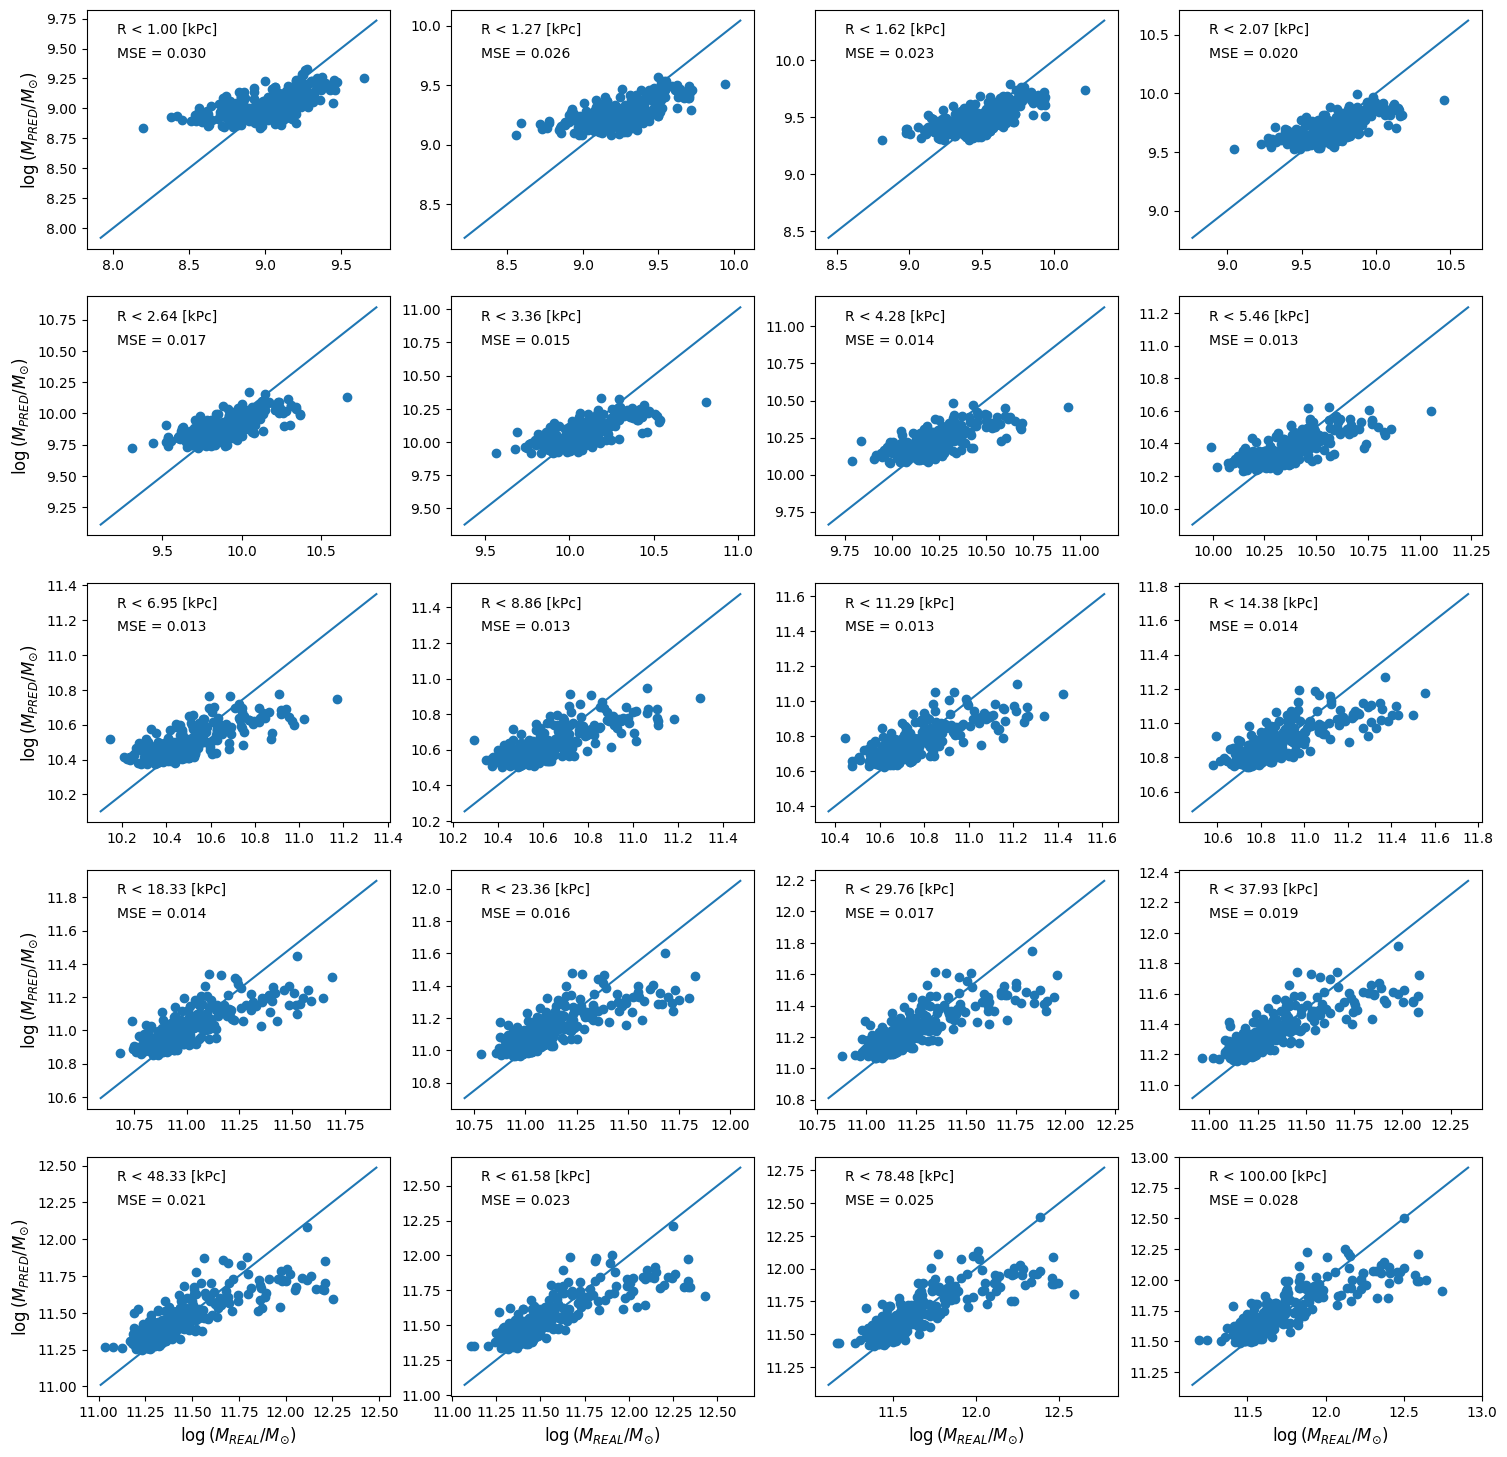

In [ ]:
imask = 1
aux_pred = masked_mass_predictions[imask]
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):

        ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))
        ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

        if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
        if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

        ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)

plt.savefig('/content/drive/MyDrive/TNG-data/graphs/RealVSPred_' + name + f'_Inversemask_{R_bins[imask]}.pdf')

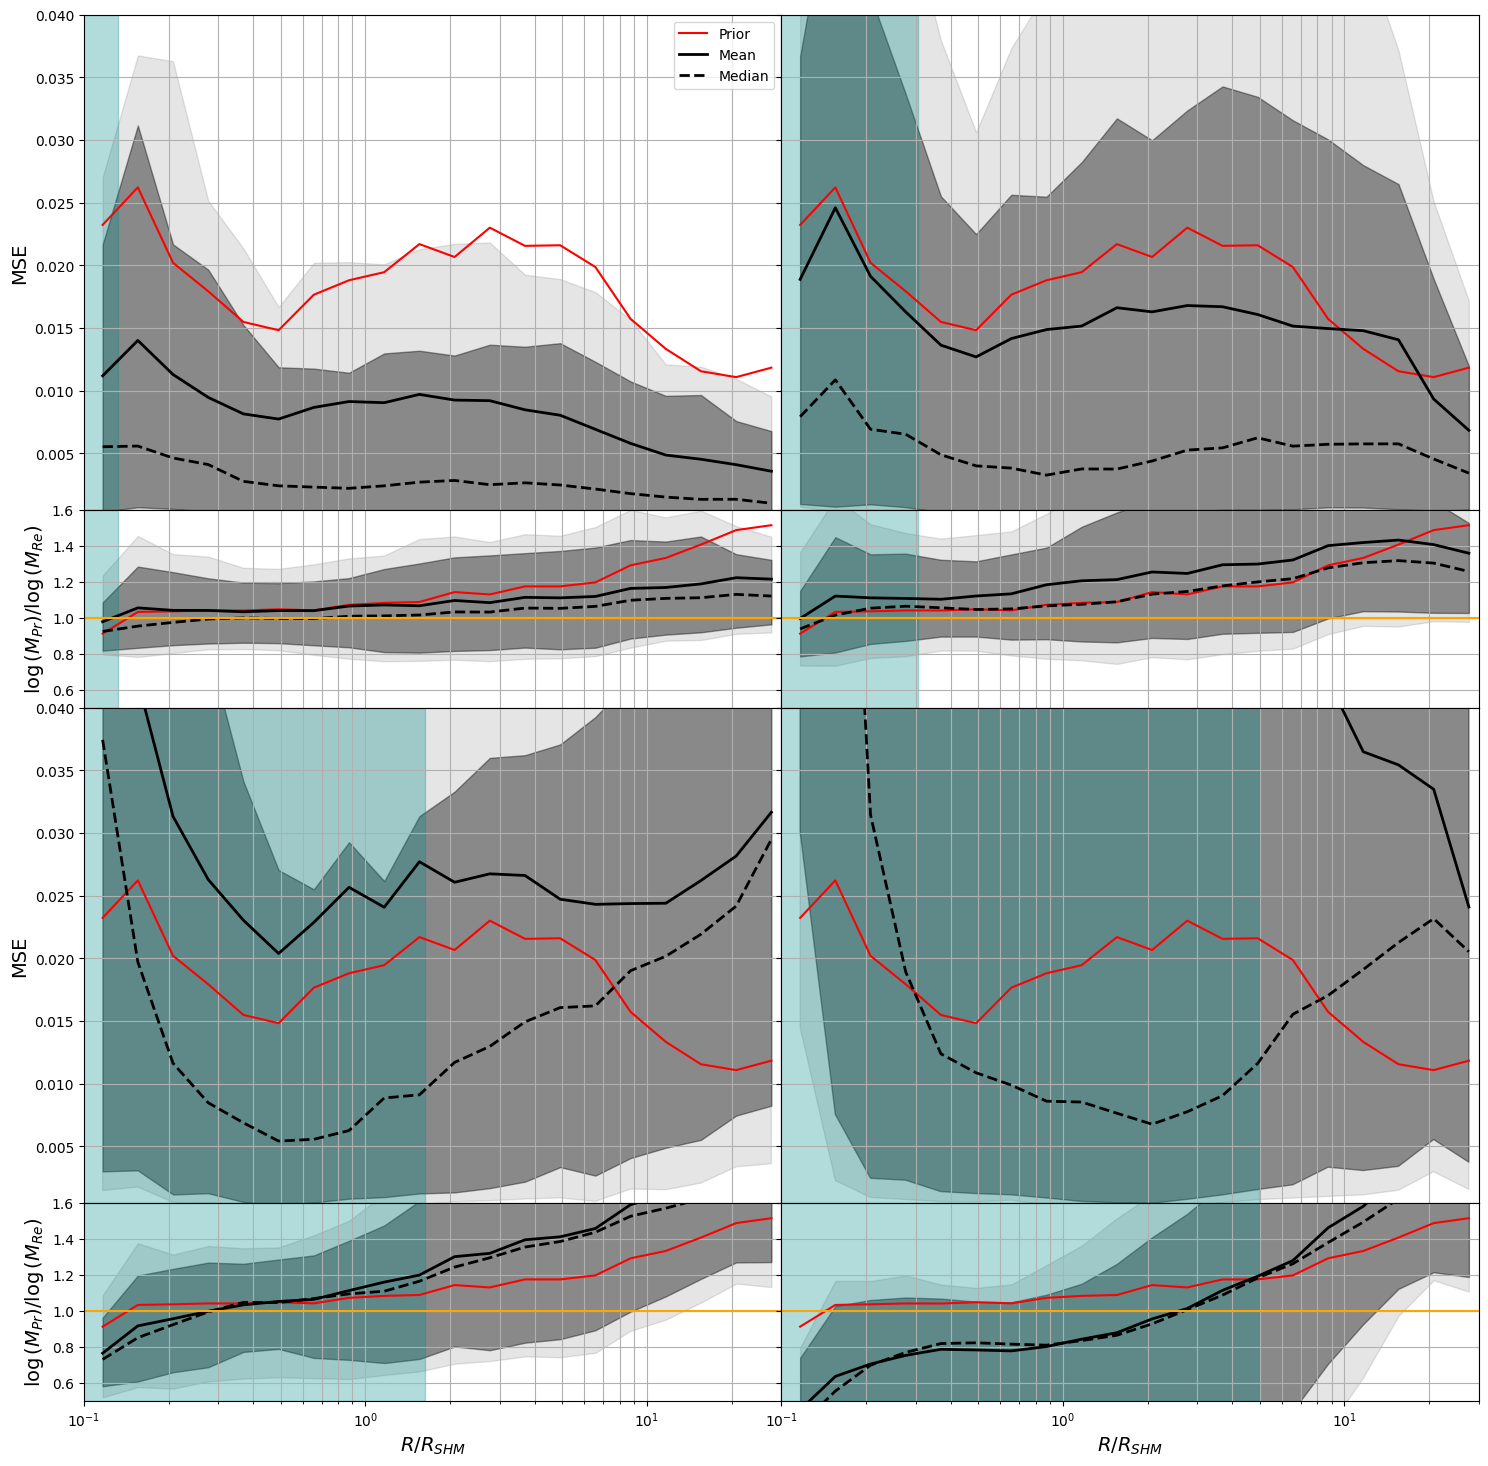

In [ ]:
r = np.zeros_like(masked_mass_predictions[15])
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]

fig,ax = plt.subplots(4,2, figsize = (18,18), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)

for ii, iaux in enumerate([1, 4, 10, 14]):
    jj = 0
    if ii > 1:
        ii = ii-2
        jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)

    bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (aux_pred - y_testset)**2)
    _, _, mse_prior, _, _, _, p50_prior, _, _ = binned_MSE(r, (y_prior - y_testset)**2, bins = bins)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

    if iaux < 20: ax[jj,ii].axvspan(-1, mask_size_in_hmr[iaux], color='darkcyan', alpha=0.3)

    _, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, aux_pred / y_testset, bins = bins)
    _, _, ratio_prior, _, _, _, _, _, _ = binned_MSE(r, y_prior / y_testset, bins = bins)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior')

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

    if iaux < 20: ax[jj+1,ii].axvspan(-1, mask_size_in_hmr[iaux], color='darkcyan', alpha=0.3)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.04)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.04)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.04)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.04)
ax[3,1].set_ylim(0.5,1.6)

ax[0,0].set_xlim(0.1, 30)

ax[3,0].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[3,1].set_xlabel('$R / R_{SHM}$', fontsize = 14)

ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

plt.savefig('/content/drive/MyDrive/TNG-data/graphs/InverseMaskedNormalizedMSE_' + name + '.pdf')

# Masking channels

In [ ]:
r = np.zeros_like(aux_pred)
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]


In [ ]:
ZP = [24.63, 25.11, 24.80, 24.36, 22.83]
mean_mag_arcsec2 = [22.01, 21.84, 20.84, 20.16, 18.96]
std_mag_arcsec2 = 0.1
noisy_mask = True
full_noise = False

mask_size_in_hmr = np.geomspace(1, 20, 20)
x, y = np.ogrid[:128, :128]

masked_mass_predictions = []
masked_size_list = []

titles = ['Full','w/o HI','w/o SDSS',
          'w/o SDSS-U','w/o SDSS-G','w/o SDSS-R','w/o SDSS-I','w/o SDSS-Z',
          'w/o HI-0','w/o HI-1','w/o HI-2',
          'SDSS-UGR + HI-0', 'SDSS-UGR + HI-1','SDSS-UGR + HI-2',
          'SDSS-UGRI + HI-0', 'SDSS-UGRI + HI-1','SDSS-UGRI + HI-2']

delete_ch_list = [[8], [5,6,7], [0,1,2,3,4],
                  [0],[1],[2],[3],[4],
                  [5],[6],[7],
                  [3,4,6,7],[3,4,5,7],[3,4,5,6],
                  [3,6,7],[3,5,7],[3,5,6]]
for delete_ch in tqdm(delete_ch_list):
    for nbin in range(1):
        x_testset_masked = np.copy(x_testset)
        masked_size_aux = []
        for nimg in range(test_size):
            for ch in delete_ch:
                if nbin == 20:
                    mask = (x - 64)**2 + (y - 64)**2 <= int(10000 / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2
                elif nbin == 0:
                    mask = np.zeros((128, 128), dtype=bool)
                else:
                    mask_size = mask_size_in_hmr[nbin] * properties[test_ind[nimg], 13] # R_bins[nbin]
                    mask = (x - 64)**2 + (y - 64)**2 <= int(mask_size / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

                # Aplicar la máscara a la imagen
                if ch < 8:
                    image_masked = x_testset[nimg,ch,:,:].copy()
                    if nbin < 20: image_masked[~mask] = 0  # Establecer a 0 los píxeles fuera del círculo

                    noise = np.zeros_like(image_masked)
                    if noisy_mask and (ch < 5):
                        mean_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr) # From https://classic.sdss.org/dr7/algorithms/fluxcal.php
                        std_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] - std_mag_arcsec2 + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr)
                        noise = np.random.normal(mean_mjysr, np.abs(std_mjysr - mean_mjysr), size=(128,128))
                        noise = ((noise - min_x[ch,:,:]) / (max_x[ch,:,:] - min_x[ch,:,:]))
                        noise[mask] = 0
                    bkg_noise = np.zeros_like(image_masked)
                    if full_noise:
                        q = np.quantile(x_testset[nimg,ch,:,:], q = (0.1,0.2,0.3))
                        bkg_noise = np.abs(np.random.normal(q[1], scale = q[2] - q[0], size = (128,128)))
                    x_testset_masked[nimg,ch,:,:] = image_masked + noise + bkg_noise
            masked_size_aux.append(len(np.where(mask == False)[0]))
        masked_size_list.append(masked_size_aux)
        # Crear los DataLoaders para entrenamiento y validación
        masked_test_dataset  = CustomDataset(x_testset_masked, y_testset)
        masked_test_loader  = DataLoader(masked_test_dataset, batch_size=32, shuffle=False)

        masked_M_pred_list = []
        masked_test_loss_list = []
        for i in range(1,10):
            #best_model_path = '../data/models/best_model_' + name + '_' + str(i) + '.pth'
            best_model_path = '/content/drive/MyDrive/TNG/TNG-data/models/best_model_' + name + '_' + str(i) + '_new.pth'

            model.load_state_dict(torch.load(best_model_path, weights_only=True))

            model.eval()  # Asegúrate de que el modelo esté en modo evaluación
            y_predicted_masked = []  # Lista para almacenar las predicciones

            # Desactivamos el cálculo de gradientes durante la predicción
            with torch.no_grad():
                test_loss = 0
                for inputs, true_vals in masked_test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset

                    #input data to GPU
                    inputs = inputs.to(device)
                    true_vals = true_vals.to(device)
                    #predictions
                    outputs = model(inputs)

                    # masked predictions
                    y_predicted_masked.append(outputs.detach().cpu().numpy())

                    test_loss += criterion(outputs, true_vals)

            test_loss = test_loss / len(test_loader)
            #print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
            masked_test_loss_list.append(test_loss)

            # Convertir la lista de predicciones en un solo array
            y_predicted_masked = np.concatenate(y_predicted_masked, axis=0)

            #print(y_predicted_masked.shape)  # Esto te dará la forma de las predicciones

            masked_M_pred = 10**(y_predicted_masked * (max_y - min_y) + min_y)
            M_real = 10**(y_testset * (max_y - min_y) + min_y)

            mass_quantiles = np.percentile((masked_M_pred / M_real), [25, 50, 75], axis=0)
            masked_M_pred_list.append(masked_M_pred)

        if len(masked_M_pred_list) > 1:
            masked_M_pred_list = np.asarray(masked_M_pred_list)
            masked_M_pred = np.mean(masked_M_pred_list, axis = 0)
            masked_M_pred_std = np.std(masked_M_pred_list, axis = 0)
        else:
            masked_M_pred_std = None

        y_predicted_masked = (np.log10(masked_M_pred) - min_y) / (max_y - min_y)
        masked_mass_predictions.append(masked_M_pred)

100%|██████████| 17/17 [01:16<00:00,  4.53s/it]


In [ ]:
ZP = [24.63, 25.11, 24.80, 24.36, 22.83]
mean_mag_arcsec2 = [22.01, 21.84, 20.84, 20.16, 18.96]
std_mag_arcsec2 = 0.1
noisy_mask = True
full_noise = False

mask_size_in_hmr = np.geomspace(1, 20, 20)
x, y = np.ogrid[:128, :128]

masked_mass_predictions = []
masked_size_list = []

titles = ['Full','w/o HI','w/o SDSS',
          'w/o SDSS-U','w/o SDSS-G','w/o SDSS-R','w/o SDSS-I','w/o SDSS-Z',
          'w/o HI-0','w/o HI-1','w/o HI-2',
          'SDSS-UGR + HI-0', 'SDSS-UGR + HI-1','SDSS-UGR + HI-2',
          'SDSS-UGRI + HI-0', 'SDSS-UGRI + HI-1','SDSS-UGRI + HI-2']

delete_ch_list = [[8], [5,6,7], [0,1,2,3,4],
                  [0],[1],[2],[3],[4],
                  [5],[6],[7],
                  [3,4,6,7],[3,4,5,7],[3,4,5,6],
                  [3,6,7],[3,5,7],[3,5,6]]
for delete_ch in tqdm(delete_ch_list):
    for nbin in range(1):
        x_testset_masked = np.copy(x_testset)
        masked_size_aux = []
        for nimg in range(test_size):
            for ch in delete_ch:
                if nbin == 20:
                    mask = (x - 64)**2 + (y - 64)**2 <= int(10000 / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2
                elif nbin == 0:
                    mask = np.zeros((128, 128), dtype=bool)
                else:
                    mask_size = mask_size_in_hmr[nbin] * properties[test_ind[nimg], 13] # R_bins[nbin]
                    mask = (x - 64)**2 + (y - 64)**2 <= int(mask_size / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

                # Aplicar la máscara a la imagen
                if ch < 8:
                    image_masked = x_testset[nimg,ch,:,:].copy()
                    if i < 20: image_masked[~mask] = 0  # Establecer a 0 los píxeles fuera del círculo

                    noise = np.zeros_like(image_masked)
                    if noisy_mask and (ch < 5):
                        mean_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr) # From https://classic.sdss.org/dr7/algorithms/fluxcal.php
                        std_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] - std_mag_arcsec2 + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr)
                        noise = np.random.normal(mean_mjysr, np.abs(std_mjysr - mean_mjysr), size=(128,128))
                        noise = ((noise - min_x[ch,:,:]) / (max_x[ch,:,:] - min_x[ch,:,:]))
                        noise[mask] = 0
                    bkg_noise = np.zeros_like(image_masked)
                    if full_noise:
                        q = np.quantile(x_testset[nimg,ch,:,:], q = (0.1,0.2,0.3))
                        bkg_noise = np.abs(np.random.normal(q[1], scale = q[2] - q[0], size = (128,128)))
                    x_testset_masked[nimg,ch,:,:] = image_masked + noise + bkg_noise
            masked_size_aux.append(len(np.where(mask == False)[0]))
        masked_size_list.append(masked_size_aux)
        # Crear los DataLoaders para entrenamiento y validación
        masked_test_dataset  = CustomDataset(x_testset_masked, y_testset)
        masked_test_loader  = DataLoader(masked_test_dataset, batch_size=32, shuffle=False)

        masked_M_pred_list = []
        masked_test_loss_list = []
        for i in range(10):
            best_model_path = '/content/drive/MyDrive/TNG/TNG-data/models/best_model_' + name + '_' + str(i) + '_new.pth'

            model.load_state_dict(torch.load(best_model_path, weights_only=True))

            model.eval()  # Asegúrate de que el modelo esté en modo evaluación
            y_predicted_masked = []  # Lista para almacenar las predicciones

            # Desactivamos el cálculo de gradientes durante la predicción
            with torch.no_grad():
                test_loss = 0
                for inputs, true_vals in masked_test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset

                    #input data to GPU
                    inputs = inputs.to(device)
                    true_vals = true_vals.to(device)
                    #predictions
                    outputs = model(inputs)

                    # masked predictions
                    y_predicted_masked.append(outputs.detach().cpu().numpy())

                    test_loss += criterion(outputs, true_vals)

            test_loss = test_loss / len(test_loader)
            #print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
            masked_test_loss_list.append(test_loss)

            # Convertir la lista de predicciones en un solo array
            y_predicted_masked = np.concatenate(y_predicted_masked, axis=0)

            #print(y_predicted_masked.shape)  # Esto te dará la forma de las predicciones

            masked_M_pred = 10**(y_predicted_masked * (max_y - min_y) + min_y)
            M_real = 10**(y_testset * (max_y - min_y) + min_y)

            mass_quantiles = np.percentile((masked_M_pred / M_real), [25, 50, 75], axis=0)
            masked_M_pred_list.append(masked_M_pred)

        if len(masked_M_pred_list) > 1:
            masked_M_pred_list = np.asarray(masked_M_pred_list)
            masked_M_pred = np.mean(masked_M_pred_list, axis = 0)
            masked_M_pred_std = np.std(masked_M_pred_list, axis = 0)
        else:
            masked_M_pred_std = None

        y_predicted_masked = (np.log10(masked_M_pred) - min_y) / (max_y - min_y)
        masked_mass_predictions.append(masked_M_pred)

100%|██████████| 17/17 [00:27<00:00,  1.60s/it]


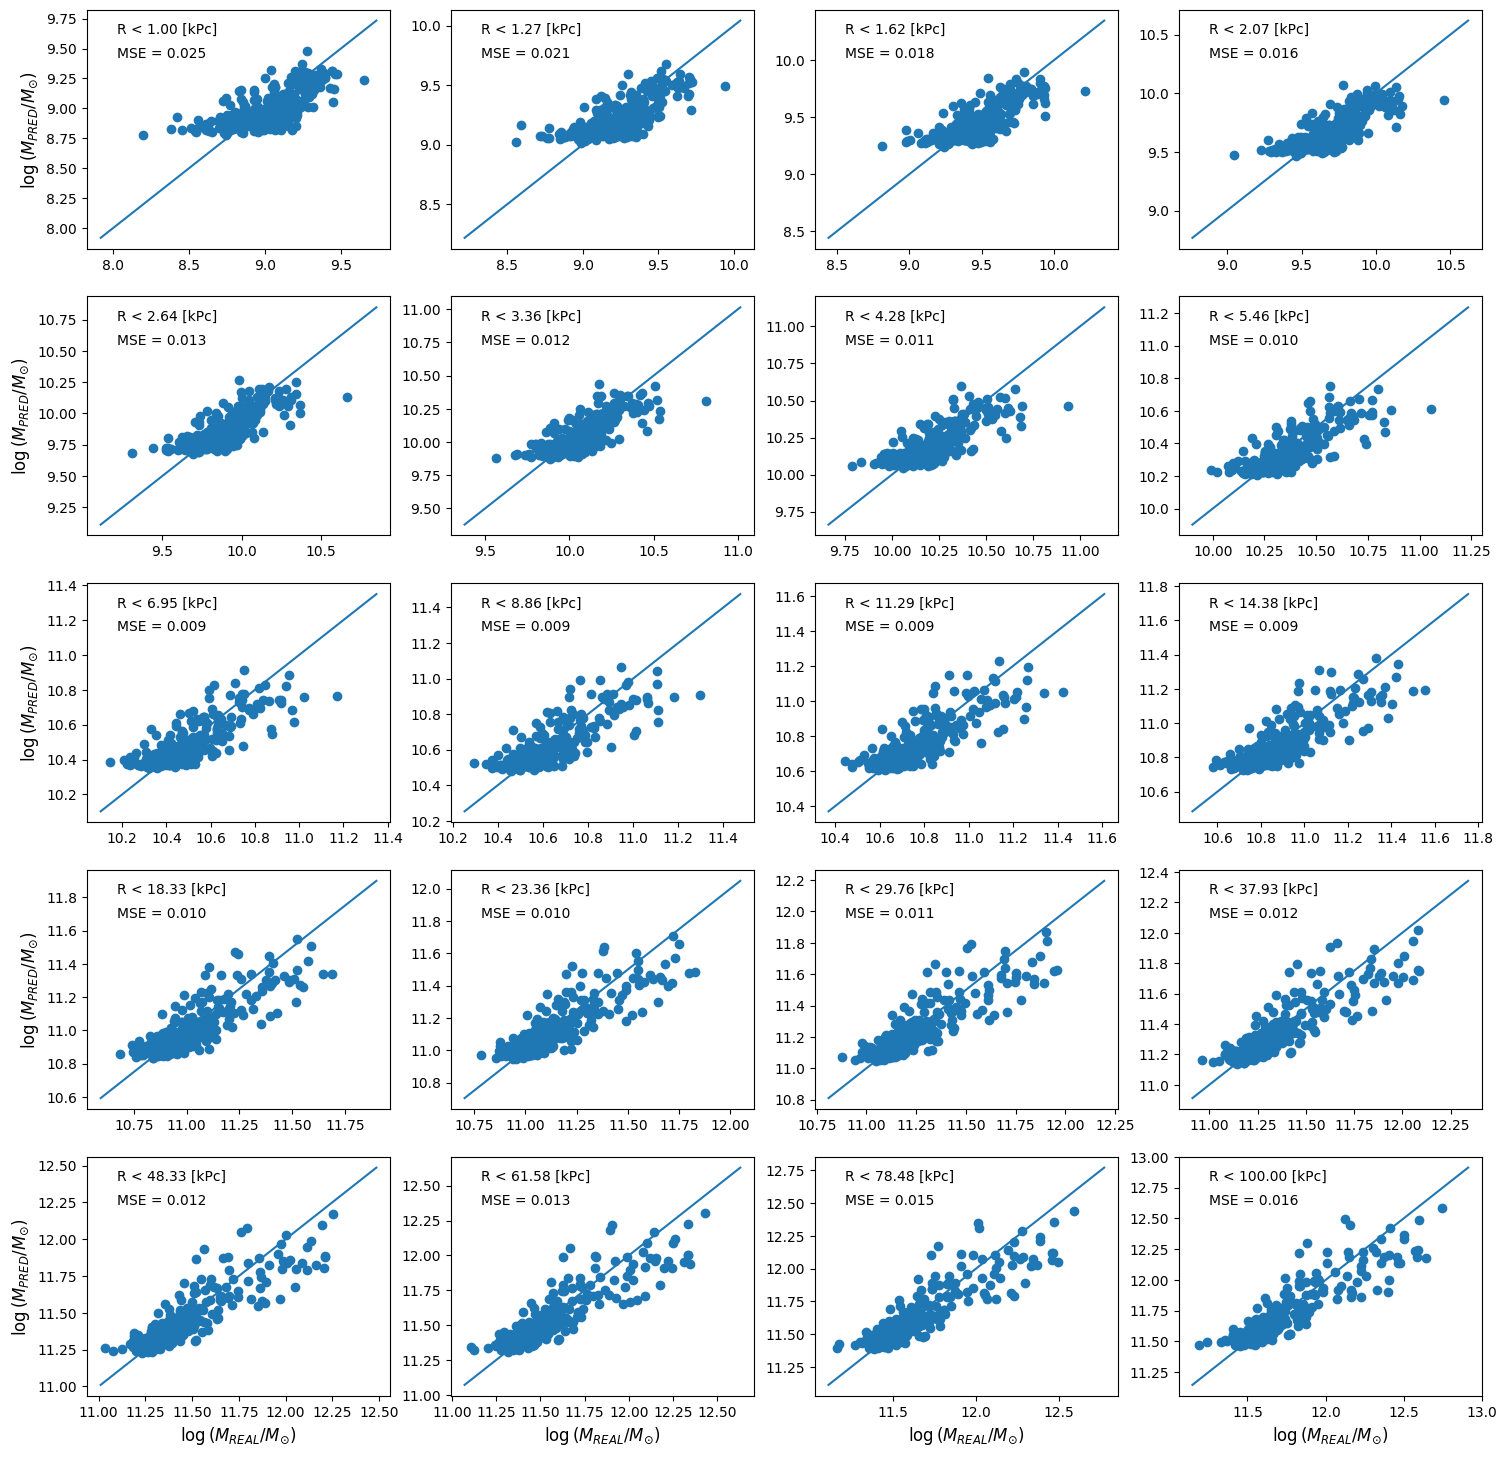

In [ ]:
imask = 0
aux_pred = masked_mass_predictions[imask]
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):

        ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))
        ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

        if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
        if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

        ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)

plt.savefig('/content/drive/MyDrive/TNG-data/graphs/RealVSPred_' + name + f'_mask_{R_bins[imask]}' +'_E2CNN_new.pdf')

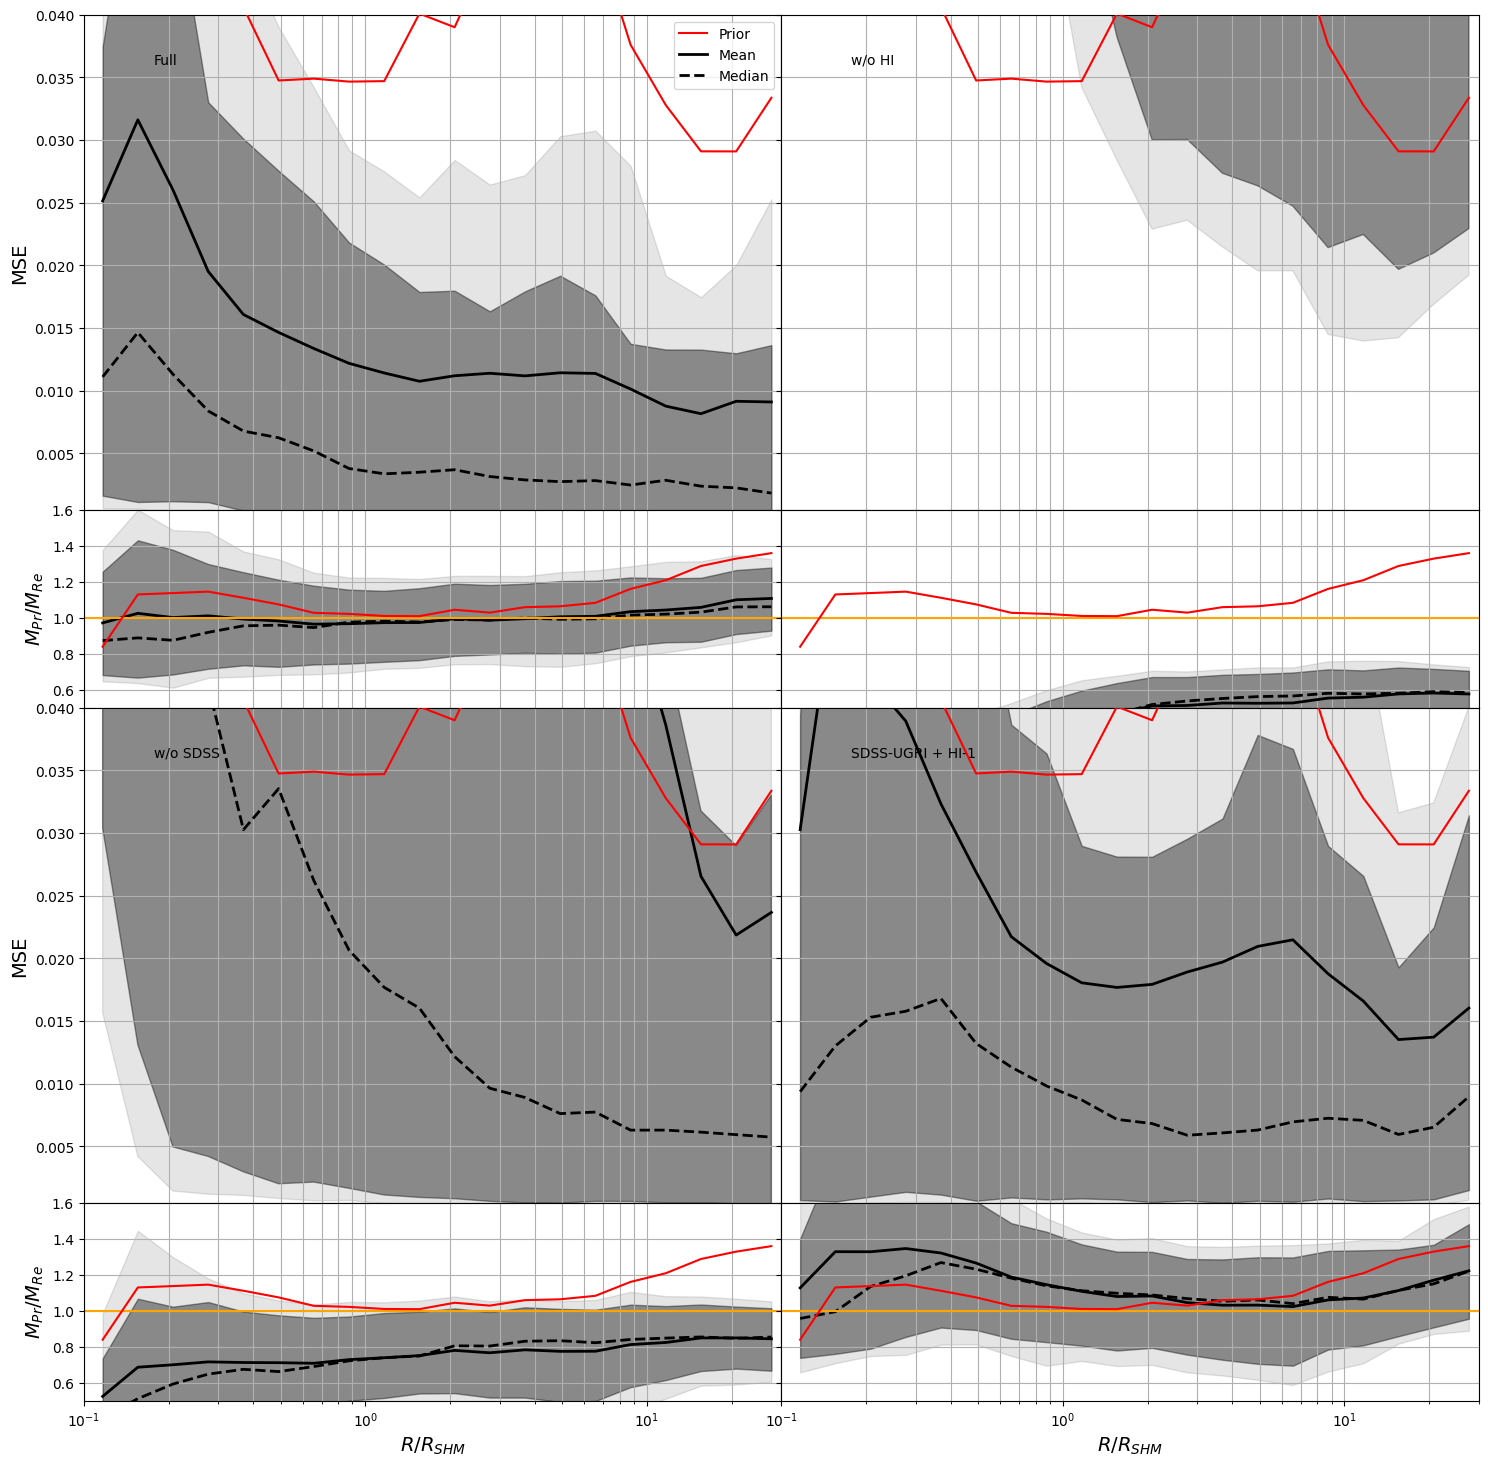

In [ ]:
r = np.zeros_like(masked_mass_predictions[0])
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]

fig,ax = plt.subplots(4,2, figsize = (18,18), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)

for ii, iaux in enumerate([0,1,2,15]):
    jj = 0
    if ii > 1:
        ii = ii-2
        jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    #aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)

    bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (np.log10(aux_pred) - np.log10(M_real))**2)
    _, _, mse_prior, prior_std, prior10, prior16, prior50, prior84, prior90 = binned_MSE(r, (np.log10(M_prior) - np.log10(M_real))**2, bins = bins)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior', zorder = 10)
    #ax[jj,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

    ax[jj,ii].text(0.1, 0.9, titles[iaux], transform = ax[jj,ii].transAxes)

    _, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, aux_pred / M_real, bins = bins)
    _, _, ratio_prior, prior_std, prior10, prior16, prior50, prior84, prior90 = binned_MSE(r, M_prior / M_real, bins = bins)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior', zorder = 10)
    #ax[jj+1,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj+1,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.04)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.04)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.04)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.04)
ax[3,1].set_ylim(0.5,1.6)

ax[0,0].set_xlim(0.1, 30)

ax[3,0].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[3,1].set_xlabel('$R / R_{SHM}$', fontsize = 14)

ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

plt.savefig('/content/drive/MyDrive/TNG/graphs/MaskedChannelsNormalizedMSE_' + name + '_E2CNN.pdf', bbox_inches = 'tight')

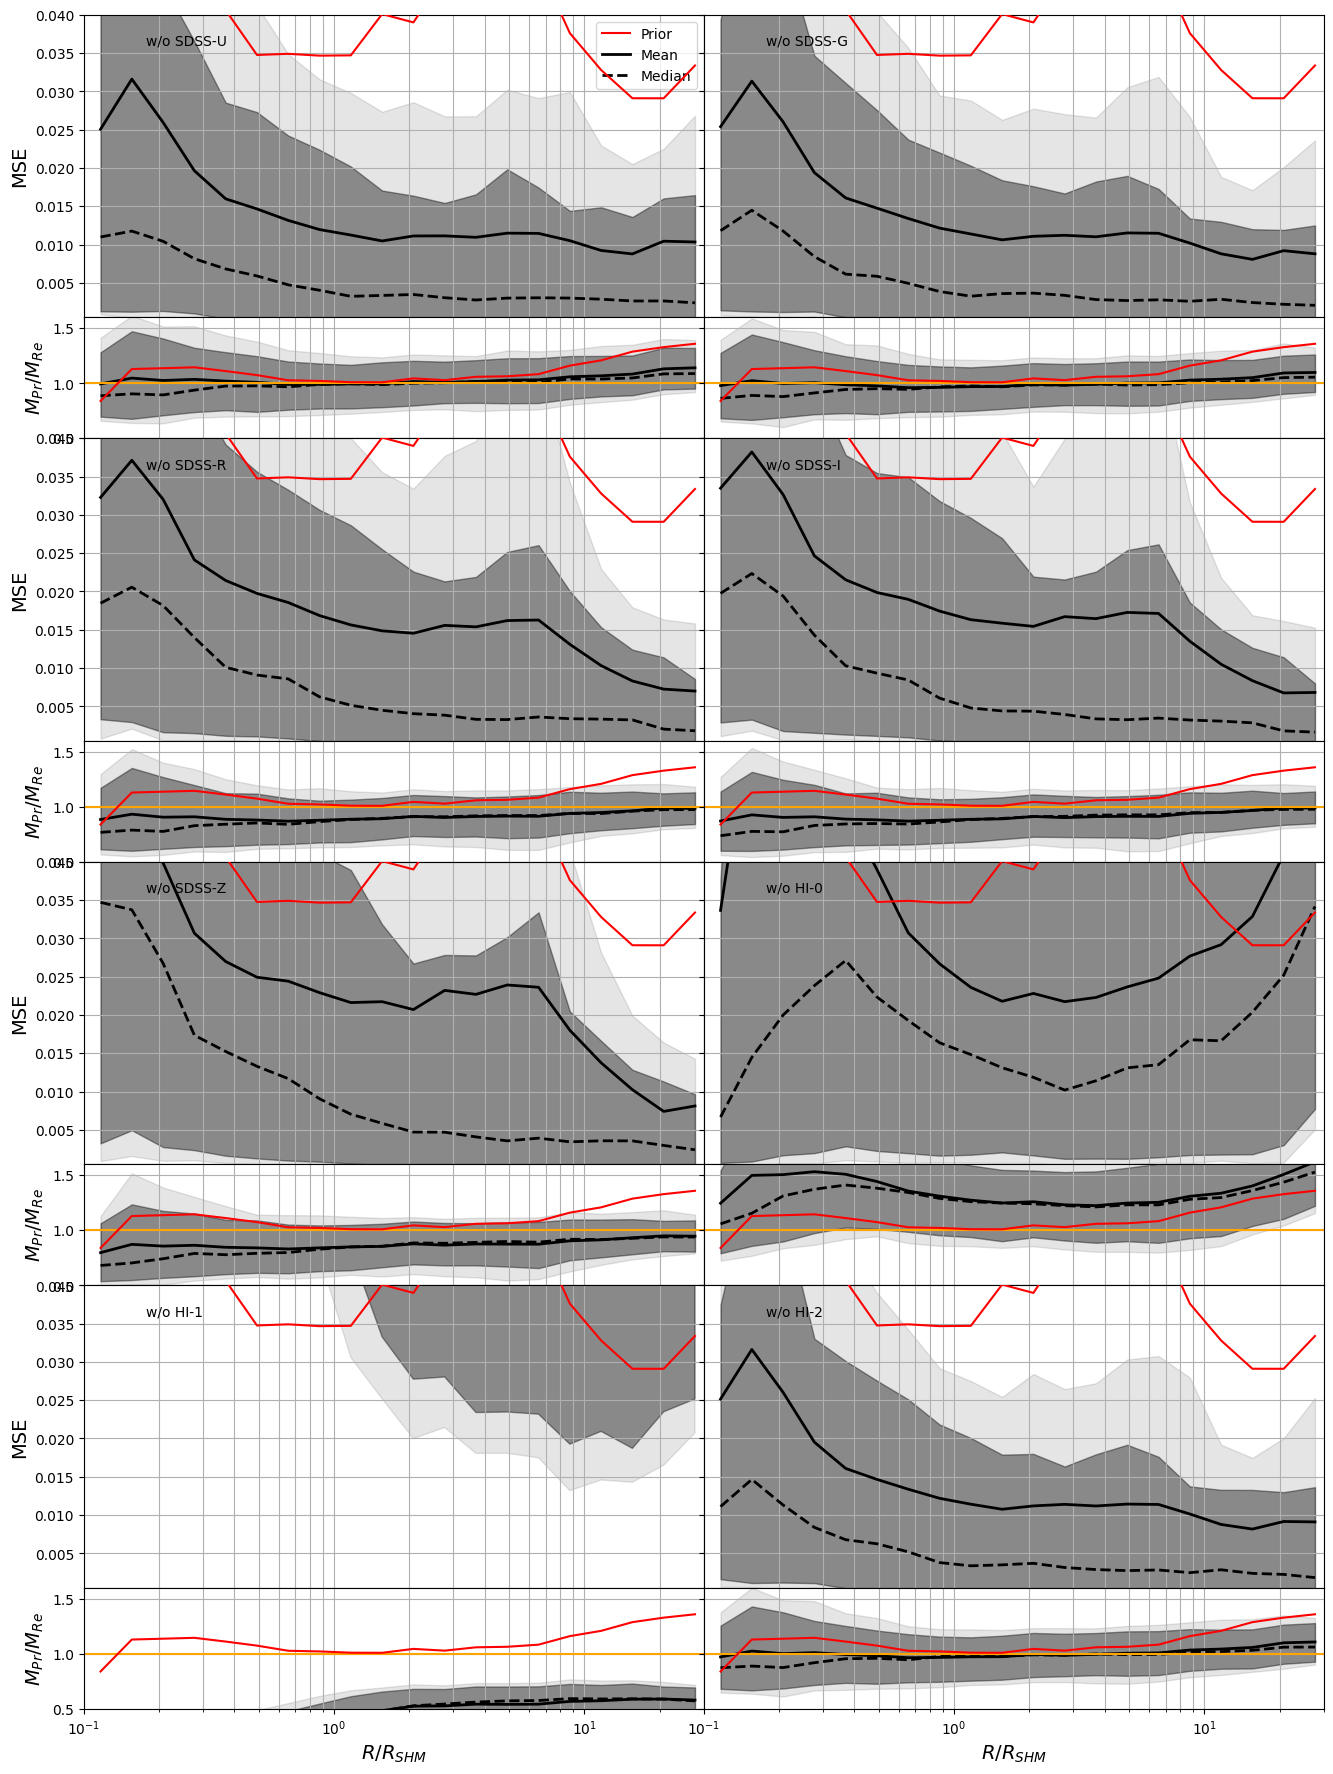

In [ ]:
r = np.zeros_like(masked_mass_predictions[0])
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]

fig,ax = plt.subplots(8,2, figsize = (16,22), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1, 2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)

jj_vals = [0,0,2,2,4,4,6,6]
ii_vals = [0,1,0,1,0,1,0,1]
for i, iaux in enumerate([3,4,5,6,7,8,9,10]):
    jj = jj_vals[i]
    ii = ii_vals[i]
    #if ii > 1:
    #    ii = ii-2
        #jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    #aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)

    bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (np.log10(aux_pred) - np.log10(M_real))**2)
    _, _, mse_prior, prior_std, prior10, prior16, prior50, prior84, prior90 = binned_MSE(r, (np.log10(M_prior) - np.log10(M_real))**2, bins = bins)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior', zorder = 10)
    #ax[jj,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

    ax[jj,ii].text(0.1, 0.9, titles[iaux], transform = ax[jj,ii].transAxes)

    _, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, aux_pred / M_real, bins = bins)
    _, _, ratio_prior, prior_std, prior10, prior16, prior50, prior84, prior90 = binned_MSE(r, M_prior / M_real, bins = bins)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior', zorder = 10)
    #ax[jj+1,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj+1,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')
ax[5,0].axhline(y=1, color = 'orange')
ax[5,1].axhline(y=1, color = 'orange')
ax[7,0].axhline(y=1, color = 'orange')
ax[7,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.04)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.04)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.04)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.04)
ax[3,1].set_ylim(0.5,1.6)
ax[4,0].set_ylim(0.0005,0.04)
ax[5,0].set_ylim(0.5,1.6)
ax[4,1].set_ylim(0.0005,0.04)
ax[5,1].set_ylim(0.5,1.6)
ax[6,0].set_ylim(0.0005,0.04)
ax[7,0].set_ylim(0.5,1.6)
ax[6,1].set_ylim(0.0005,0.04)
ax[7,1].set_ylim(0.5,1.6)

ax[0,0].set_xlim(0.1, 30)


ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[4,0].set_ylabel('MSE', fontsize = 14)
ax[5,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[6,0].set_ylabel('MSE', fontsize = 14)
ax[7,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')
ax[4,1].set_ylabel('')
ax[5,1].set_ylabel('')
ax[6,1].set_ylabel('')
ax[7,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])
ax[4,1].set_yticklabels([])
ax[5,1].set_yticklabels([])
ax[6,1].set_yticklabels([])
ax[7,1].set_yticklabels([])

ax[7,0].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[7,1].set_xlabel('$R / R_{SHM}$', fontsize = 14)

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

plt.savefig('/content/drive/MyDrive/TNG/graphs/Masked1DChannelsNormalizedMSE_' + name + '_E2CNN.pdf', bbox_inches = 'tight')

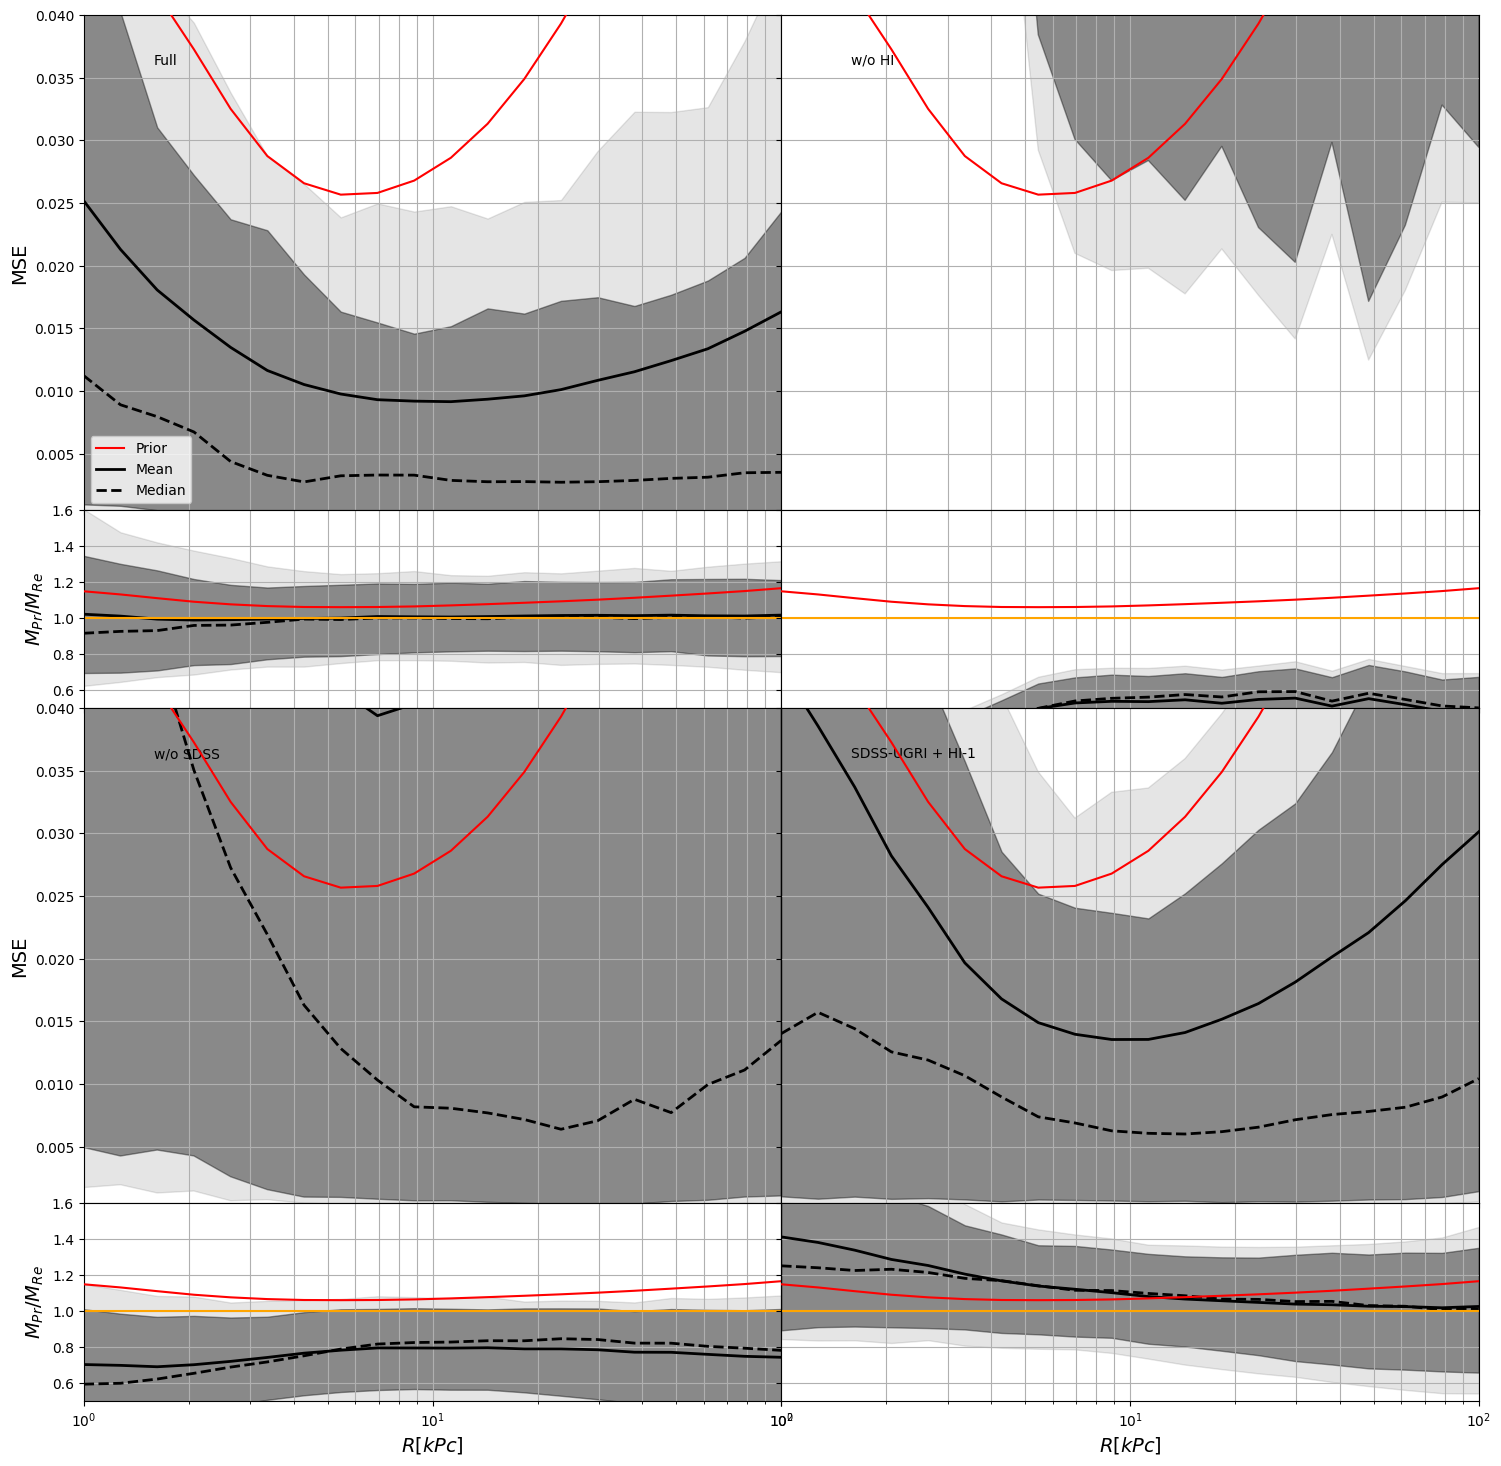

In [ ]:
fig,ax = plt.subplots(4,2, figsize = (18,18), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)

bin_centers = R_bins
for ii, iaux in enumerate([0,1,2,15]):
    jj = 0
    if ii > 1:
        ii = ii-2
        jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    #aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)

    mse, std, p_results = binned_MSE_kpc((np.log10(aux_pred) - np.log10(M_real))**2)
    mse_prior, std_prior, prior_results = binned_MSE_kpc((np.log10(M_prior) - np.log10(M_real))**2)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior', zorder = 10)
    #ax[jj,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p_results['10'], p_results['90'], color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p_results['16'], p_results['84'], color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p_results['50'], color = 'black', label = 'Median', ls = '--', lw = 2)

    ax[jj,ii].text(0.1, 0.9, titles[iaux], transform = ax[jj,ii].transAxes)

    ratio, std, p_results = binned_MSE_kpc(aux_pred / M_real)
    ratio_prior, prior_std, prior_results = binned_MSE_kpc(M_prior / M_real)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior', zorder = 10)
    #ax[jj+1,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj+1,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p_results['10'], p_results['90'], color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p_results['16'], p_results['84'], color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p_results['50'], color = 'black', label = 'Median', ls = '--', lw = 2)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.04)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.04)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.04)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.04)
ax[3,1].set_ylim(0.5,1.6)

ax[0,0].set_xlim(1, 100)

ax[3,0].set_xlabel('$R [kPc]$', fontsize = 14)
ax[3,1].set_xlabel('$R [kPc]$', fontsize = 14)

ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

plt.savefig('/content/drive/MyDrive/TNG/graphs/MaskedChannelsMSE_' + name + '_E2CNN.pdf', bbox_inches = 'tight')

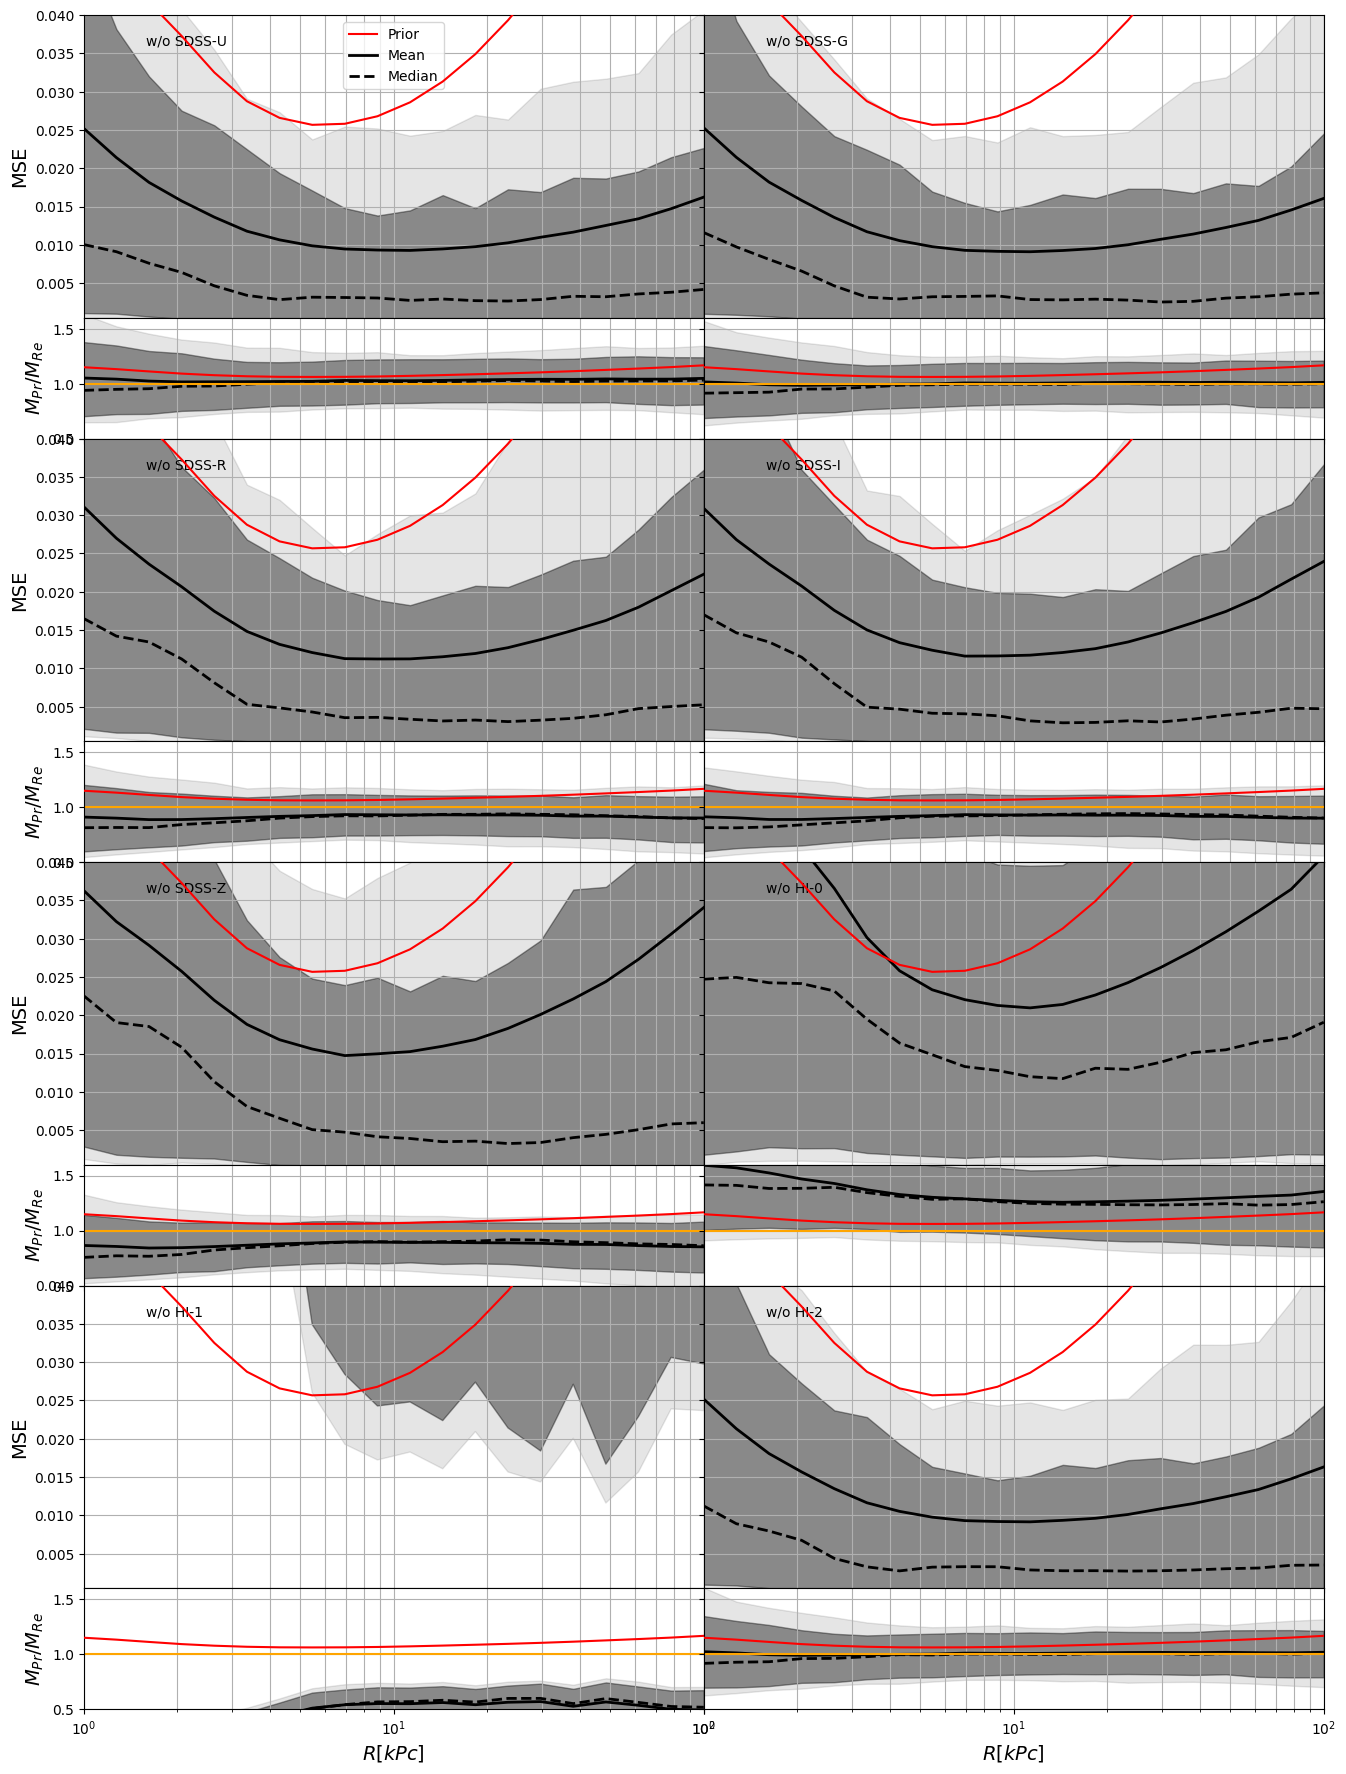

In [ ]:
fig,ax = plt.subplots(8,2, figsize = (16,22), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1, 2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)

bin_centers = R_bins

jj_vals = [0,0,2,2,4,4,6,6]
ii_vals = [0,1,0,1,0,1,0,1]
for i, iaux in enumerate([3,4,5,6,7,8,9,10]):
    jj = jj_vals[i]
    ii = ii_vals[i]
    #if ii > 1:
    #    ii = ii-2
        #jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    #aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)

    mse, std, p_results = binned_MSE_kpc((np.log10(aux_pred) - np.log10(M_real))**2)
    mse_prior, prior_std, prior_results = binned_MSE_kpc((np.log10(M_prior) - np.log10(M_real))**2)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior', zorder = 10)
    #ax[jj,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p_results['10'], p_results['90'], color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p_results['16'], p_results['84'], color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p_results['50'], color = 'black', label = 'Median', ls = '--', lw = 2)

    ax[jj,ii].text(0.1, 0.9, titles[iaux], transform = ax[jj,ii].transAxes)

    ratio, std, p_results = binned_MSE_kpc(aux_pred / M_real)
    ratio_prior, prior_std, prior_results = binned_MSE_kpc(M_prior / M_real)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior', zorder = 10)
    #ax[jj+1,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj+1,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p_results['10'], p_results['90'], color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p_results['16'], p_results['84'], color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p_results['50'], color = 'black', label = 'Median', ls = '--', lw = 2)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')
ax[5,0].axhline(y=1, color = 'orange')
ax[5,1].axhline(y=1, color = 'orange')
ax[7,0].axhline(y=1, color = 'orange')
ax[7,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.04)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.04)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.04)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.04)
ax[3,1].set_ylim(0.5,1.6)
ax[4,0].set_ylim(0.0005,0.04)
ax[5,0].set_ylim(0.5,1.6)
ax[4,1].set_ylim(0.0005,0.04)
ax[5,1].set_ylim(0.5,1.6)
ax[6,0].set_ylim(0.0005,0.04)
ax[7,0].set_ylim(0.5,1.6)
ax[6,1].set_ylim(0.0005,0.04)
ax[7,1].set_ylim(0.5,1.6)

ax[0,0].set_xlim(1, 100)

ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[4,0].set_ylabel('MSE', fontsize = 14)
ax[5,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[6,0].set_ylabel('MSE', fontsize = 14)
ax[7,0].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')
ax[4,1].set_ylabel('')
ax[5,1].set_ylabel('')
ax[6,1].set_ylabel('')
ax[7,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])
ax[4,1].set_yticklabels([])
ax[5,1].set_yticklabels([])
ax[6,1].set_yticklabels([])
ax[7,1].set_yticklabels([])

ax[7,0].set_xlabel('$R [kPc]$', fontsize = 14)
ax[7,1].set_xlabel('$R [kPc]$', fontsize = 14)

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

plt.savefig('/content/drive/MyDrive/TNG/graphs/Masked1DChannelsMSE_' + name + '_E2CNN.pdf', bbox_inches = 'tight')

### Grad-CAM

In [ ]:

from torch.autograd import Function

In [ ]:
# Hook to get the feature maps and gradients from the last convolutional layer
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.gradients = None

    def save_features(self, module, input, output):
        # Save the feature maps
        self.feature_maps = output

    def save_grads(self, module, input, output):
        # Save the gradients
        self.gradients = output

    def register_hooks(self):
        # Register hooks on the last convolutional layer
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                module.register_forward_hook(self.save_features)
                module.register_backward_hook(self.save_grads)

    def clear_hooks(self):
        self.feature_maps = None
        self.gradients = None

# Grad-CAM computation
def grad_cam(model, image, target_index=None):
    model.eval()

    # Feature extractor for the last convolutional layer
    extractor = FeatureExtractor(model)
    extractor.register_hooks()

    # Forward pass
    output = model(image)

    # Choose which output to backpropagate with if it's a regression task
    if target_index is None:
        target_index = 0  # You can choose any of the 20 outputs here

    # Backward pass for the selected target output
    model.zero_grad()
    output[0, target_index].backward(retain_graph=True)

    # Get the gradients and feature maps
    gradients = extractor.gradients
    feature_maps = extractor.feature_maps

    # Pool the gradients across all the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3], keepdim=True)

    # Weight the feature maps by the pooled gradients
    for i in range(feature_maps.shape[1]):
        feature_maps[:, i, :, :] *= pooled_gradients[:, i, :, :]

    # Create the Grad-CAM heatmap by summing the weighted feature maps
    grad_cam_map = torch.sum(feature_maps, dim=1).squeeze()

    # Apply ReLU to the heatmap
    grad_cam_map = torch.relu(grad_cam_map)

    # Normalize the heatmap
    grad_cam_map = grad_cam_map.detach().cpu().numpy()
    grad_cam_map = (grad_cam_map - np.min(grad_cam_map)) / (np.max(grad_cam_map) - np.min(grad_cam_map))

    return grad_cam_map

# Plot the Grad-CAM heatmap
def plot_grad_cam(image, grad_cam_map):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Convert the image back to numpy for visualization
    original_image = image[0].permute(1, 2, 0).cpu().numpy()
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())  # Normalize

    ax[0].imshow(original_image)
    ax[0].axis('off')
    ax[0].set_title("Original Image")

    ax[1].imshow(grad_cam_map, cmap='jet')
    ax[1].axis('off')
    ax[1].set_title("Grad-CAM Heatmap")

    plt.show()

In [ ]:
best_model_path = '/content/drive/MyDrive/data_TNG/models/best_model_' + name + '_' + str(9) + '_new.pth'

model.load_state_dict(torch.load(best_model_path))

model.eval()

device = torch.device('cuda:0')


# Feature extractor for the last convolutional layer
extractor = FeatureExtractor(model)
extractor.register_hooks()

# Forward pass
image=image.to(device)
output = model(image)

target_index = 0  # You can choose any of the 20 outputs here

# Backward pass for the selected target output
model.zero_grad()
output[0, target_index].backward(retain_graph=True)

# Get the gradients and feature maps
gradients = extractor.gradients
feature_maps = extractor.feature_maps


In [ ]:
feature_maps.shape

In [ ]:

# Pool the gradients across all the channels
pooled_gradients = torch.mean(gradients[0], dim=(0,1),keepdim = True)

In [ ]:
pooled_gradients.shape

In [ ]:
# Test the Grad-CAM on a specific image
for images, targets in test_loader:
    image = images[0].unsqueeze(0)  # Select the first image and add batch dimension
    grad_cam_map = grad_cam(model, image, target_index=0)  # Compute Grad-CAM for the first output
    plot_grad_cam(image, grad_cam_map)
    break  # Only process the first image

# Deprecated

In [ ]:
from pts.visual.rgbimage import RGBImage
import astropy.units as u

img_array = x_testset[nimg,ch,:,:] * (max_x - min_x) + min_x
img_array = np.stack((img_array, img_array, img_array), axis=-1) * u.Unit('MJy/sr')
image = RGBImage(img_array.value)
fmin = 1e-5 * u.MJy/u.sr
fmax = 1e3 * u.MJy/u.sr
image.setRange(fmin.value, fmax.value)
image.applyLog()     # Aplicar transformación logarítmica
image.applyCurve()   # Aplicar curva de color
image.plot()